# Notes (à enlever à la fin)

The report must include:
- a short introduction of the context and goals
- the whole processing pipeline (including the methods that didn't work!!). Every step should be justified (not only the results but the interpretation is important). Don't forget to comment your code where needed (and to keep it clean)!
- a conclusion/discussion on the results of your pipeline

Timeline
1. Read the images.
2. Check that the images are of sufficient quality and that they do not require preprocessing.
3. Suggest a method for segmenting nematodes.
4. Extract geometric descriptors for each nematode that could reflect its living or dead
status.
5. Confirm by statistical test the effect of the drug.

# Pistes à tester (à enlever à la fin)

- local thresholding
- Split-and-merge


# Introduction

# Imports des librairies

In [4]:
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from skimage import filters, segmentation, feature, measure
from sklearn.cluster import KMeans
from scipy import ndimage as ndi
from scipy import signal
from PIL import Image
from collections import Counter
from skimage.morphology import skeletonize
import networkx as nx


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.5 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/lilian/anaconda3/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/lilian/anaconda3/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/lilian/anaconda3/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop.start()
  File "/home/lilia

AttributeError: _ARRAY_API not found

# Import des images

In [5]:
l_img = []

for filename in os.listdir("Data"):
    img_path = os.path.join("Data", filename)
    img = np.array(Image.open(img_path))
    l_img.append(img)

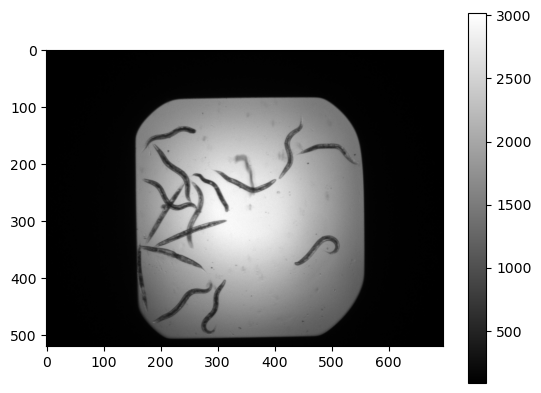

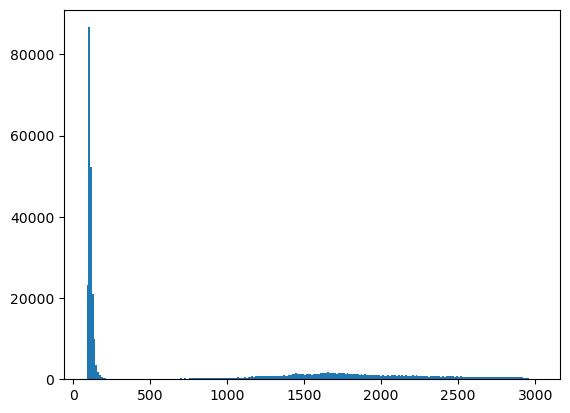

In [6]:
plt.imshow(l_img[0], cmap="gray")
plt.colorbar()
plt.show()

plt.hist(l_img[0].flatten(), bins = 255)
plt.show()

# Preprocessing des images

## Dilatation des histogrammes

In [7]:
def stretch(img):
    mini = np.min(img)
    maxi = np.max(img)
    return (255*((img-mini)/(maxi-mini)))

In [8]:
l_img_stretched = []

for img in l_img :
    l_img_stretched.append(stretch(img).astype(int).copy())

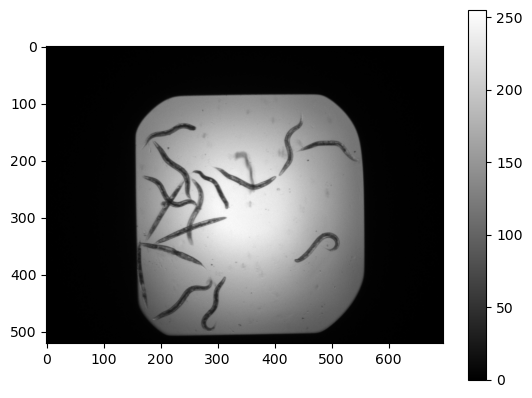

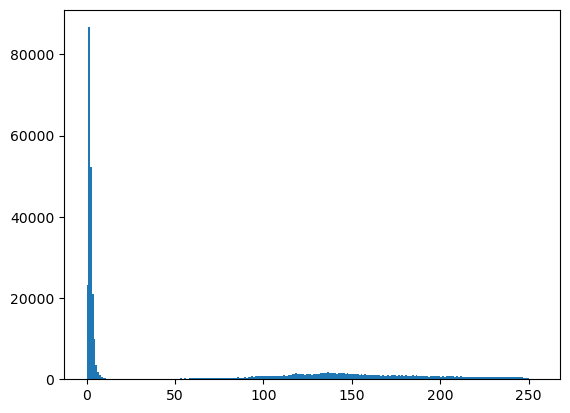

In [9]:
plt.imshow(l_img_stretched[0], cmap="gray", vmin = 0, vmax = 255)
plt.colorbar()
plt.show()
plt.hist(l_img_stretched[0].flatten(), bins = 255)
plt.show()

# Seuillage

## Seuil global

## Seuil local

In [10]:
l_img_local_thresholded = []

block_size = 51
for img in l_img_stretched:
    local_thresh = filters.threshold_local(img, block_size, offset=10)
    l_img_local_thresholded.append(img < local_thresh)


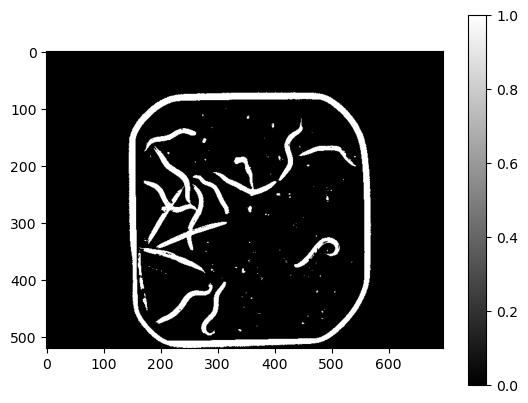

In [11]:
plt.imshow(l_img_local_thresholded[0], cmap="gray")
plt.colorbar()
plt.show()

# Supression du contour du récipiant

In [12]:
l_window = []

window_threshold = 8

for img in l_img_stretched:
    window = img>window_threshold
    l_window.append(window)

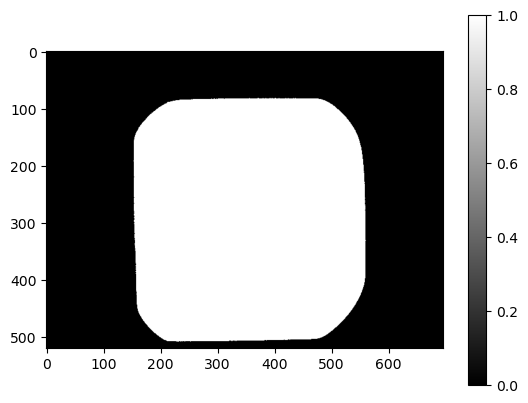

In [13]:
plt.imshow(l_window[0], cmap="gray", vmin = 0, vmax = 1)
plt.colorbar()
plt.show()

In [14]:
l_window_countour = []

for window in  l_window :
    l_window_countour.append(stretch(filters.sobel(window))>30)


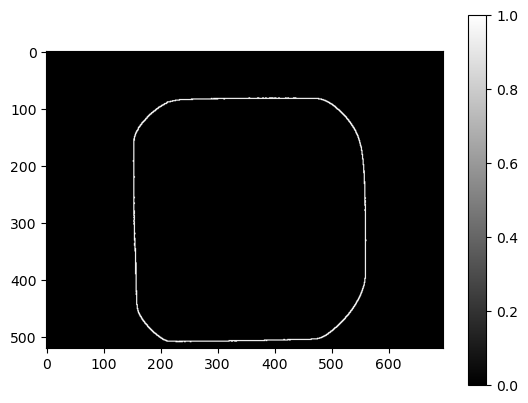

In [15]:
plt.imshow(l_window_countour[0], cmap="gray")
plt.colorbar()
plt.show()

In [16]:
l_wide_window_negative_countour = []

width = 21

for negative_countour in l_window_countour:
    l_wide_window_negative_countour.append(signal.convolve2d(negative_countour,np.ones((width,width)),mode='same')==0)


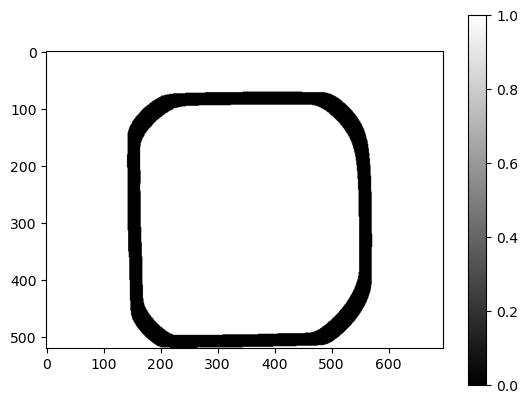

In [17]:
plt.imshow(l_wide_window_negative_countour[0], cmap="gray")
plt.colorbar()
plt.show()

In [18]:
l_img_local_thresholded_nematods = []

for i,img in enumerate(l_img_local_thresholded):
    l_img_local_thresholded_nematods.append(np.multiply(np.multiply(img, l_wide_window_negative_countour[i]),l_window[i]))

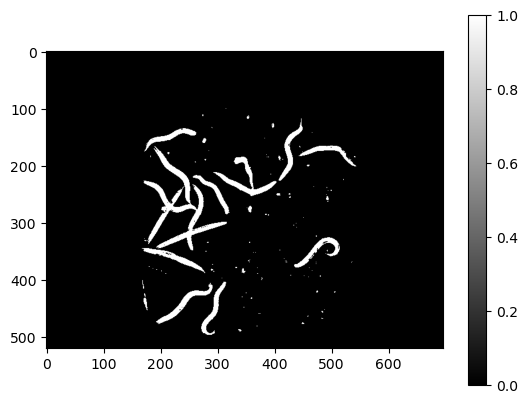

In [19]:
plt.imshow(l_img_local_thresholded_nematods[0], cmap="gray")
plt.colorbar()
plt.show()

# Opérations Morphologiques

In [20]:
def erosion(bin_img,structuring_element = np.array([[0,1,0],[1,1,1],[0,1,0]]).astype(int)):
    n,p = bin_img.shape
    ero_img = bin_img.copy()
    a,_ = structuring_element.shape
    if a%2==0:
        return "impossible"
    for i in range(a,n-a):
        for j in range(a,p-a):
            extract_img = bin_img[i-a//2:i+a//2+1,j-a//2:j+a//2+1]
            if np.sum(structuring_element * extract_img) < np.sum(structuring_element) :
                ero_img[i,j] = 0
            else :
                ero_img[i,j] = 1
    return ero_img


In [21]:
def dilatation(bin_img,structuring_element = np.array([[0,1,0],[1,1,1],[0,1,0]]).astype(int)):
    n,p = bin_img.shape
    dil_img = bin_img.copy()
    a,_ = structuring_element.shape
    if a%2==0:
        return "impossible"
    for i in range(a,n-a):
        for j in range(a,p-a):
            extract_img = bin_img[i-a//2:i+a//2+1,j-a//2:j+a//2+1]
            if np.sum(structuring_element * extract_img) > 0 :
                dil_img[i,j] = 1
            else :
                dil_img[i,j] = 0
    return dil_img


In [22]:
def multiple_erosions_and_dilataions(bin_img,l):
    for letter in l:
        if letter=='e':
            bin_img = erosion(bin_img).copy()
        elif letter=='d':
            bin_img = dilatation(bin_img).copy()
    return bin_img

In [23]:
l_img_morph = []

for img in l_img_local_thresholded_nematods:
    l_img_morph.append(multiple_erosions_and_dilataions(img,['d','d','e','e']))

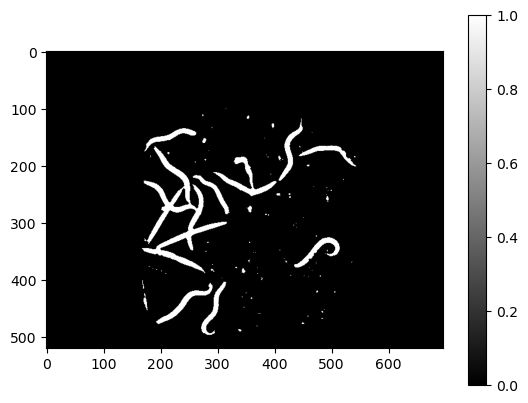

In [24]:
plt.imshow(l_img_morph[0], cmap="gray")
plt.colorbar()
plt.show()

# Enlever les trous restant

In [25]:
l_img_morph_fill = []

for img in l_img_morph:
    l_img_morph_fill.append(filters.median(img))

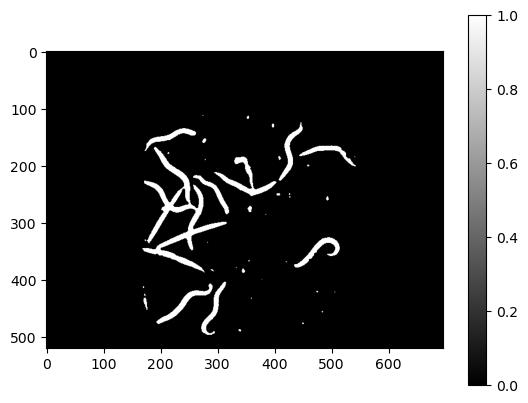

In [26]:
plt.imshow(l_img_morph_fill[0], cmap="gray")
plt.colorbar()
plt.show()

# Squelettisation 

In [27]:
l_skeleton = []

for img in l_img_morph_fill:
    l_skeleton.append(skeletonize(img))

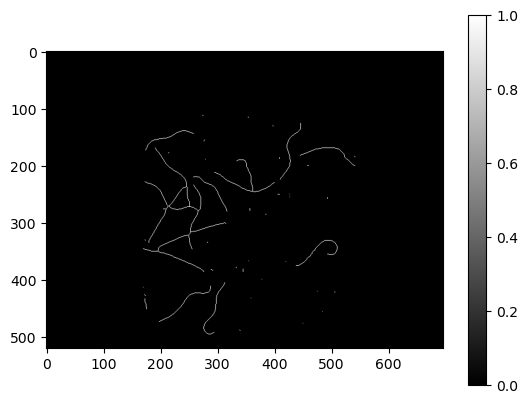

In [28]:
plt.imshow(l_skeleton[0], cmap="gray")
plt.colorbar()
plt.show()

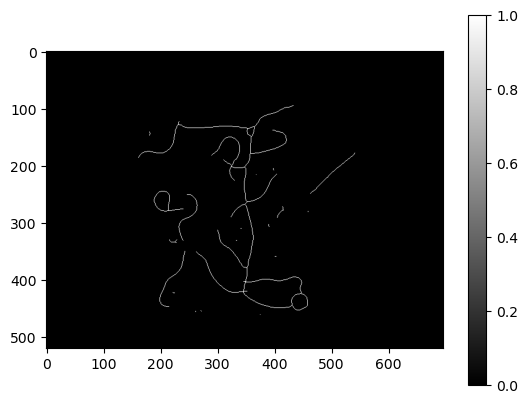

In [29]:
plt.imshow(l_skeleton[12], cmap="gray")
plt.colorbar()
plt.show()

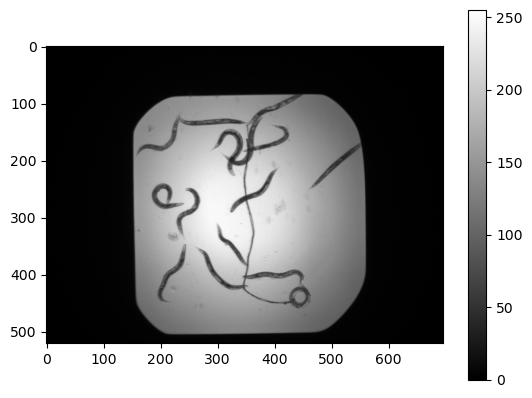

In [30]:
plt.imshow(l_img_stretched[12], cmap="gray")
plt.colorbar()
plt.show()

# Labélisation des nématodes

## Graphe de connectivité des pixels des squelettes

In [31]:
def adjacency_matrix(image):
    n = len(image)
    m = len(image[0])

    G = nx.Graph()
    for i in range (0, n):
        for j in range (0,m):
            voisins = [(i,j-1), (i, j+1), (i-1, j), (i+1, j), (i+1,j+1), (i+1, j-1), (i-1, j-1), (i-1, j+1)]
            voisins = list(map(lambda x : x if ((0 <= x[0] < n) and ( 0 <= x[1] < m)) else None , voisins))
            adjacence = list(map(lambda x : (image[i][j] and image[x[0]][x[1]]) if x is not None else None , voisins))

            for k in range(len(voisins)):
                if ((voisins[k] is not None) and (adjacence[k] == True)):
                    G.add_edge((i,j),(voisins[k][0], voisins[k][1]))
          
    return G

In [32]:
l_skeleton_graph = [adjacency_matrix(skeleton) for skeleton in l_skeleton]

## Extraction des squelettes candidats

In [33]:
def all_nematods_candidates(G_connexe):
    l_end = [n for n, d in G_connexe.degree() if d == 1]
    l_end_done = []
    l_candidates = []
    for end in l_end:
        l_end_done.append(end)
        l_parcours = [end]
        current = list(G_connexe.neighbors(end))[0]

        def rec_parcours(current, l_parcours):
            if current in l_end:
                if current not in l_end_done:
                    l_parcours.append(current)
                    return l_parcours
            for neighbor in list(G_connexe.neighbors(current)):
                if neighbor in l_parcours[:-1]:
                    l_parcours.append(current)
                    return l_parcours
            
            l_parcours.append(current)
            l_neighbors = list(G_connexe.neighbors(current))
            
            return [rec_parcours(new_current, l_parcours.copy()) for new_current in l_neighbors if new_current not in l_parcours]
        
        l_candidates += rec_parcours(current, l_parcours)
    
    def flatten_l_l_tuples(object):
        res = []
        if isinstance(object, list):
            if all(isinstance(x, tuple) for x in object):
                if len(object)>0:
                    res.append(object)
            else:
                for l in object:
                    res.extend(flatten_l_l_tuples(l))
        return res

    return flatten_l_l_tuples(l_candidates)

In [34]:
l_l_skeleton_candidates = []
for i,skeleton_graph in enumerate(l_skeleton_graph):
    l_l_skeleton_candidates.append([])
    for connexe_component in list(nx.connected_components(skeleton_graph)):
        sub_skeleton_graph = skeleton_graph.subgraph(connexe_component).copy()
        l_l_skeleton_candidates[i].append(all_nematods_candidates(sub_skeleton_graph))

In [35]:
len(l_l_skeleton_candidates)

24

In [36]:
print(l_l_skeleton_candidates[1][11][0])

[(215, 151), (216, 151), (217, 151), (218, 151), (219, 151), (220, 151), (221, 151), (222, 152), (223, 152), (224, 152), (225, 152), (226, 152), (227, 152), (228, 152), (229, 152), (230, 153), (231, 153), (232, 153), (233, 153), (234, 153), (235, 154), (236, 154), (237, 154), (238, 154), (239, 154), (240, 155), (241, 155), (242, 155), (243, 155), (244, 155), (245, 155), (246, 155), (247, 155), (248, 155), (249, 156), (250, 156), (251, 157), (252, 157), (253, 157), (254, 157), (255, 157), (256, 157), (257, 157), (258, 157), (259, 157), (260, 157), (261, 158), (262, 158), (263, 158), (264, 158), (265, 158), (266, 158), (267, 159), (268, 159), (269, 159), (270, 159), (271, 159), (272, 159), (273, 160), (274, 160), (275, 160), (276, 160), (277, 160), (278, 160), (279, 160), (280, 160), (281, 160), (282, 160), (283, 160), (284, 160), (285, 160), (286, 160), (287, 160), (288, 161), (289, 161), (290, 161), (291, 161), (292, 161), (293, 161), (294, 161), (295, 161), (296, 161), (297, 160), (29

### Exemple

In [37]:
i = 1 # numéro de l'image
j = 11 # numéro du candidat

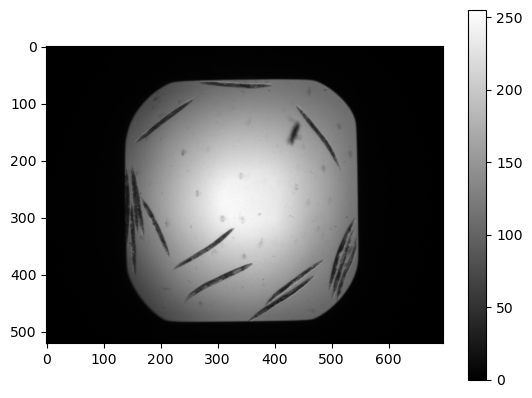

In [38]:
plt.imshow(l_img_stretched[i], cmap="gray")
plt.colorbar()
plt.show()

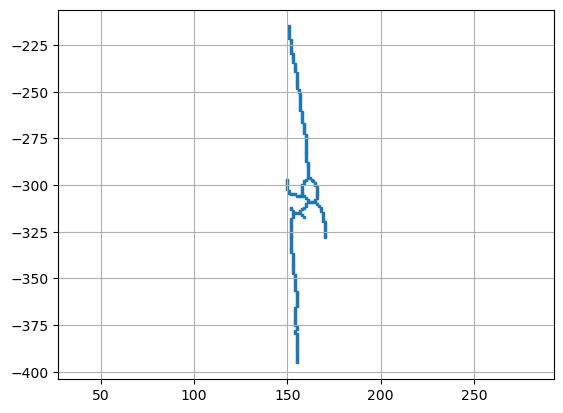

In [39]:
components = list(nx.connected_components(l_skeleton_graph[i]))
sub_skeleton_graph = l_skeleton_graph[i].subgraph(components[j]).copy()

nodes = list(sub_skeleton_graph)
x_coords = [n[1] for n in nodes]
y_coords = [-n[0] for n in nodes]

plt.scatter(x_coords, y_coords, s=1, marker='s')
plt.grid()
plt.axis("equal")
plt.show()

In [40]:
len(l_l_skeleton_candidates[i][j])

218

In [41]:
l_l_skeleton_candidates[i]

[[[(69, 309),
   (69, 310),
   (69, 311),
   (69, 312),
   (69, 313),
   (69, 314),
   (69, 315),
   (69, 316),
   (69, 317),
   (69, 318),
   (69, 319),
   (69, 320),
   (69, 321),
   (69, 322),
   (69, 323),
   (69, 324),
   (69, 325),
   (69, 326),
   (69, 327),
   (69, 328),
   (69, 329),
   (69, 330),
   (69, 331),
   (69, 332),
   (69, 333),
   (69, 334),
   (70, 335),
   (70, 336),
   (70, 337),
   (69, 338),
   (69, 339),
   (69, 340),
   (69, 341),
   (69, 342),
   (69, 343),
   (69, 344),
   (69, 345),
   (69, 346),
   (69, 347),
   (70, 348),
   (70, 349),
   (70, 350),
   (70, 351),
   (70, 352),
   (70, 353),
   (70, 354),
   (70, 355),
   (70, 356),
   (70, 357),
   (70, 358),
   (70, 359),
   (70, 360),
   (70, 361),
   (70, 362),
   (70, 363),
   (70, 364),
   (70, 365),
   (70, 366),
   (70, 367),
   (70, 368),
   (70, 369),
   (70, 370),
   (70, 371),
   (70, 372),
   (70, 373),
   (70, 374),
   (70, 375),
   (70, 376),
   (70, 377),
   (69, 378),
   (69, 379),
   (69

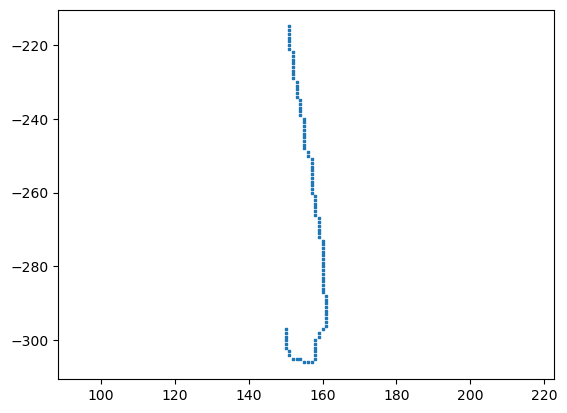

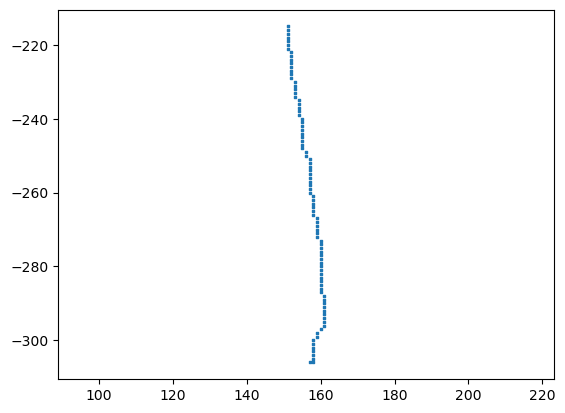

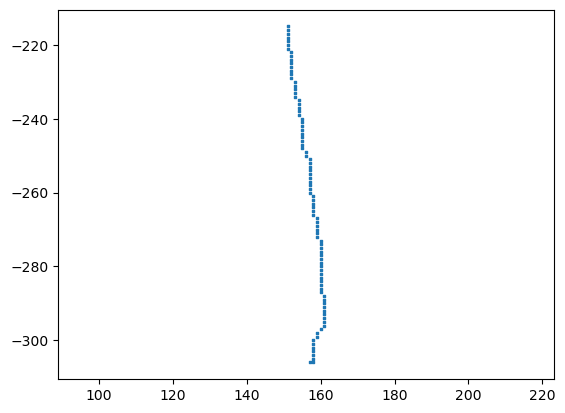

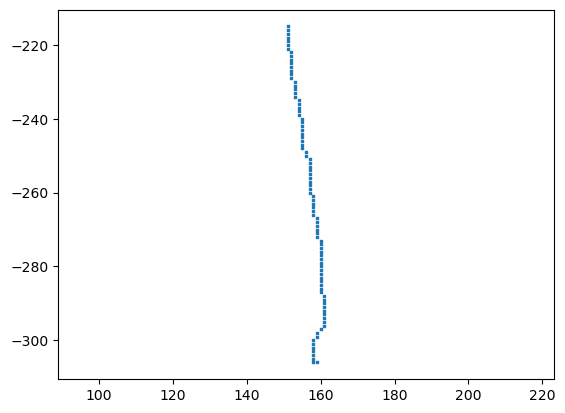

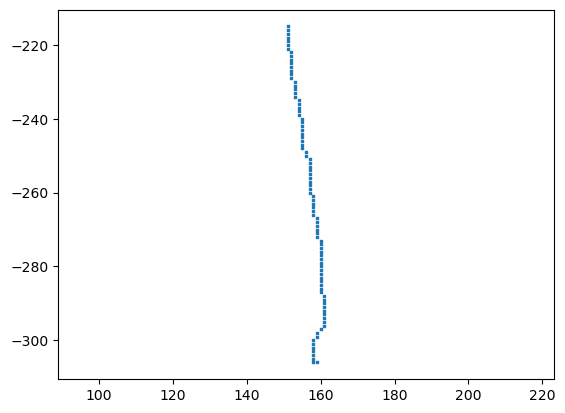

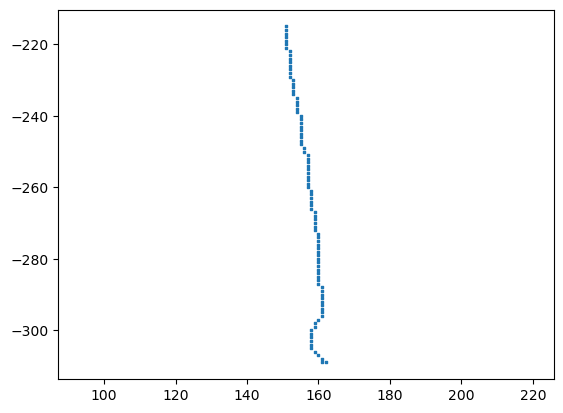

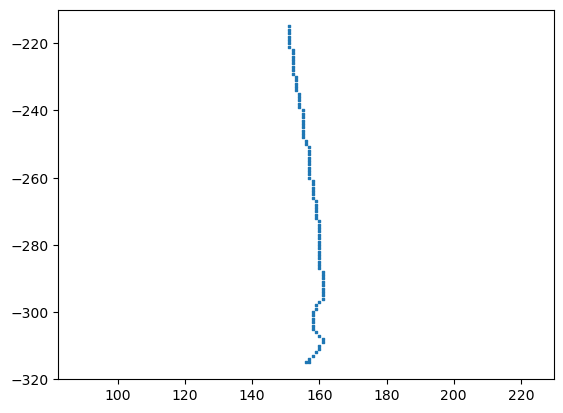

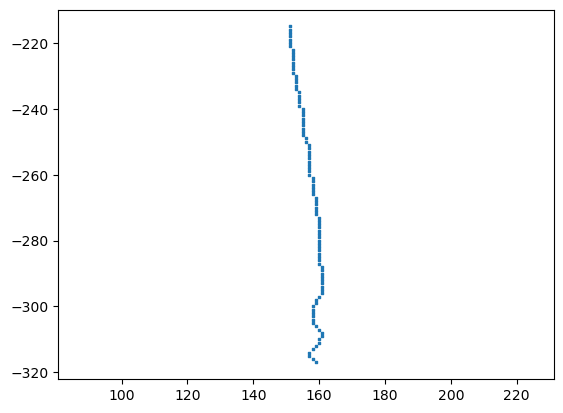

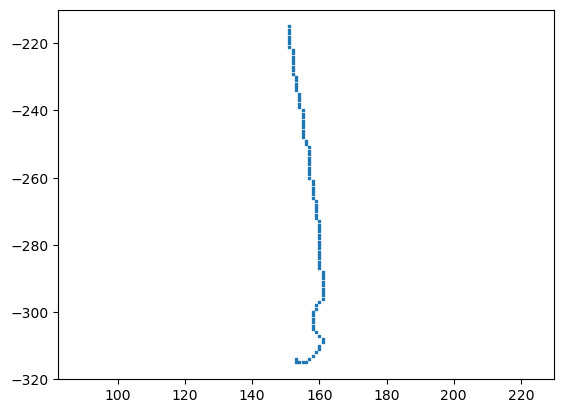

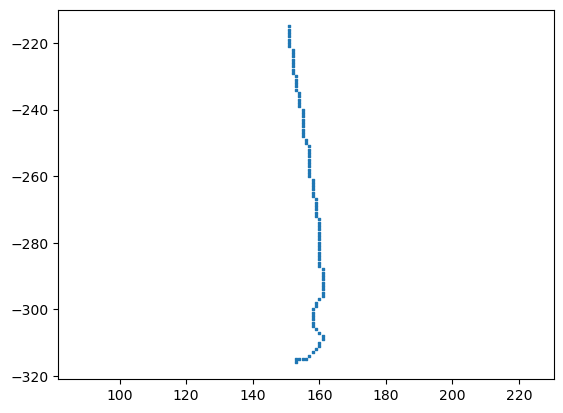

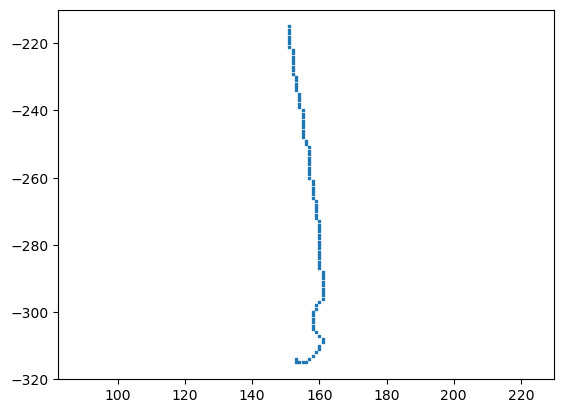

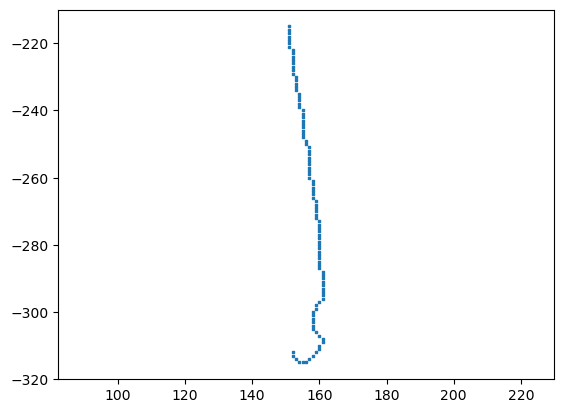

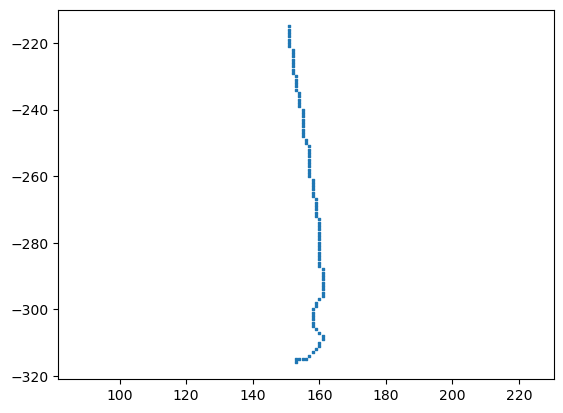

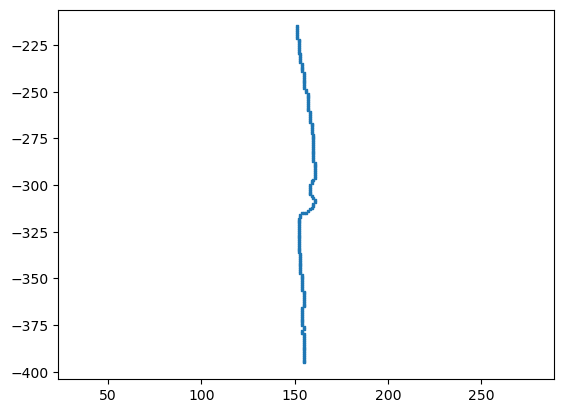

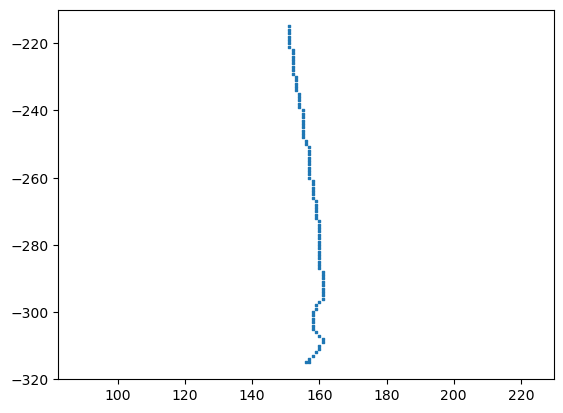

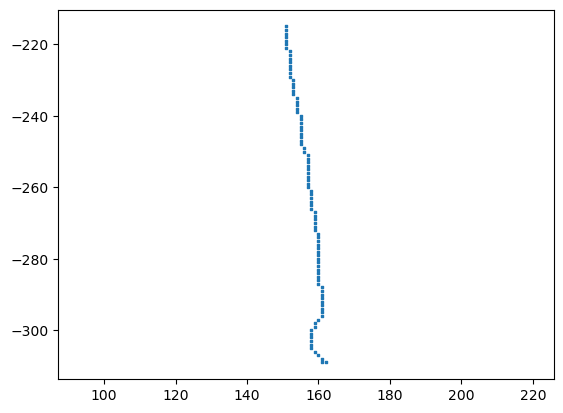

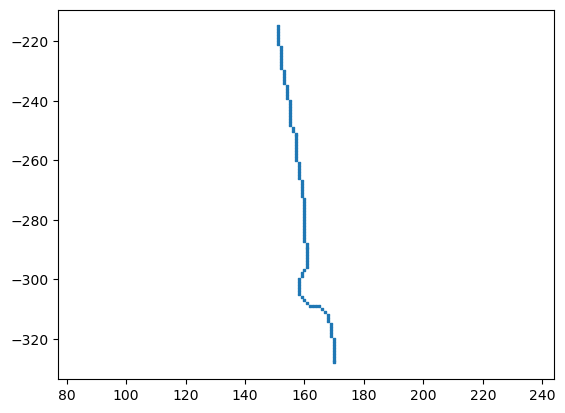

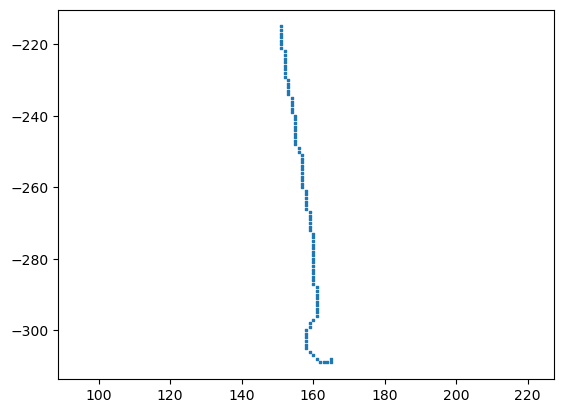

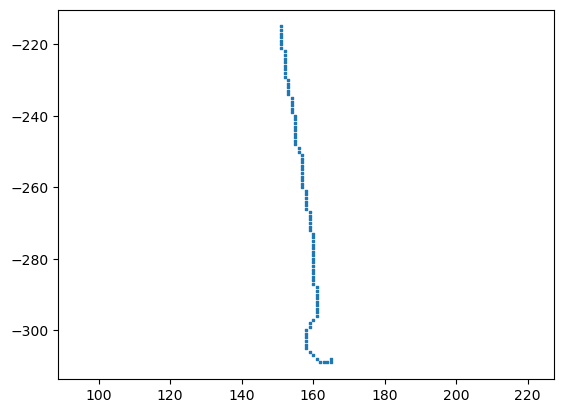

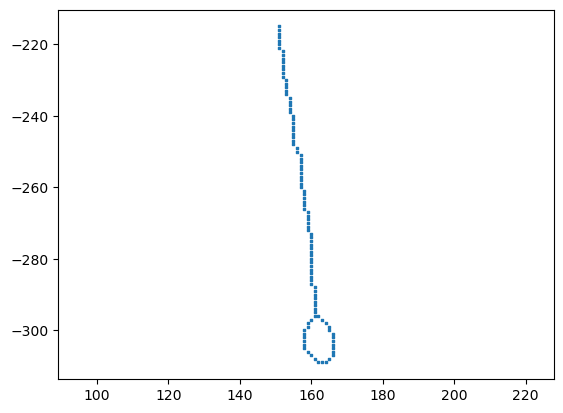

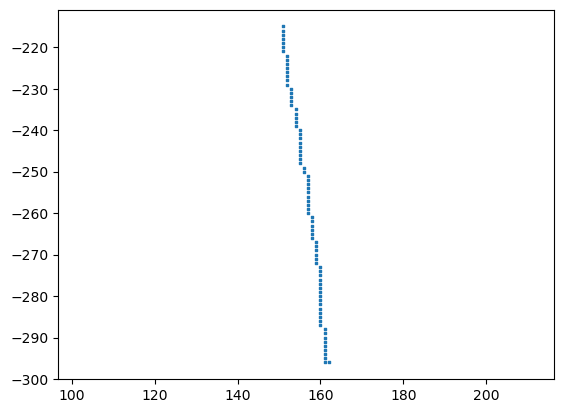

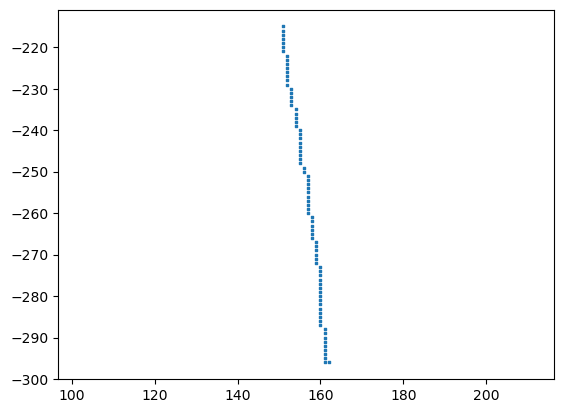

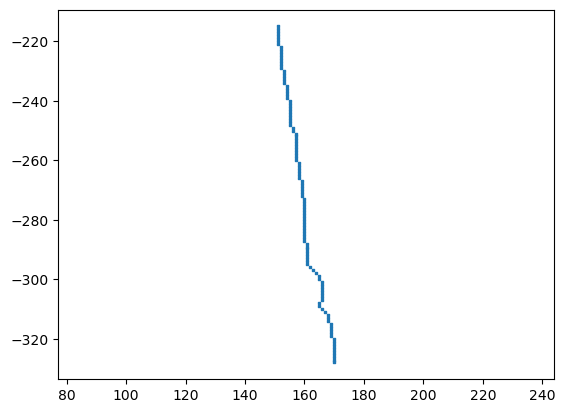

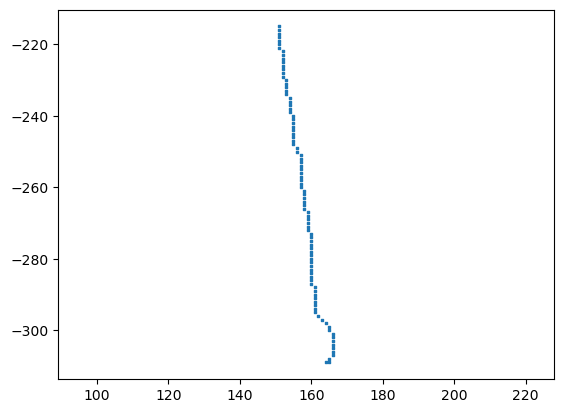

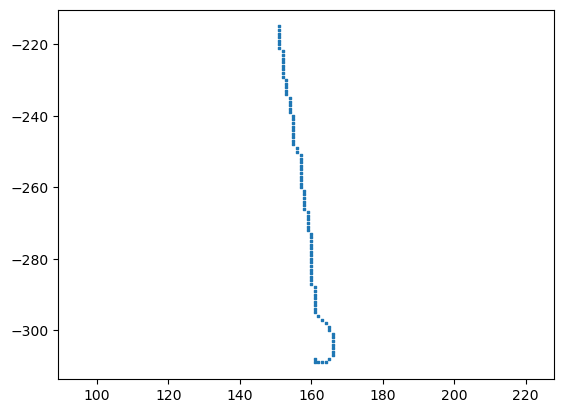

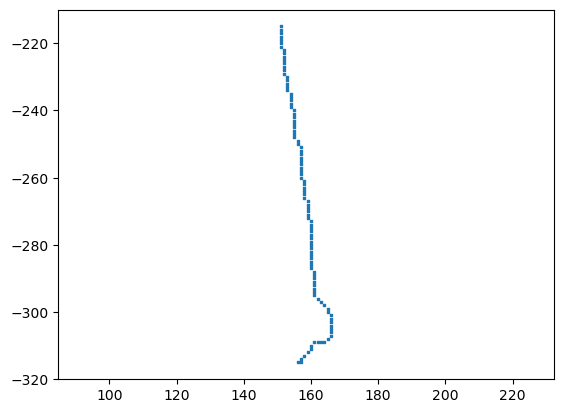

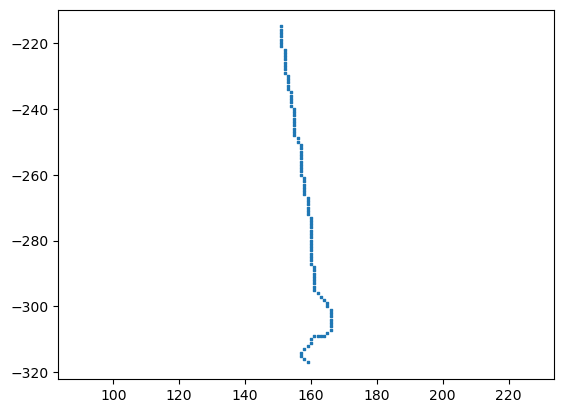

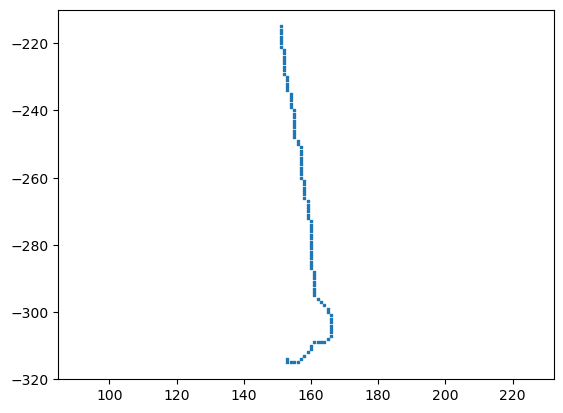

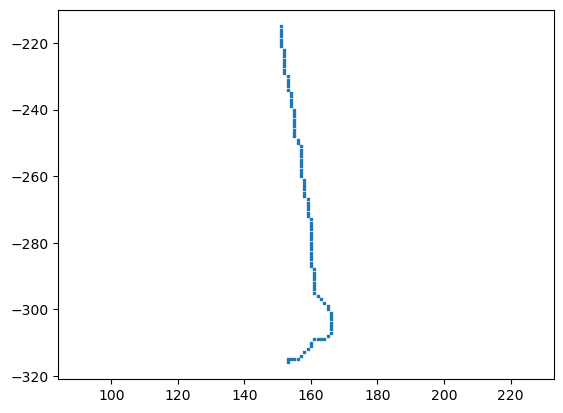

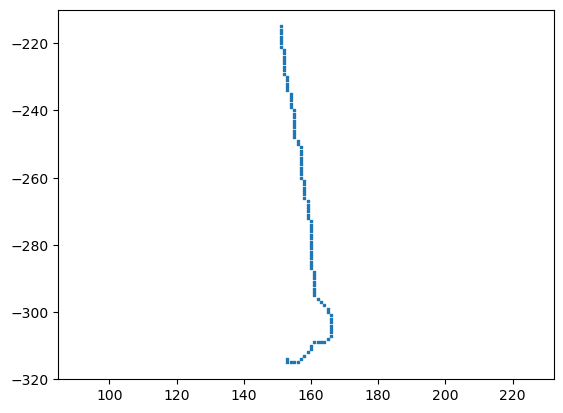

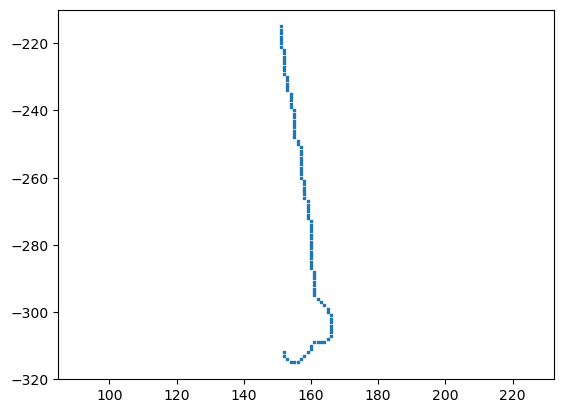

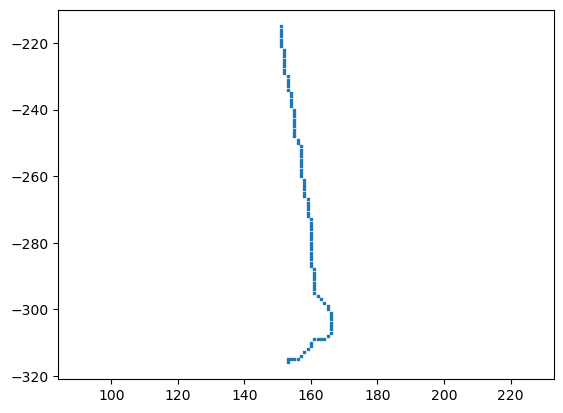

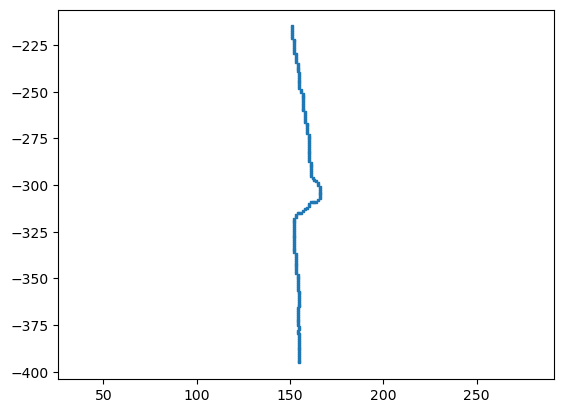

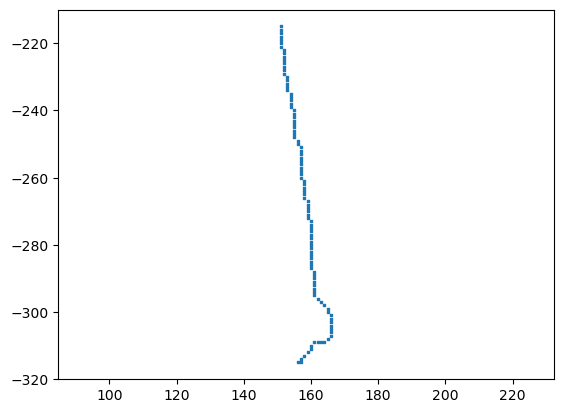

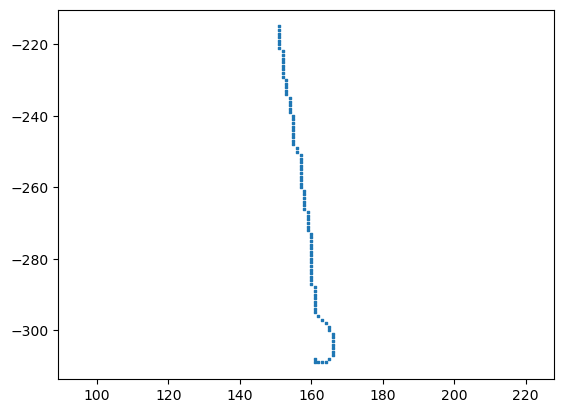

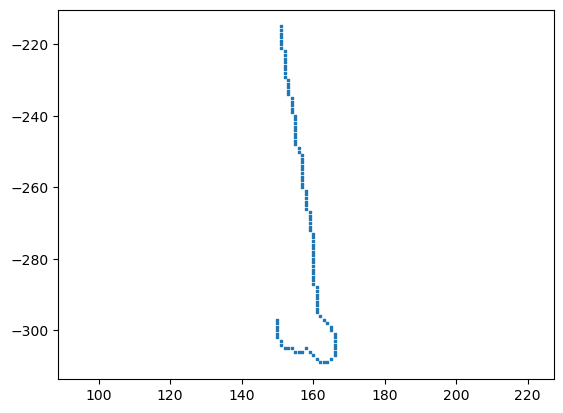

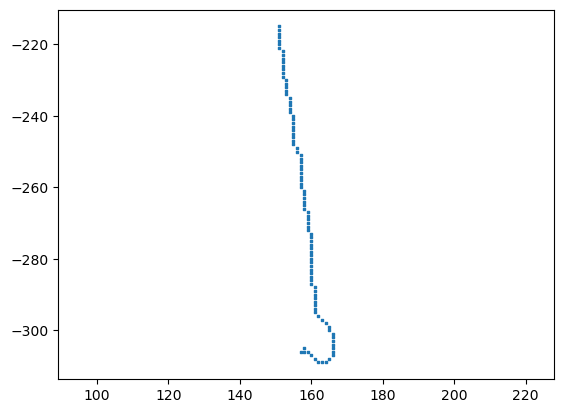

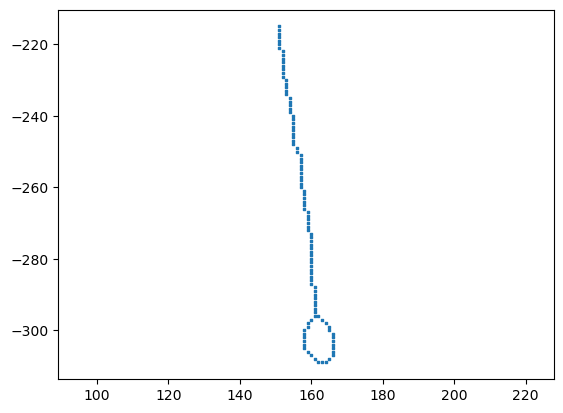

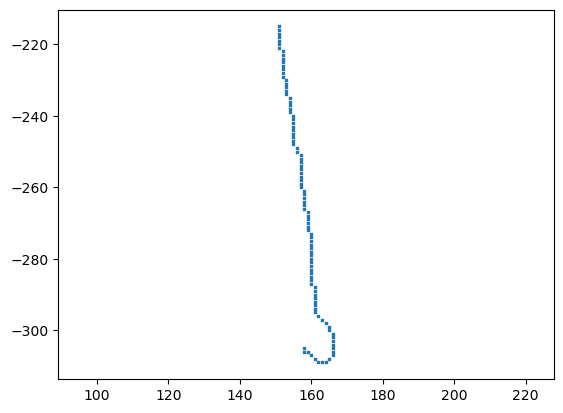

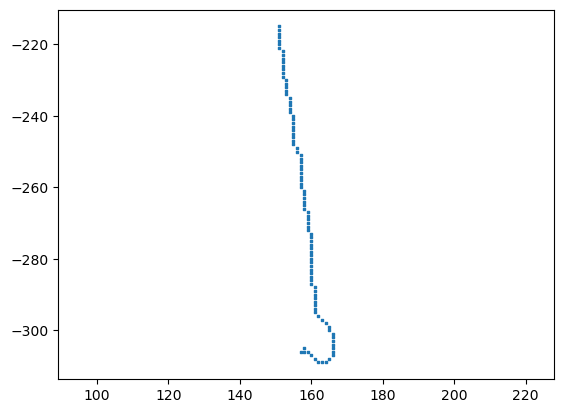

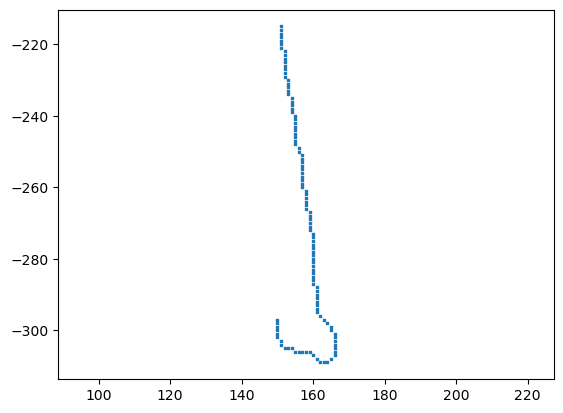

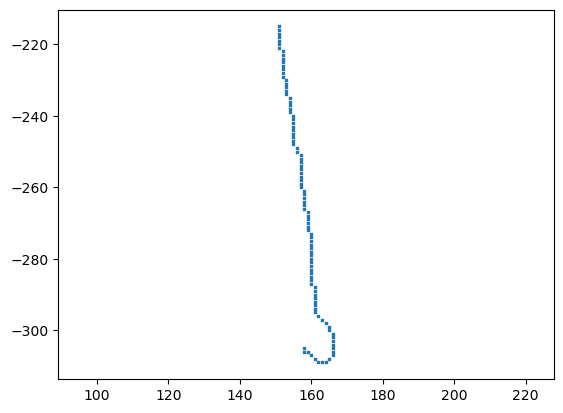

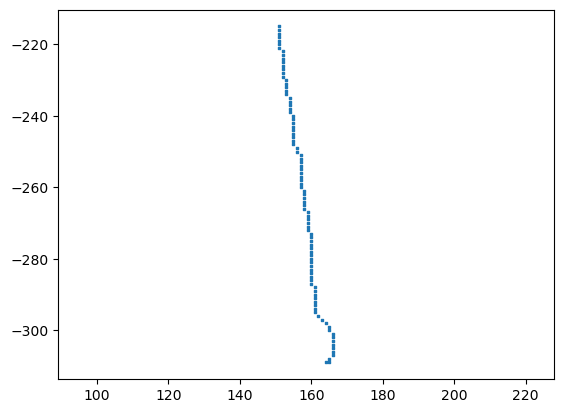

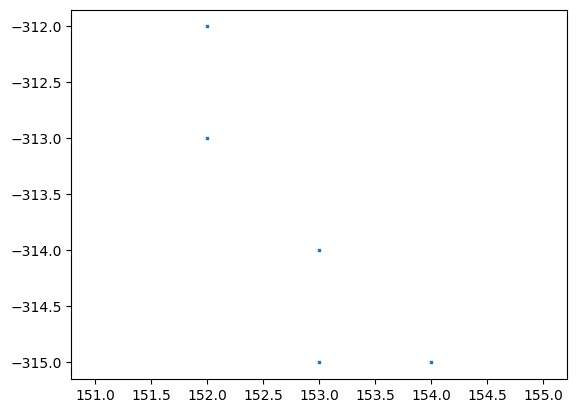

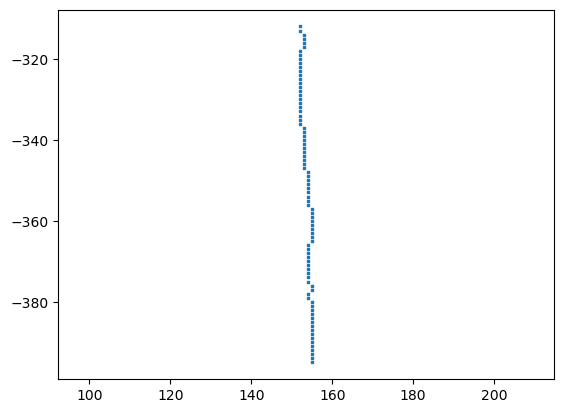

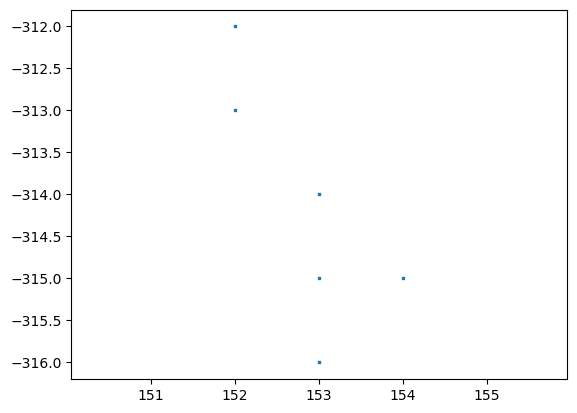

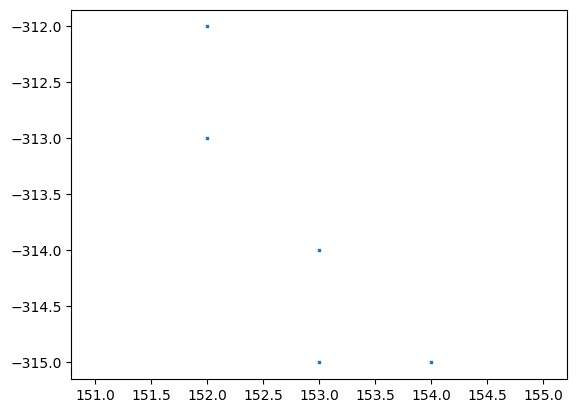

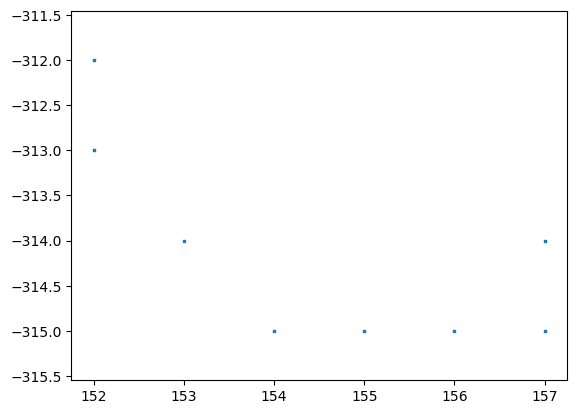

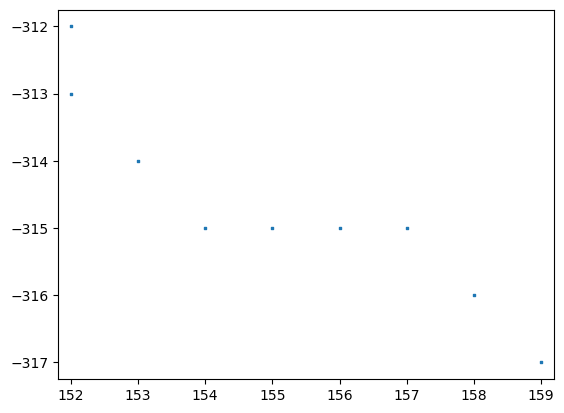

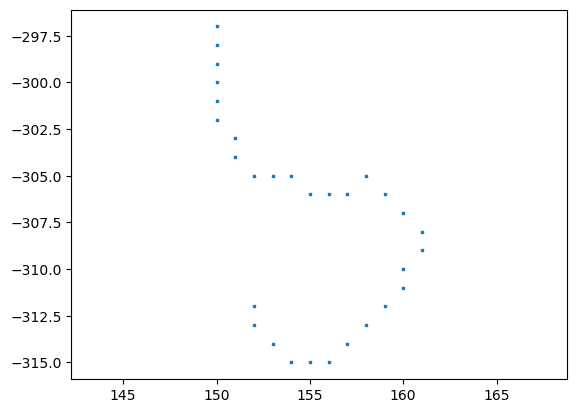

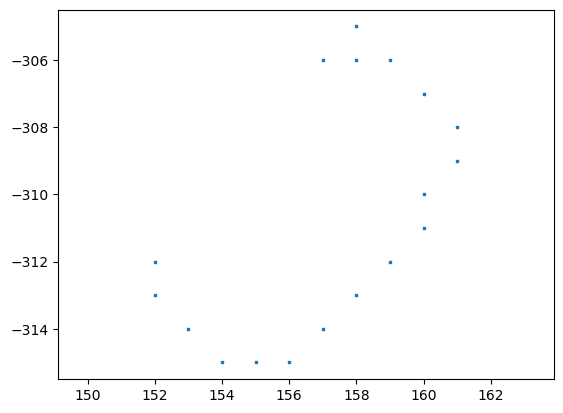

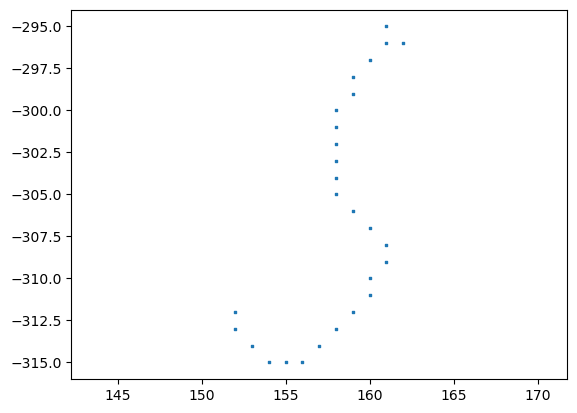

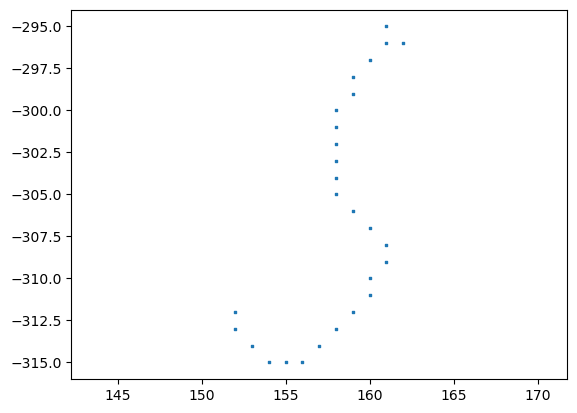

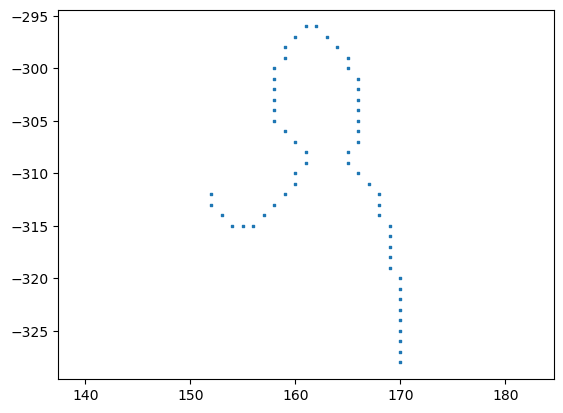

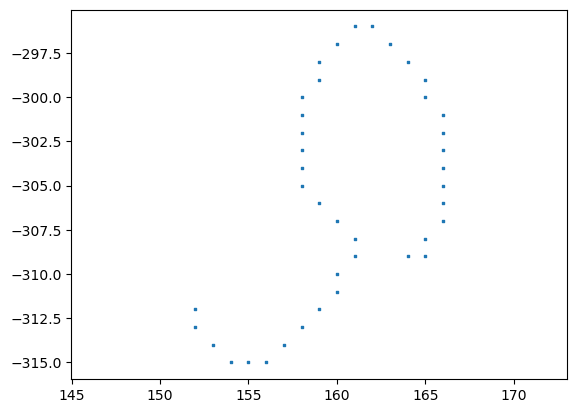

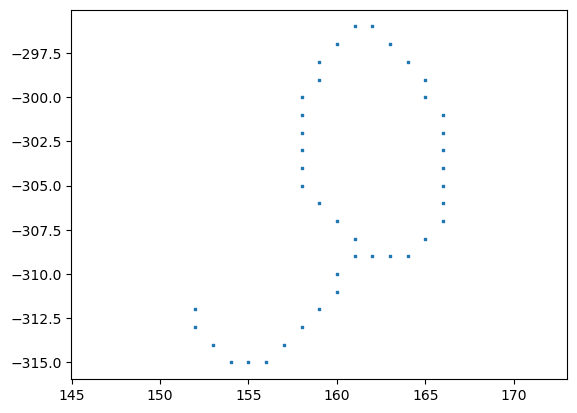

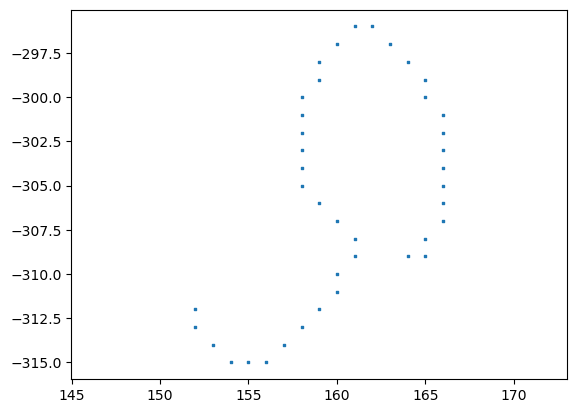

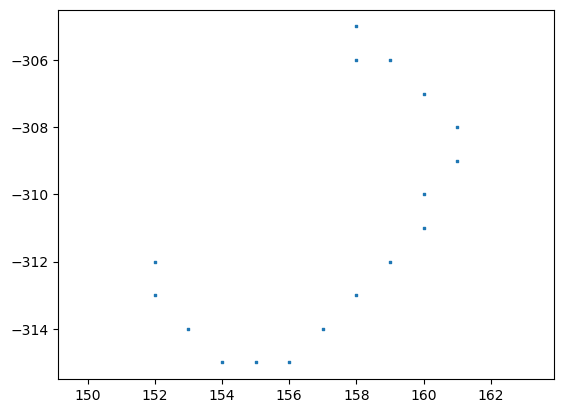

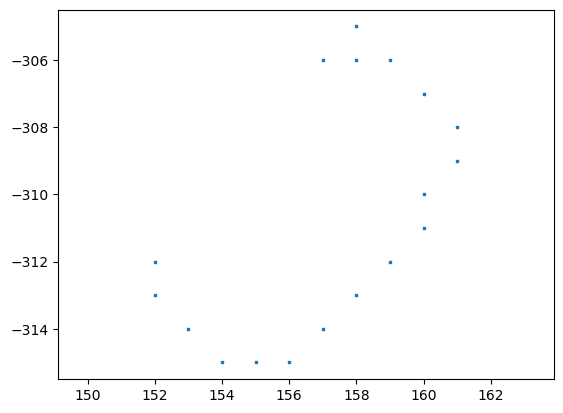

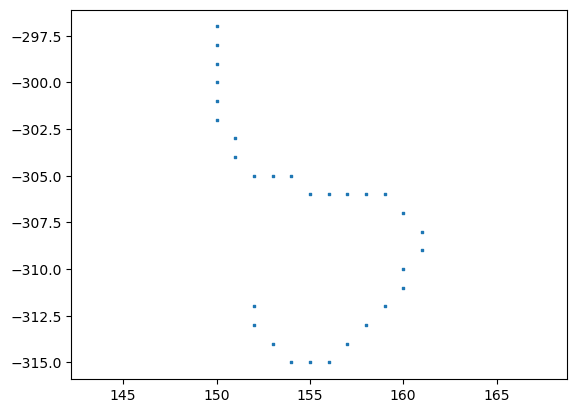

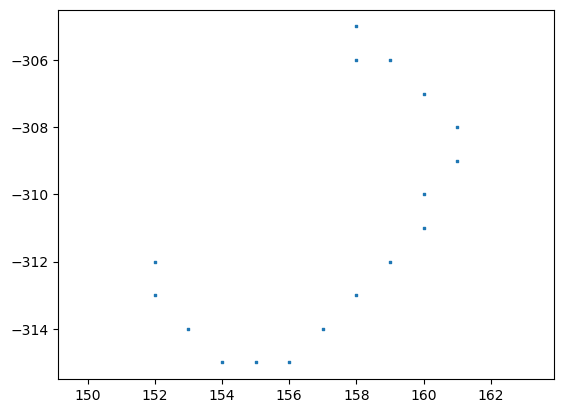

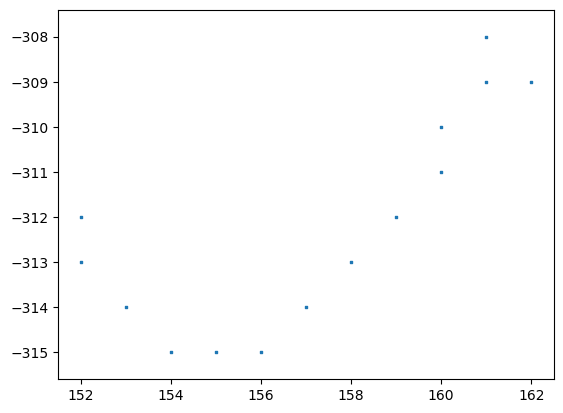

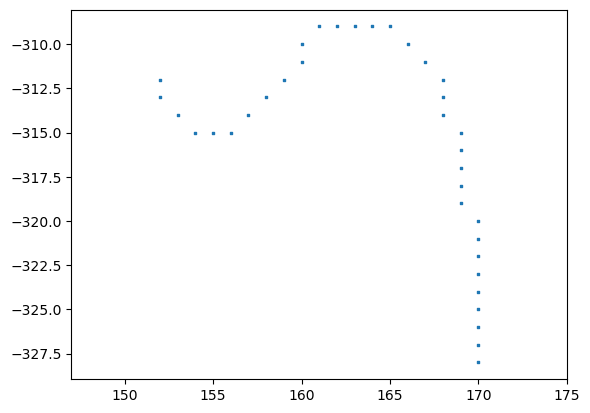

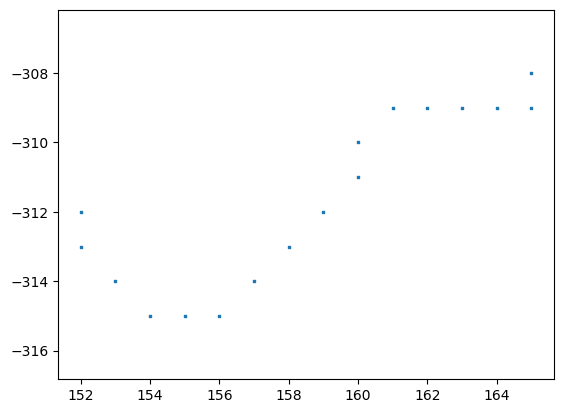

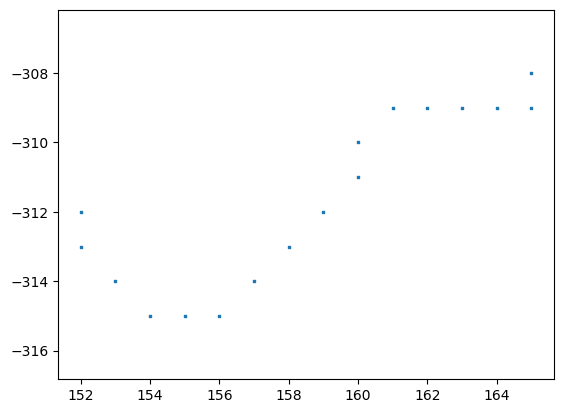

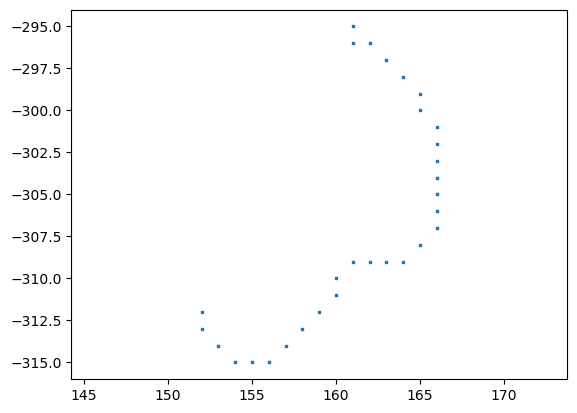

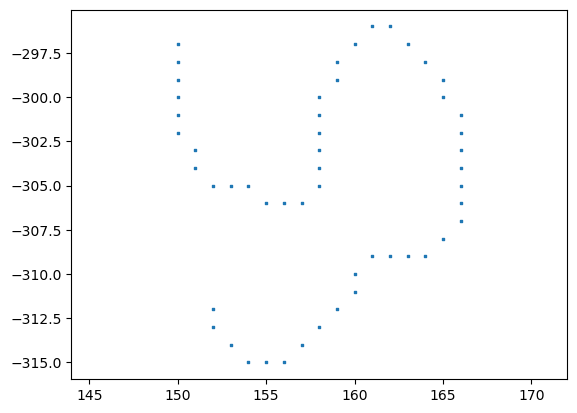

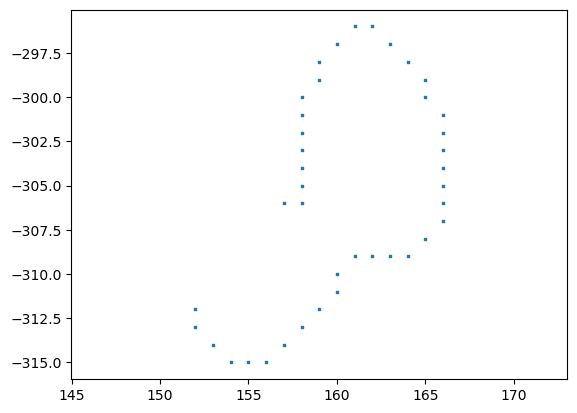

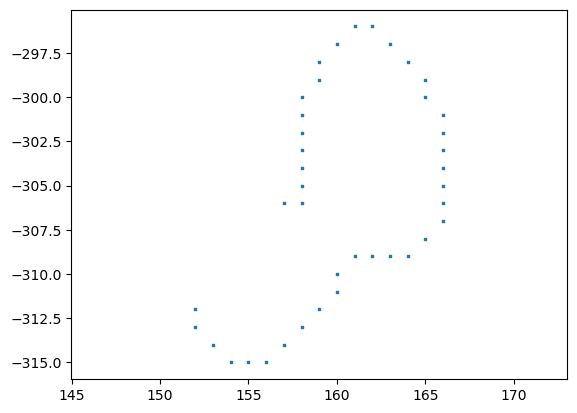

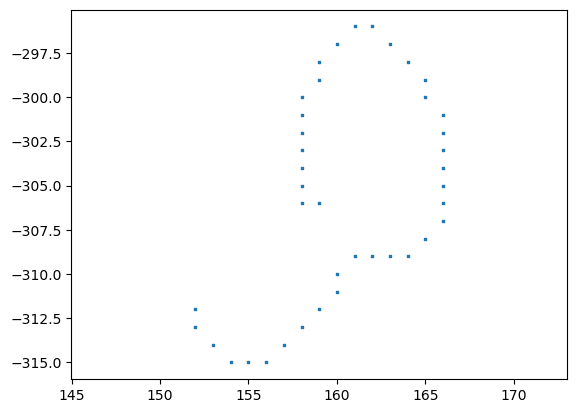

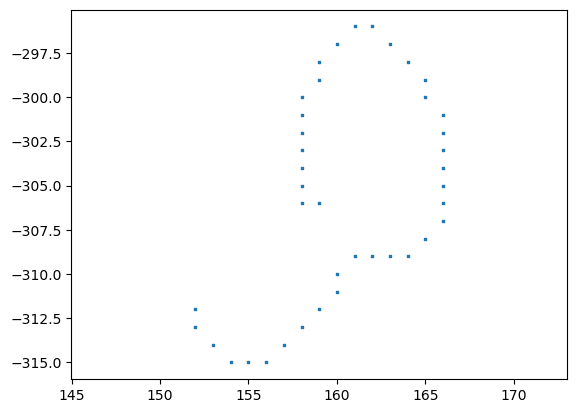

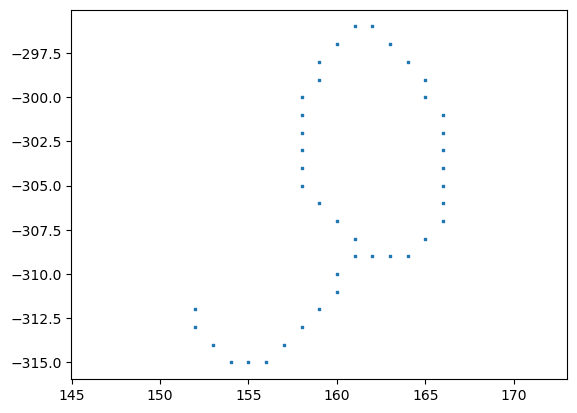

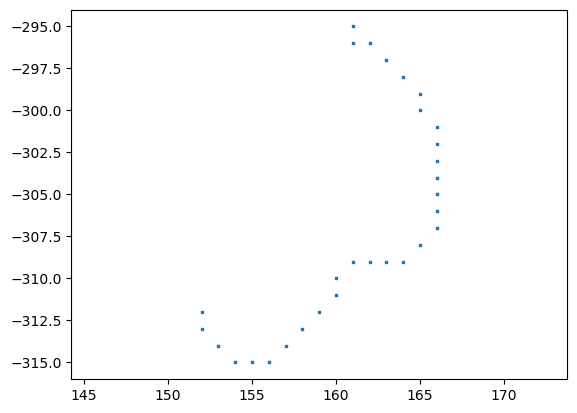

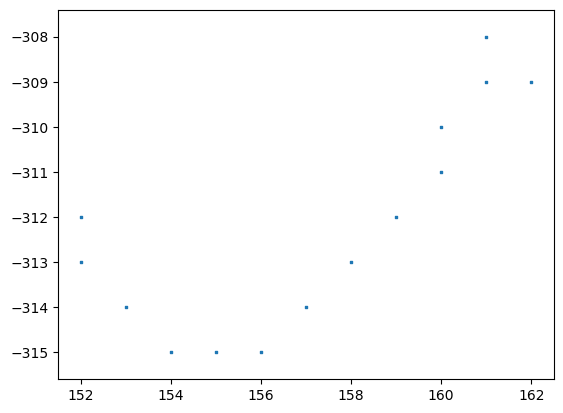

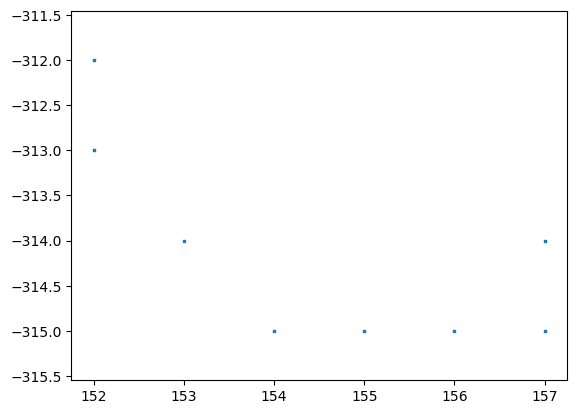

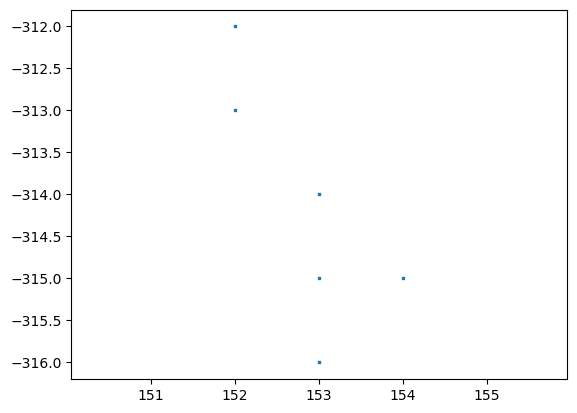

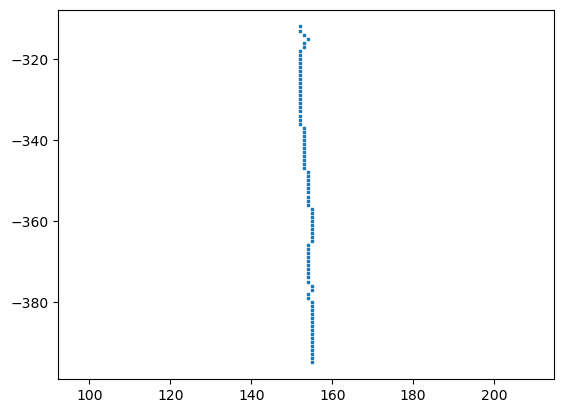

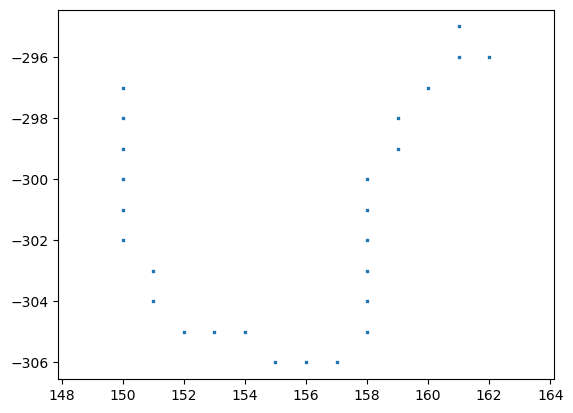

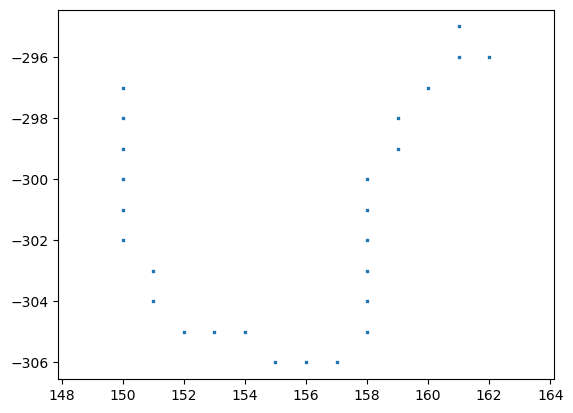

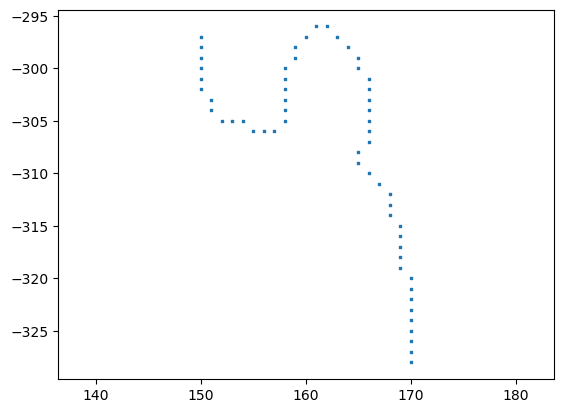

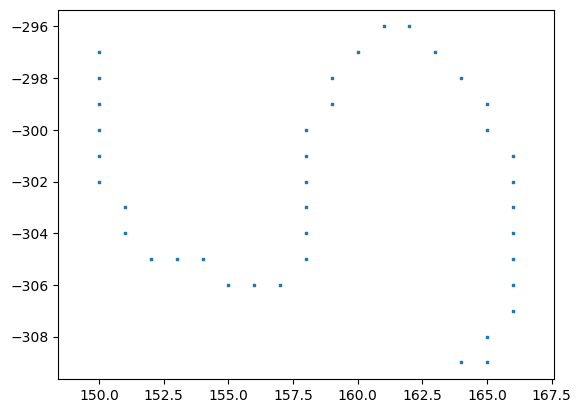

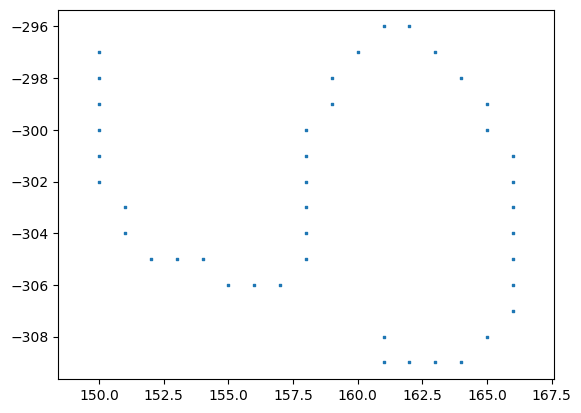

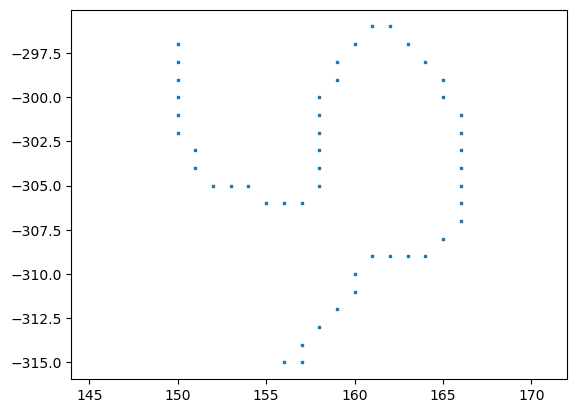

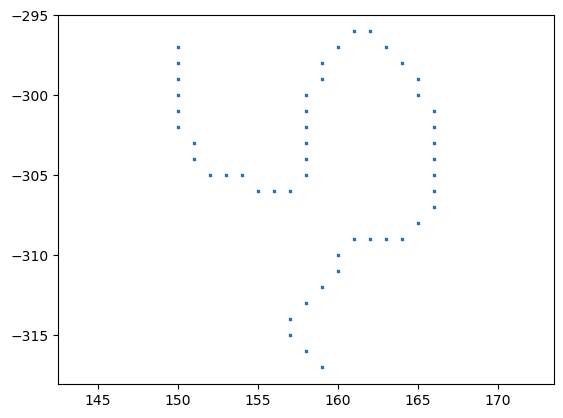

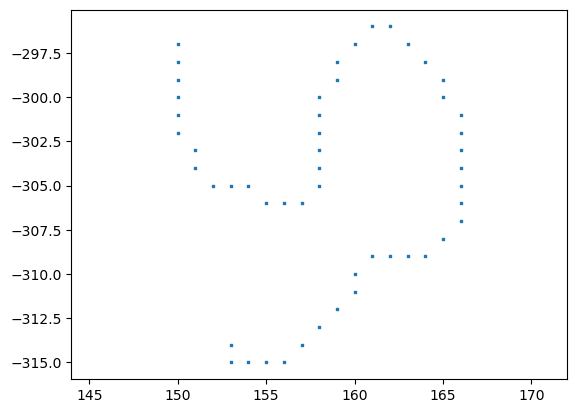

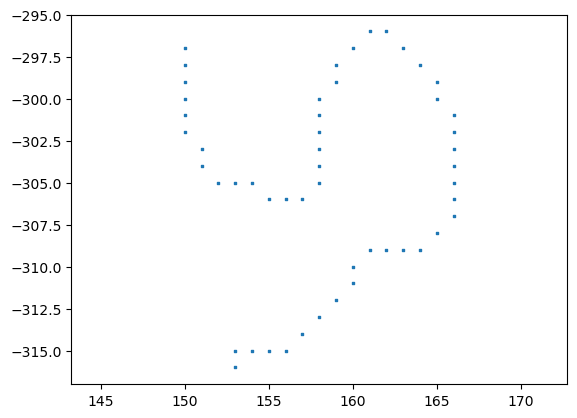

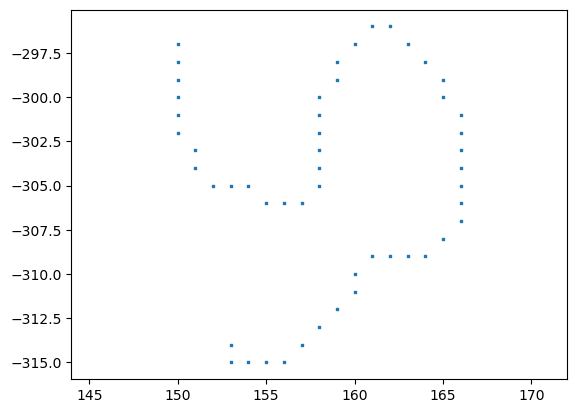

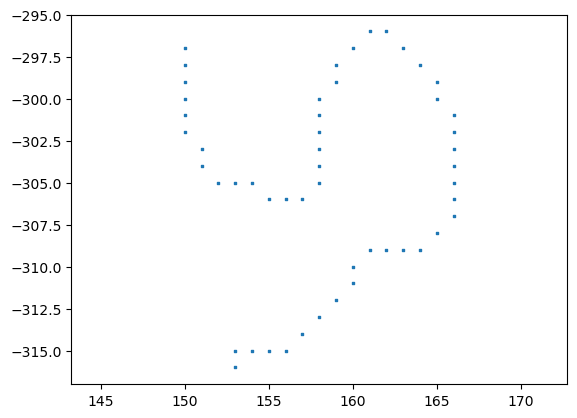

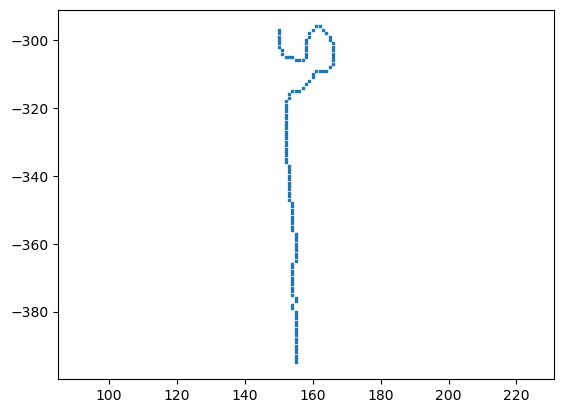

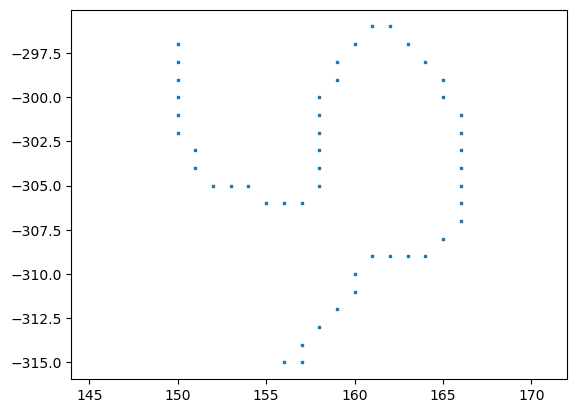

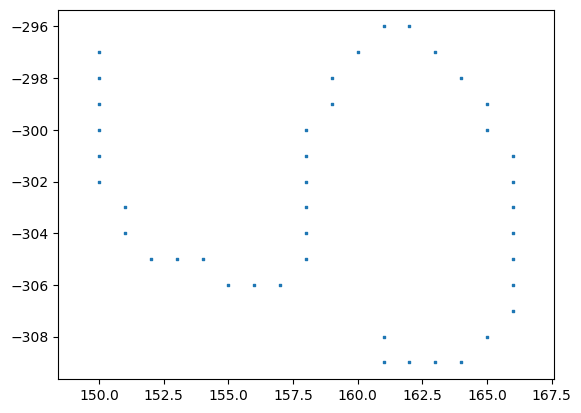

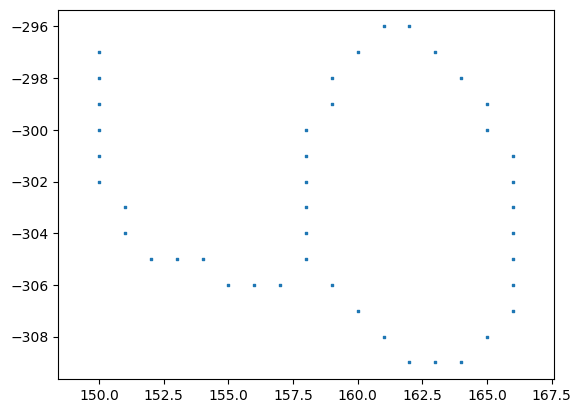

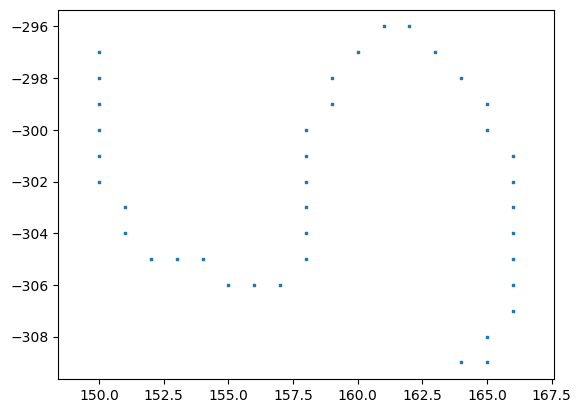

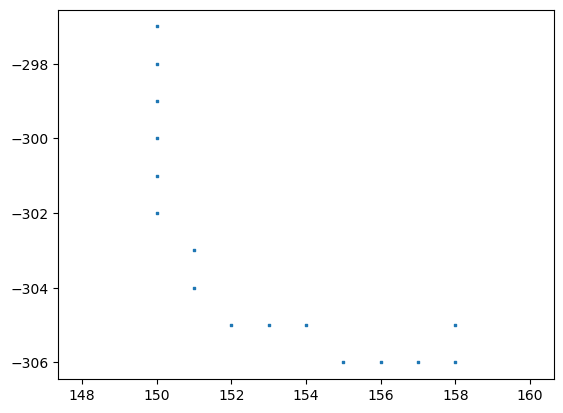

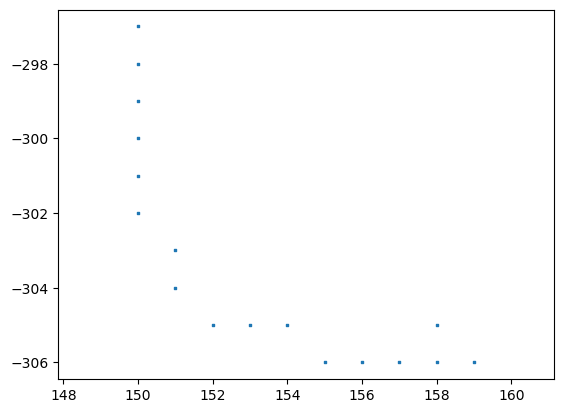

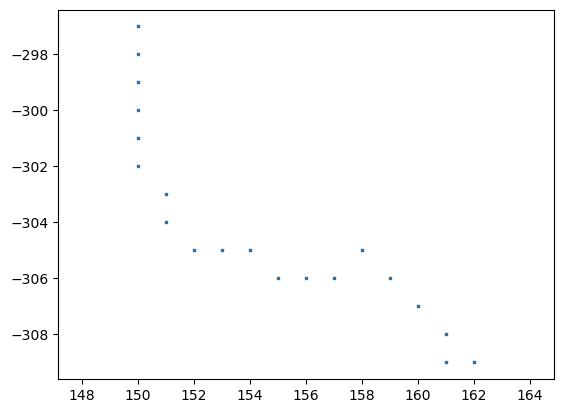

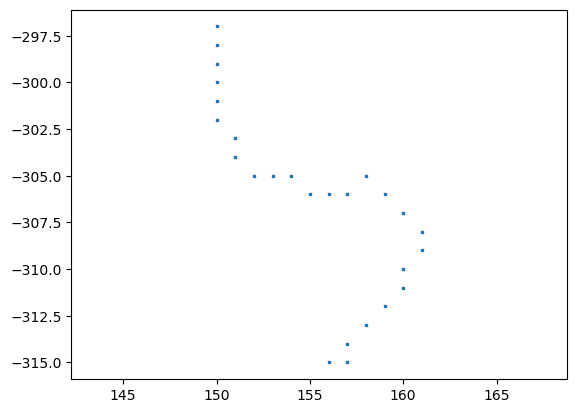

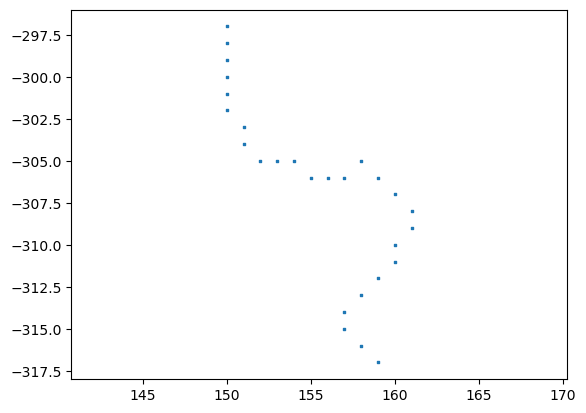

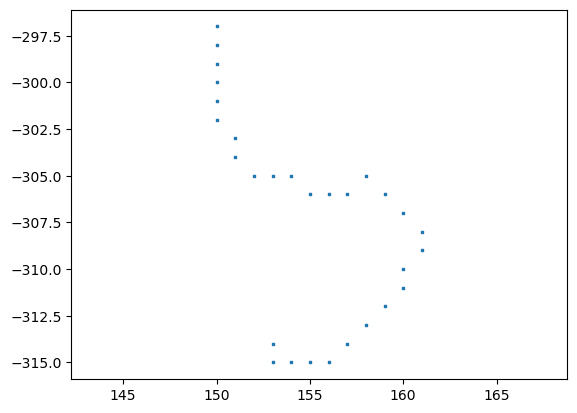

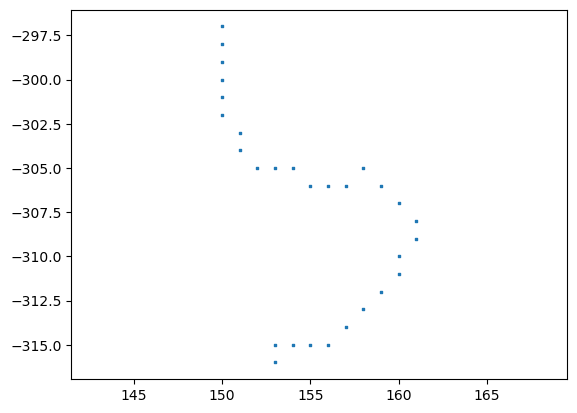

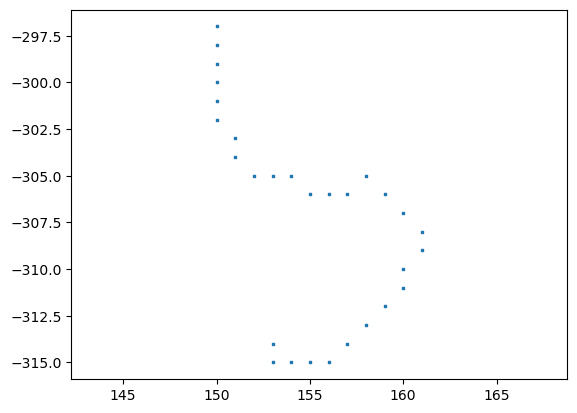

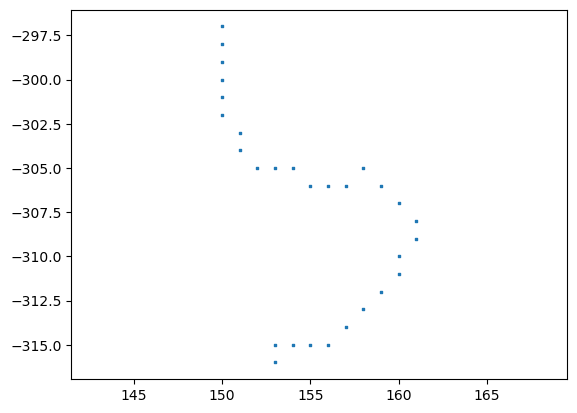

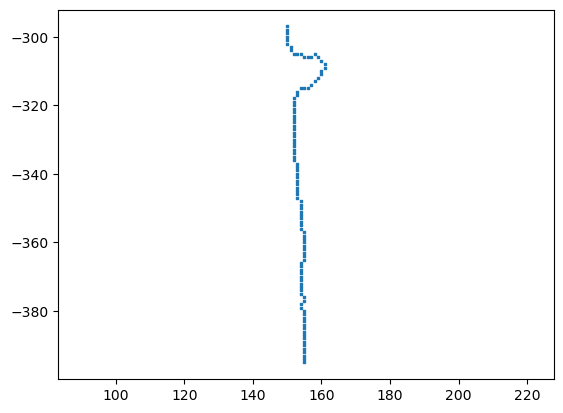

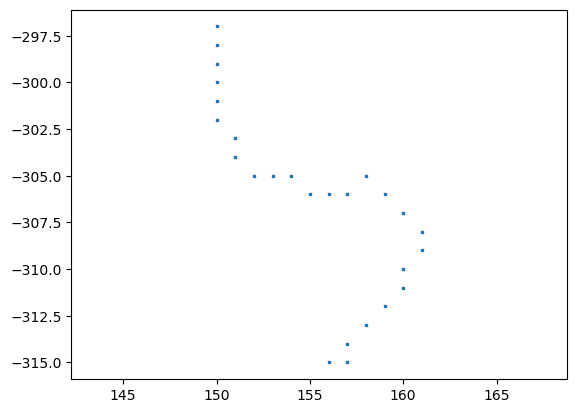

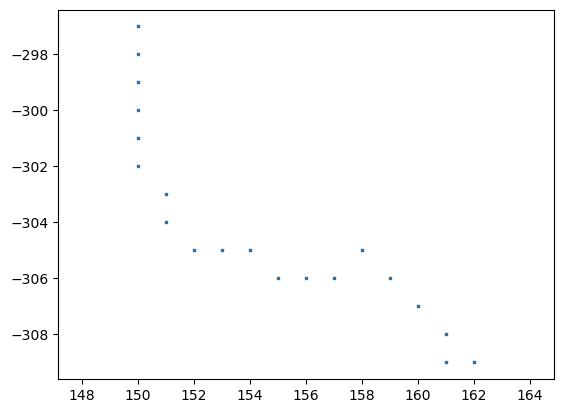

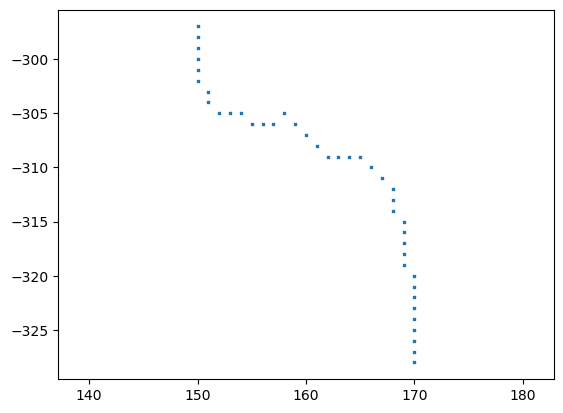

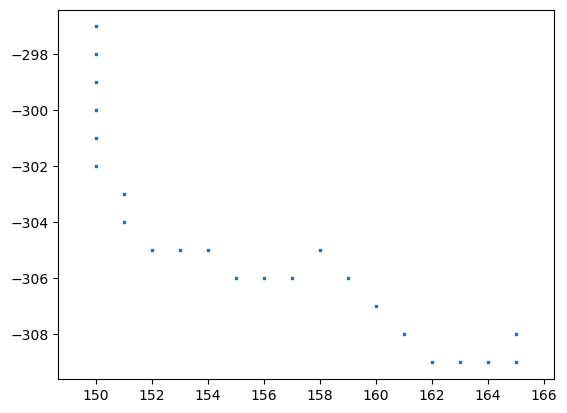

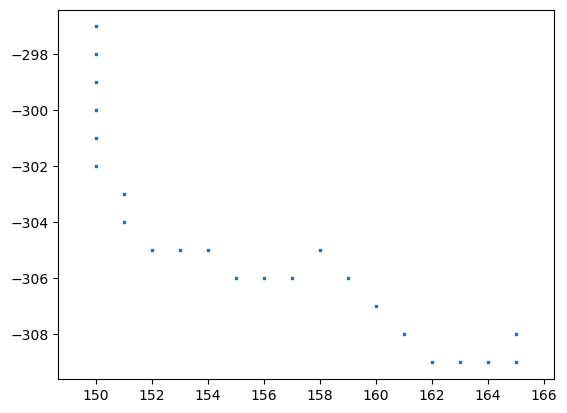

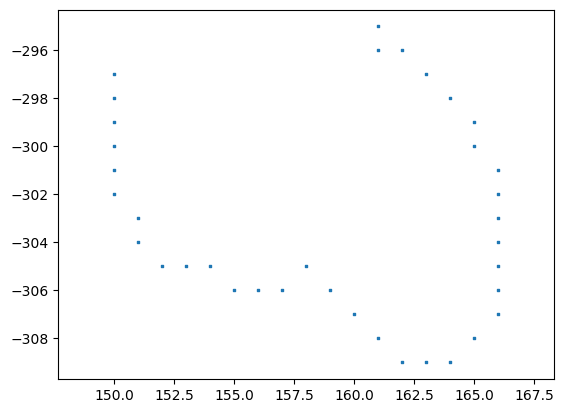

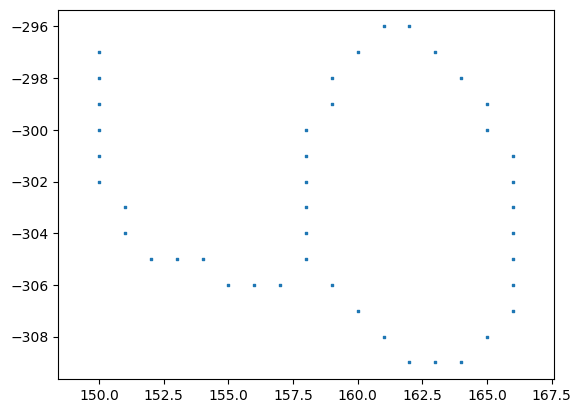

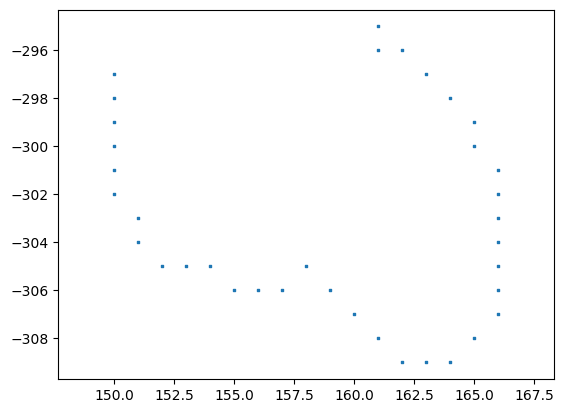

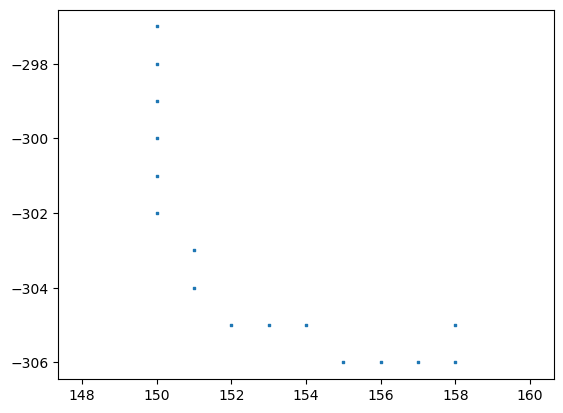

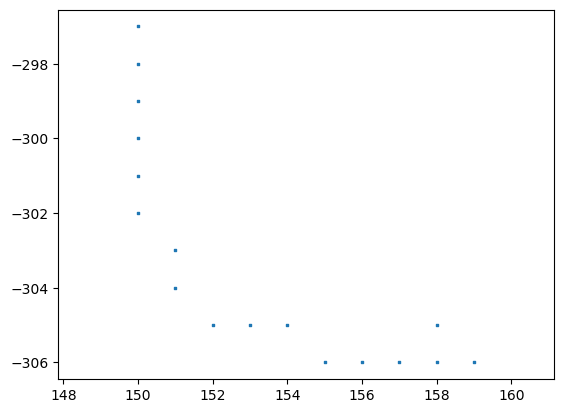

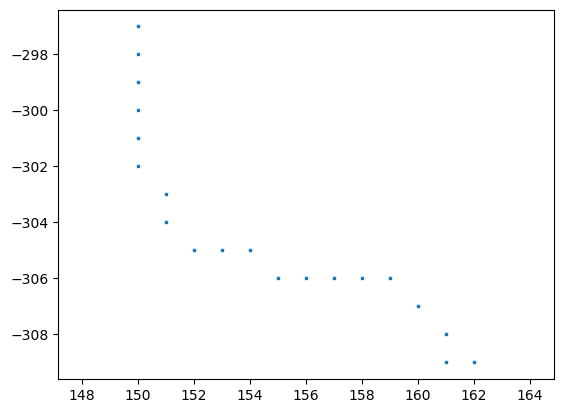

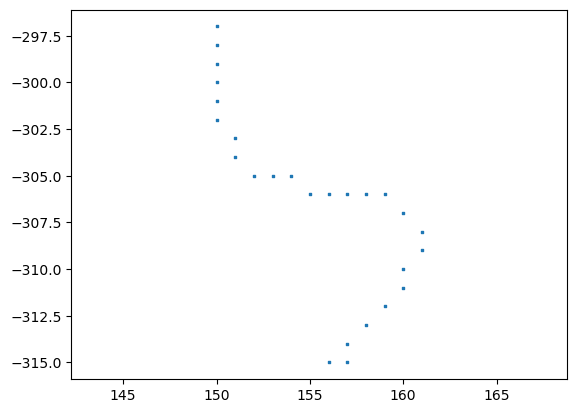

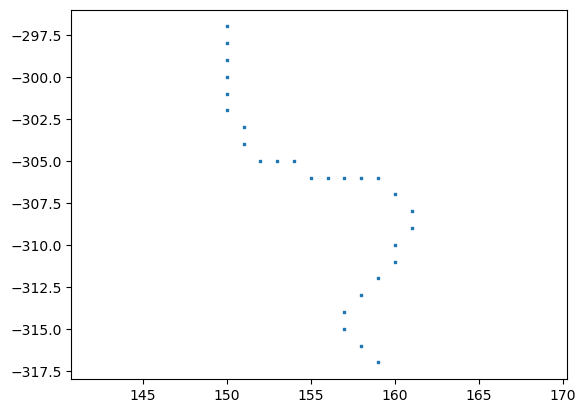

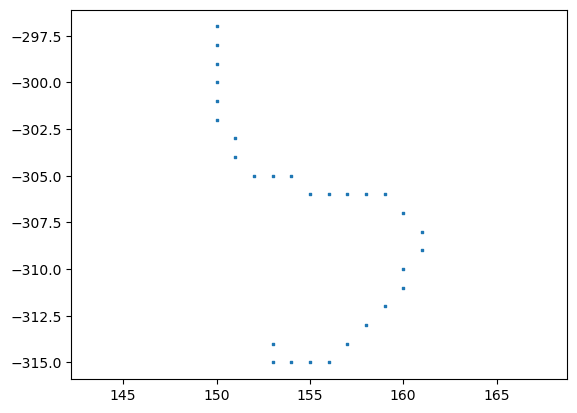

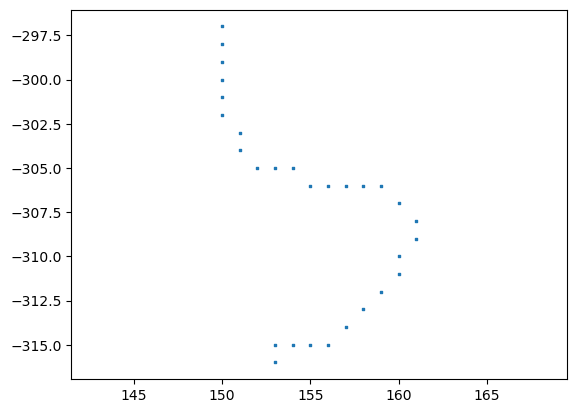

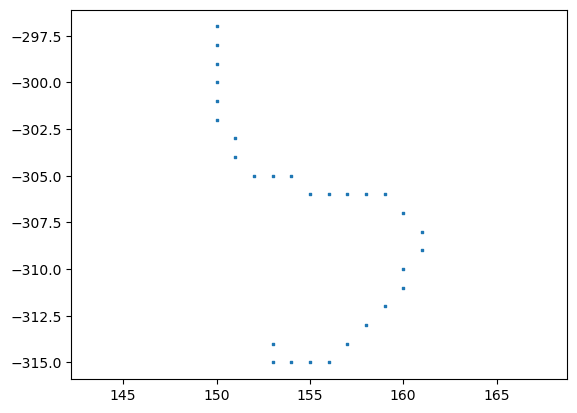

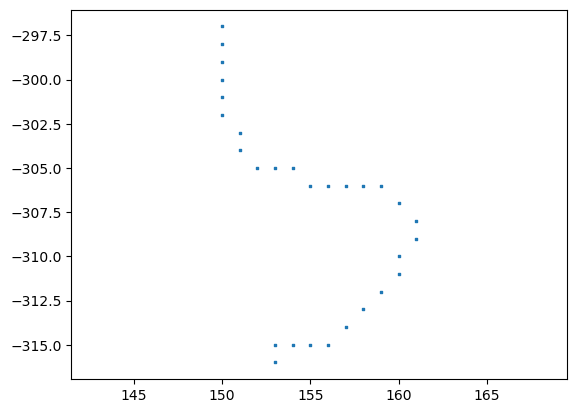

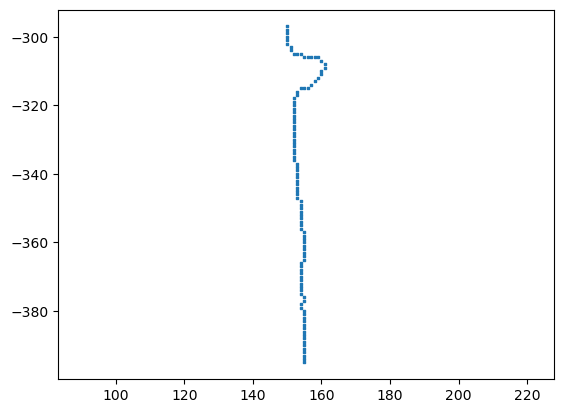

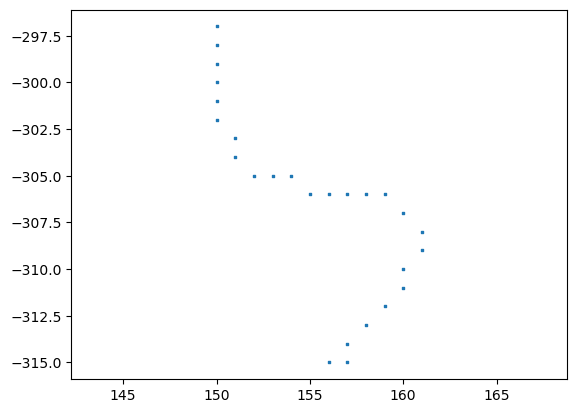

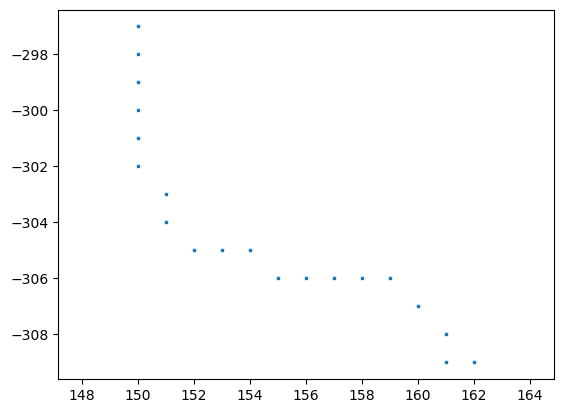

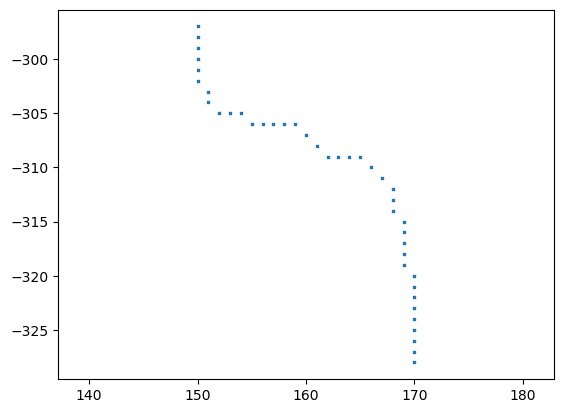

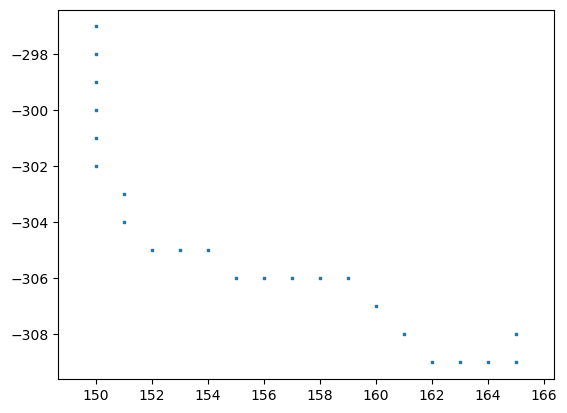

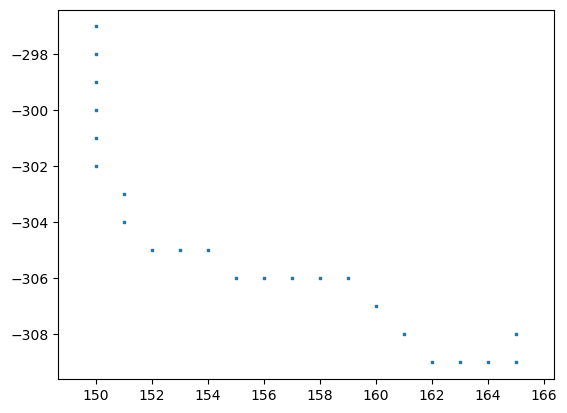

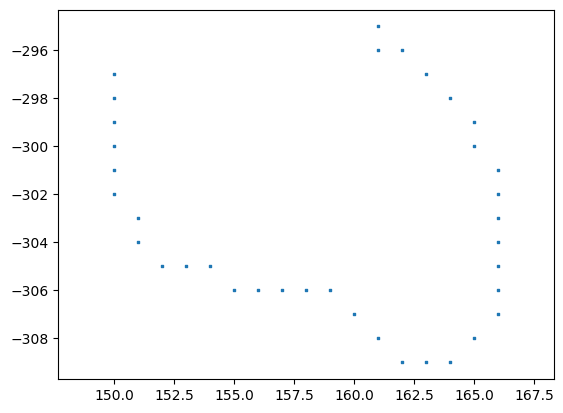

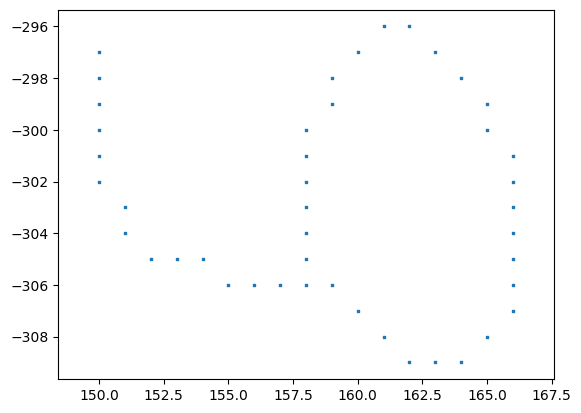

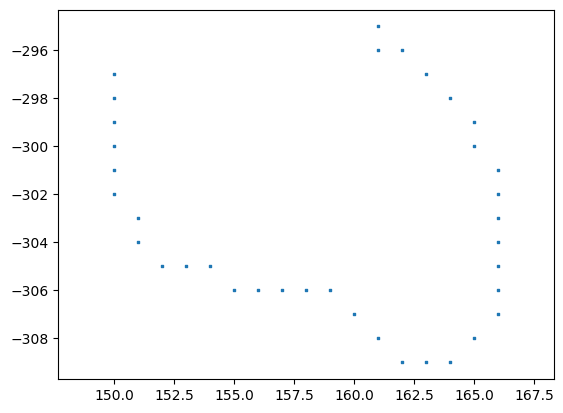

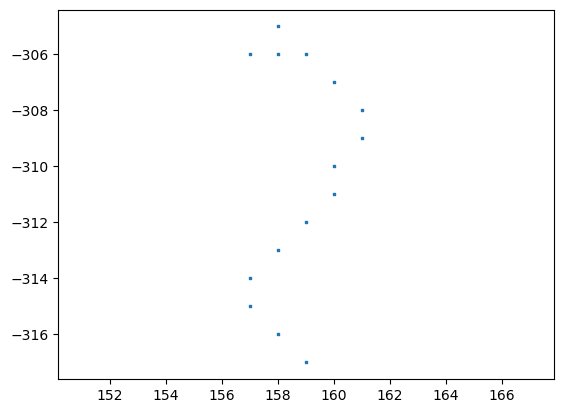

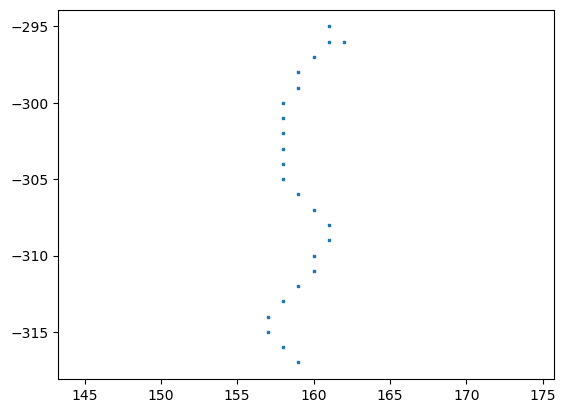

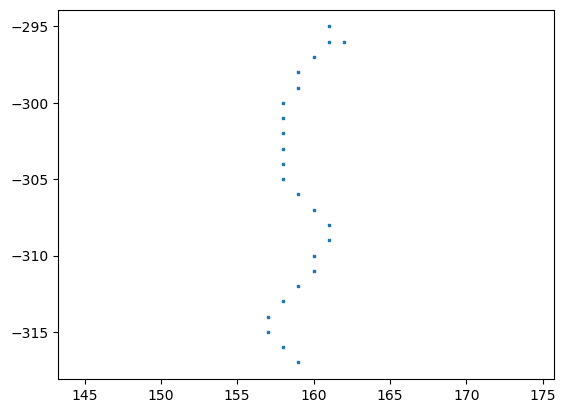

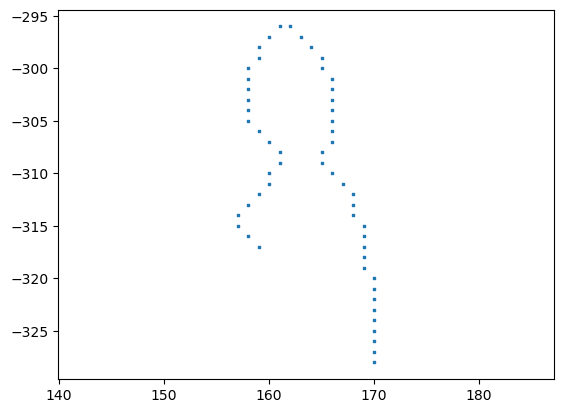

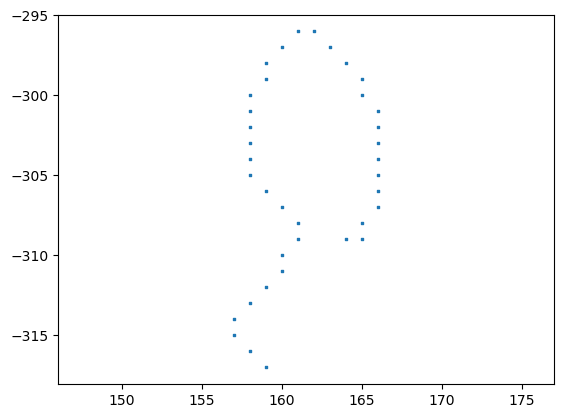

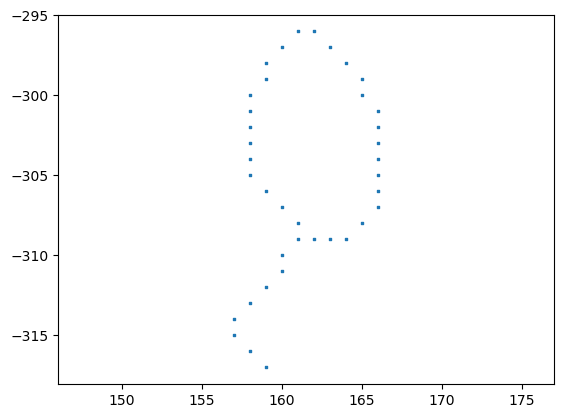

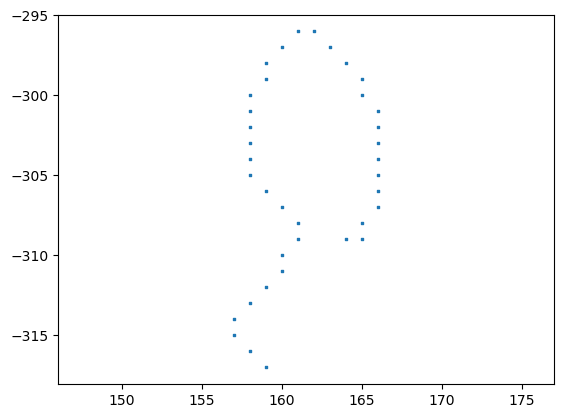

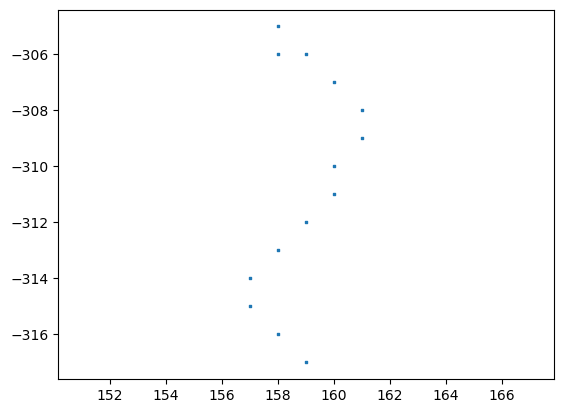

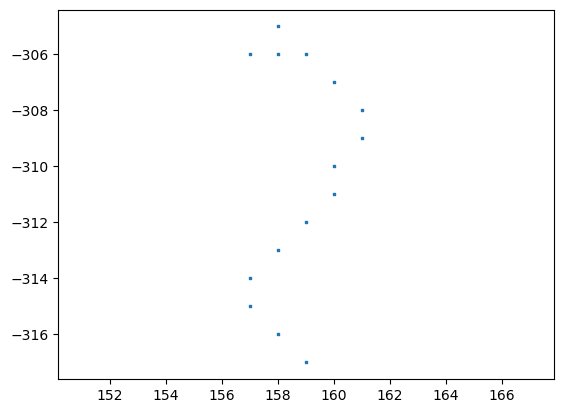

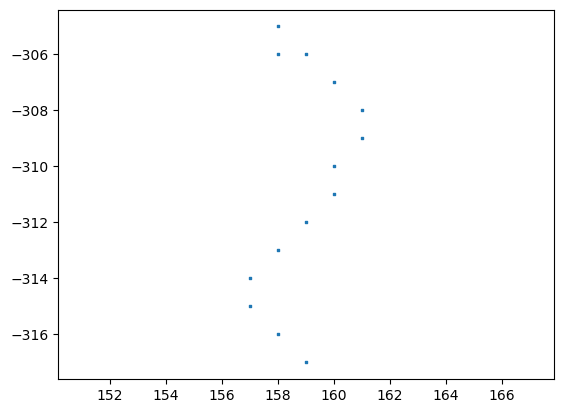

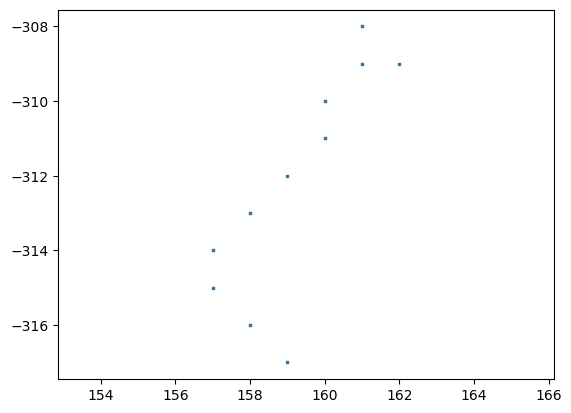

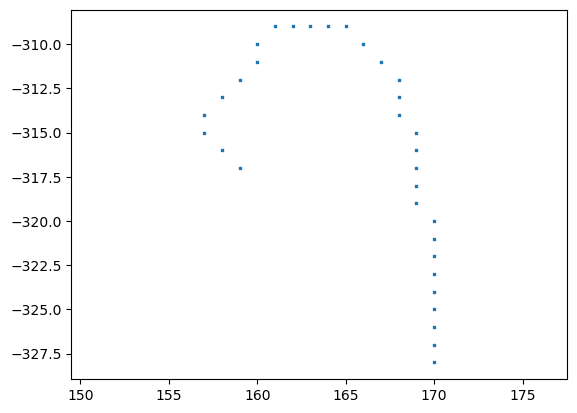

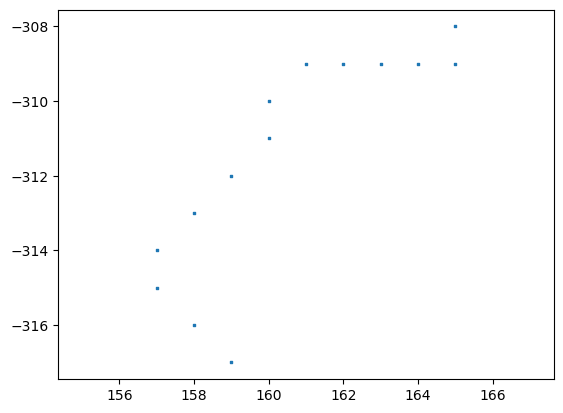

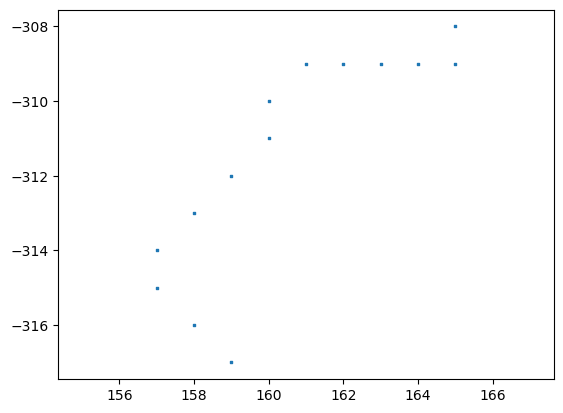

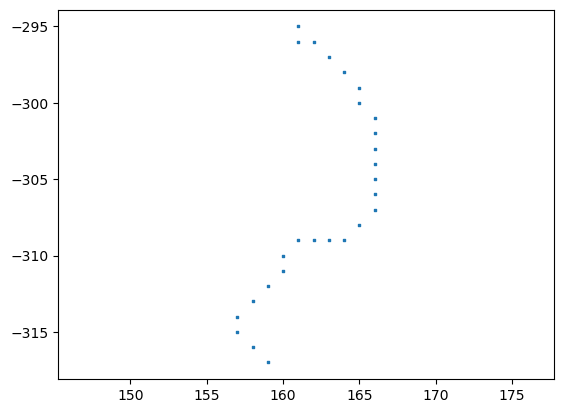

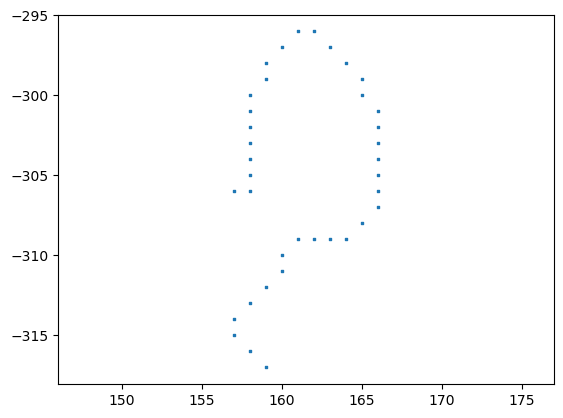

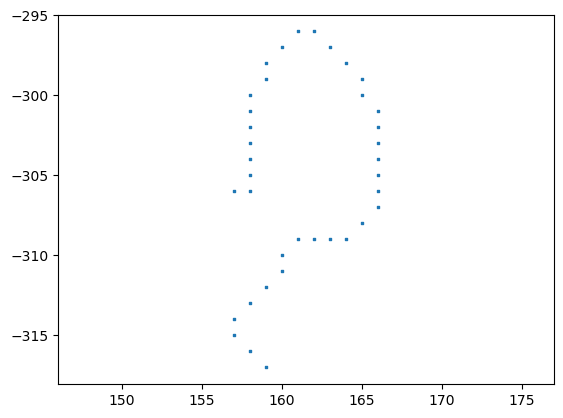

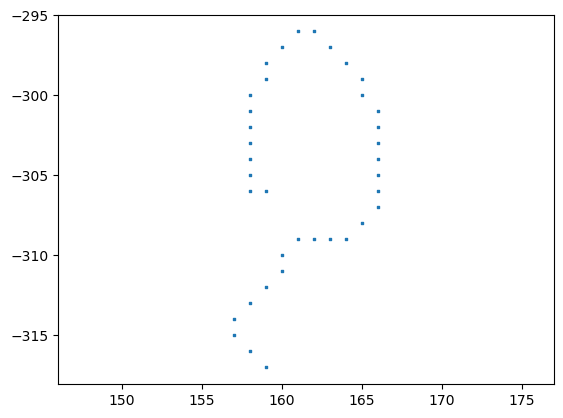

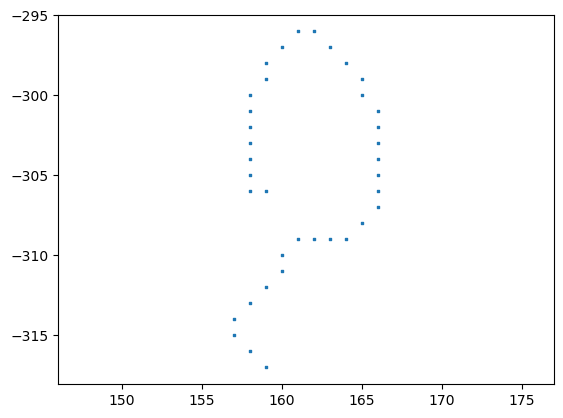

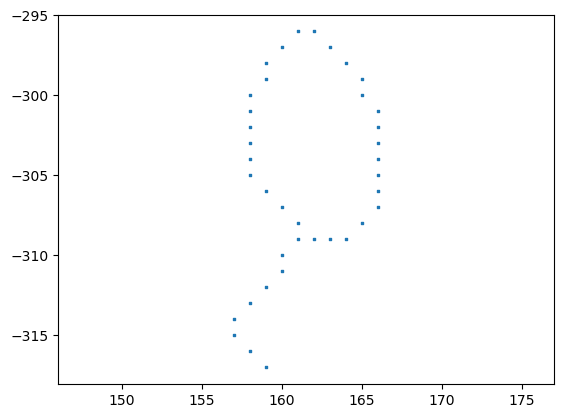

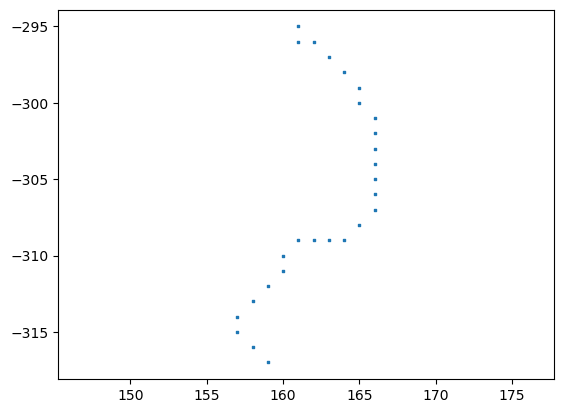

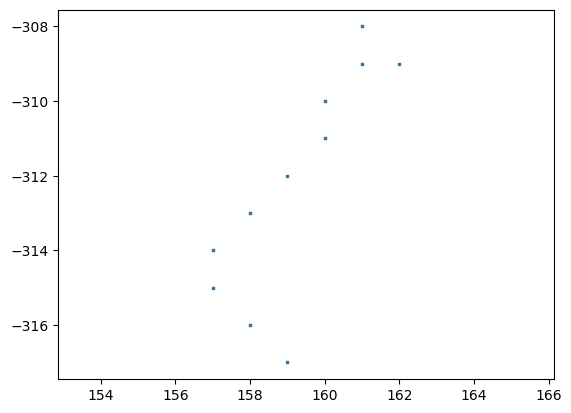

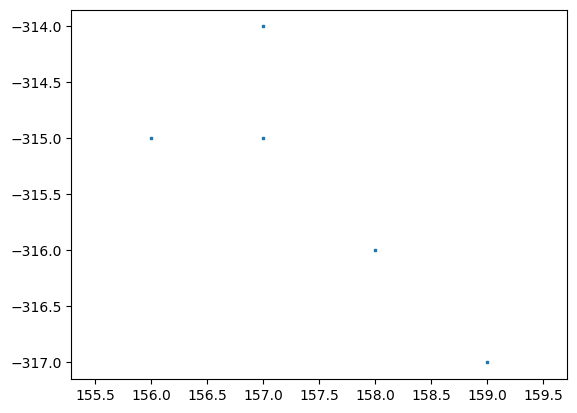

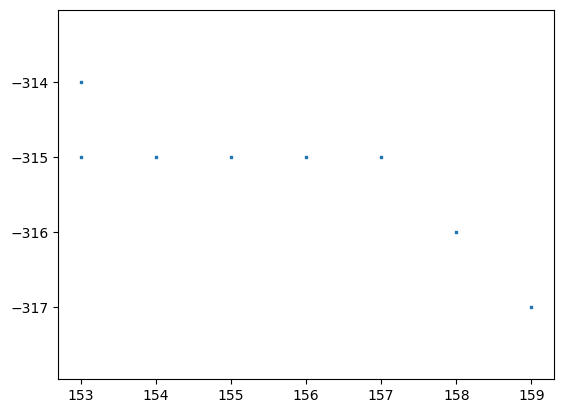

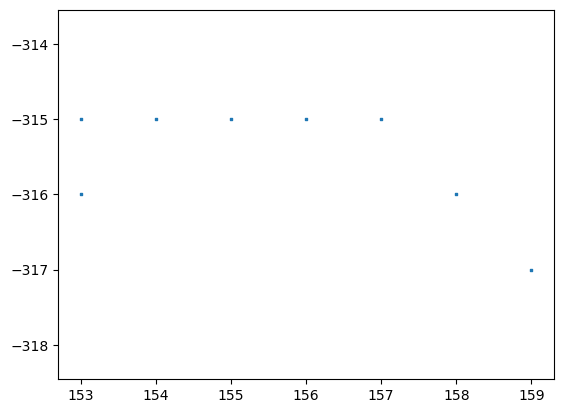

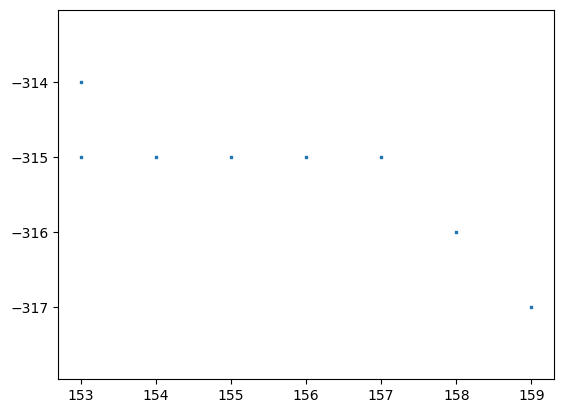

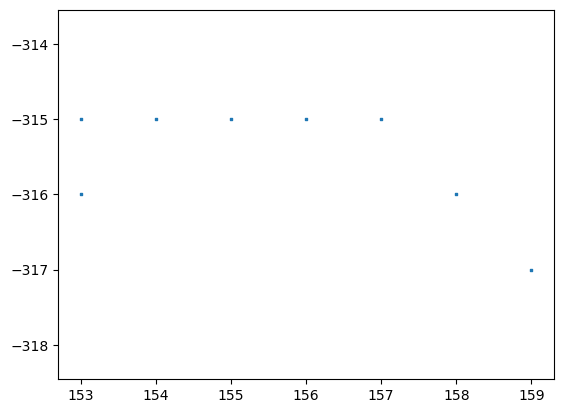

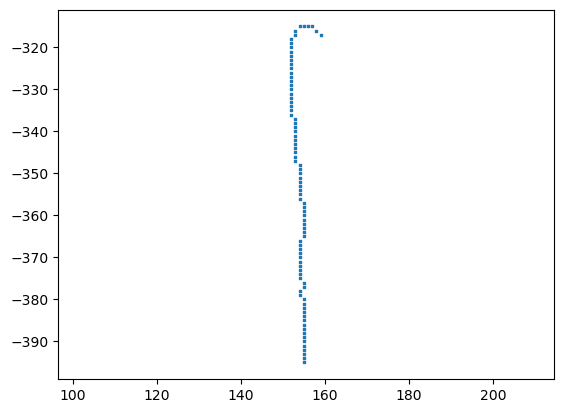

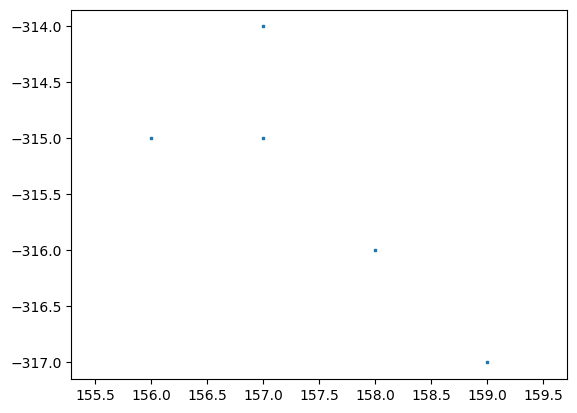

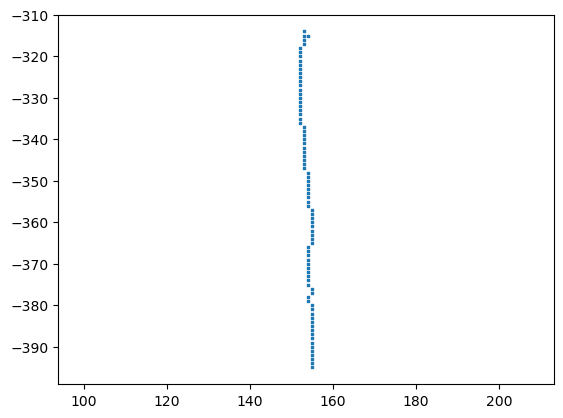

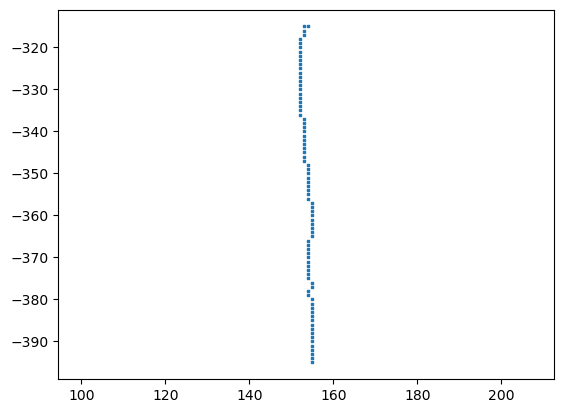

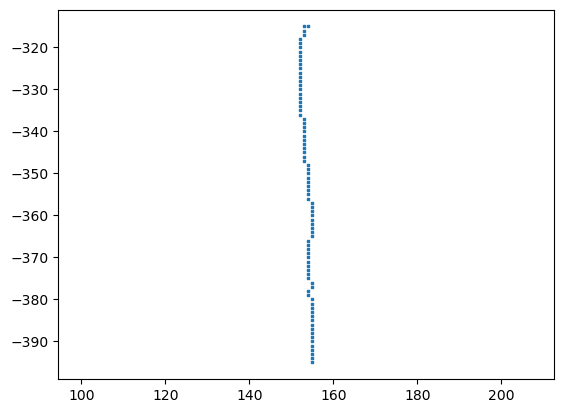

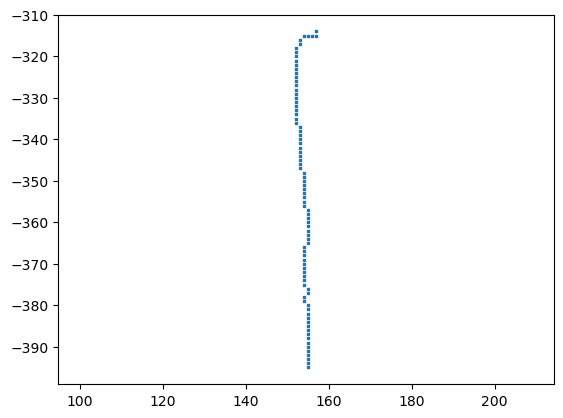

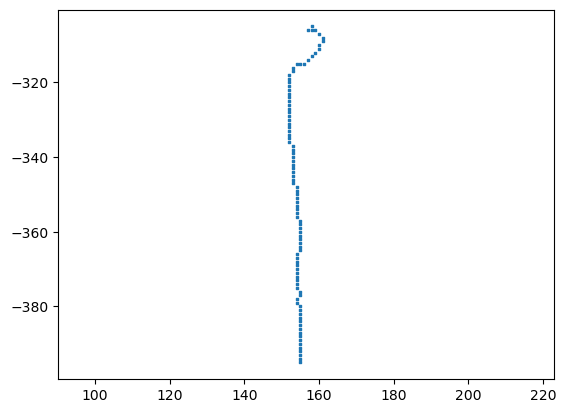

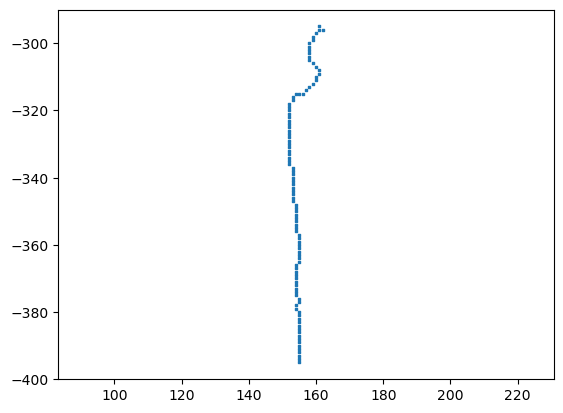

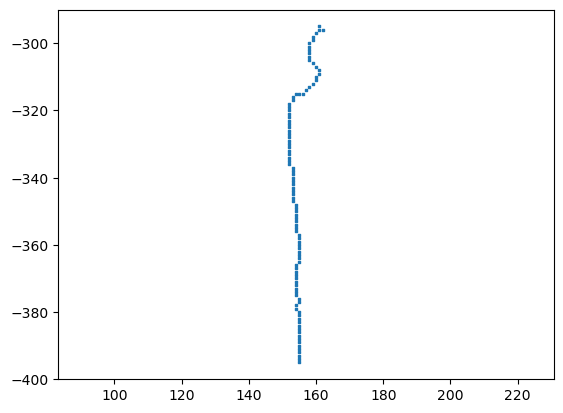

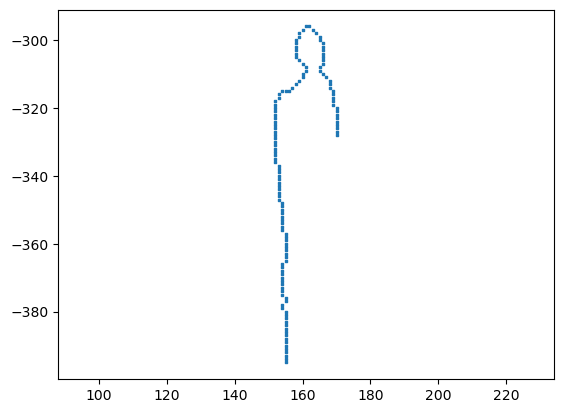

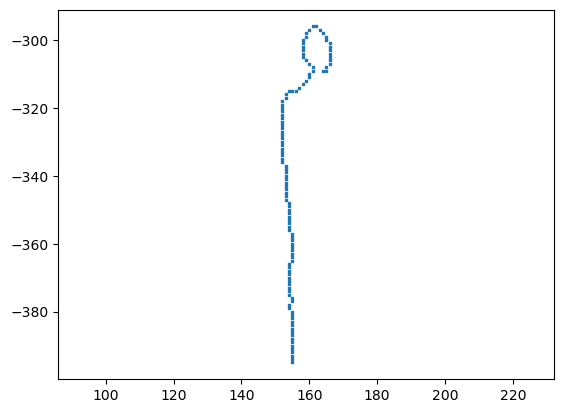

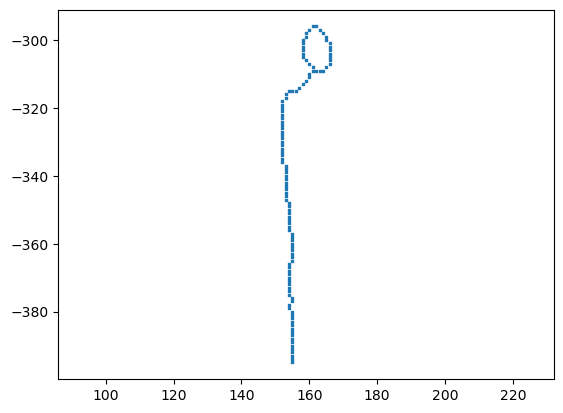

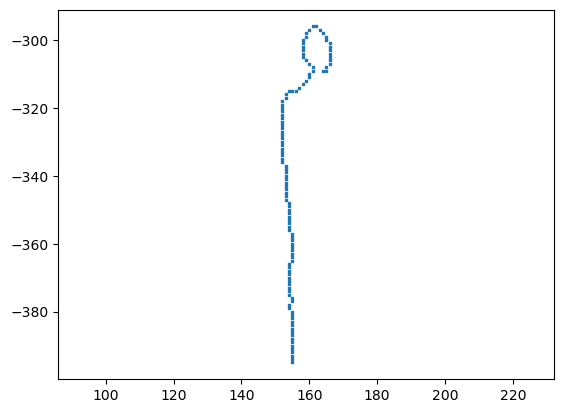

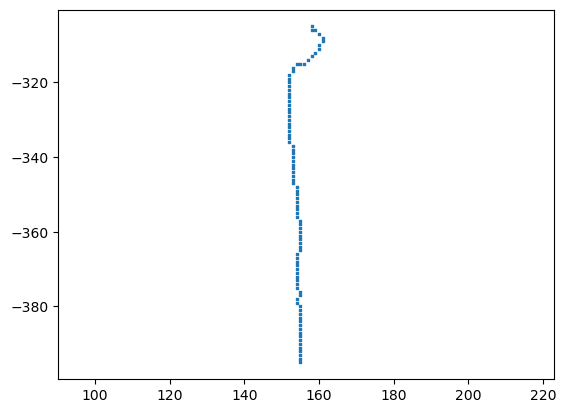

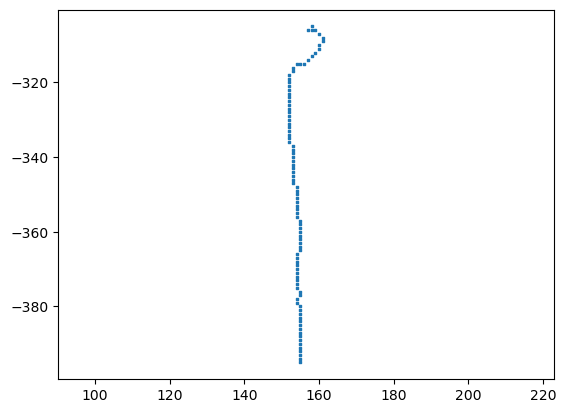

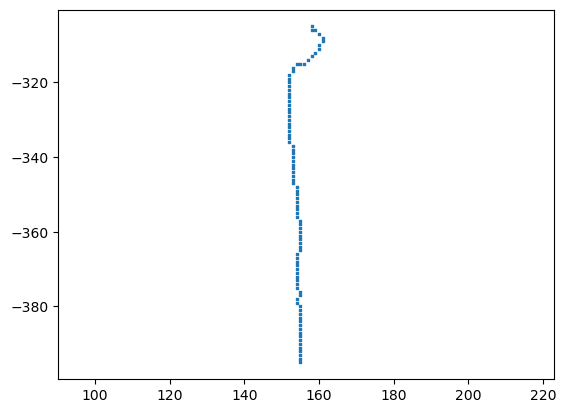

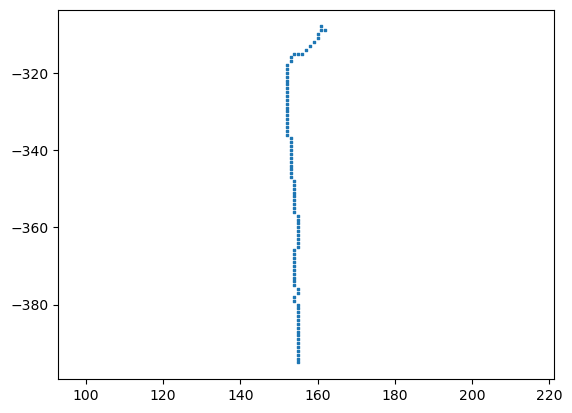

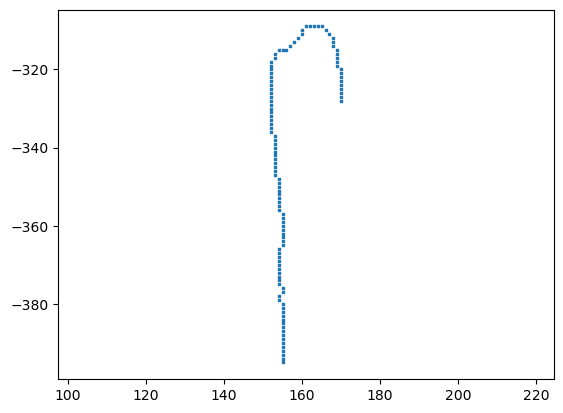

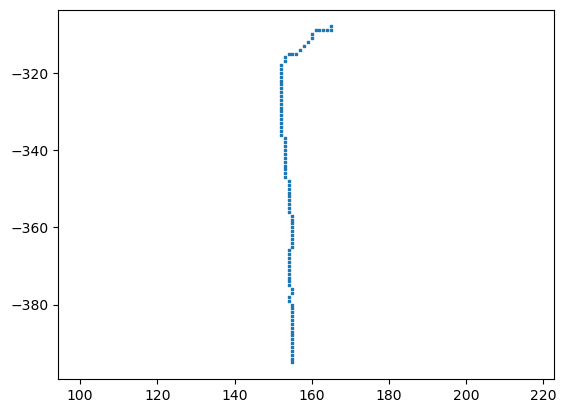

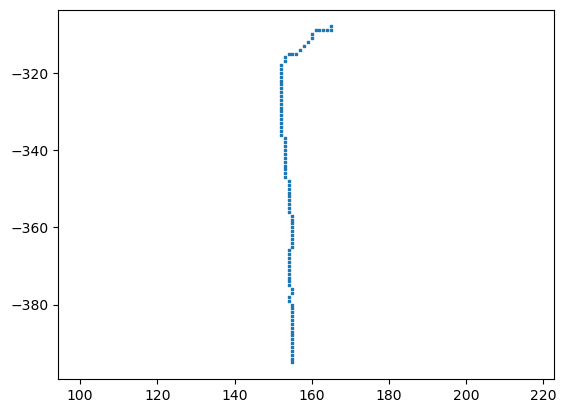

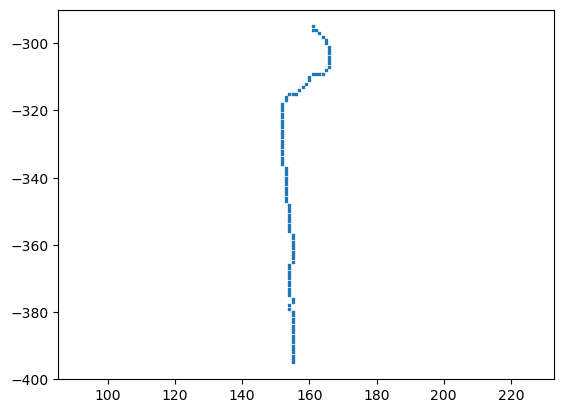

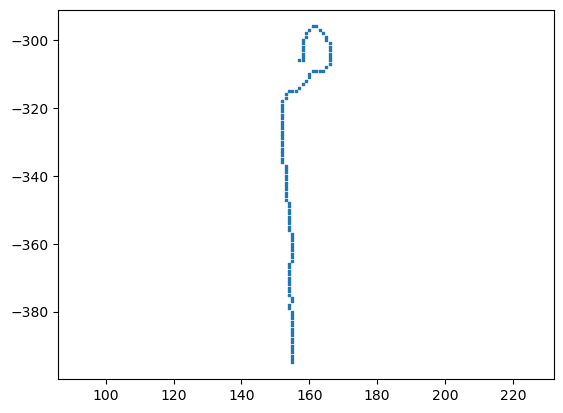

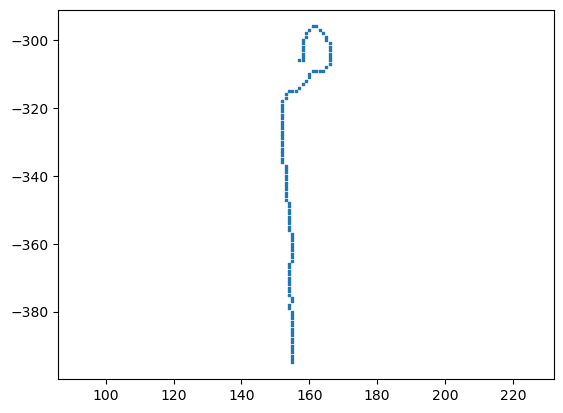

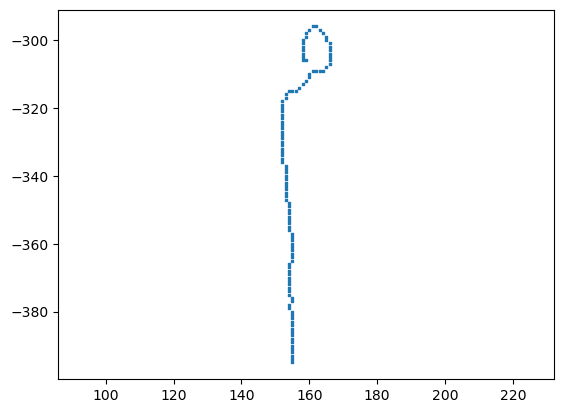

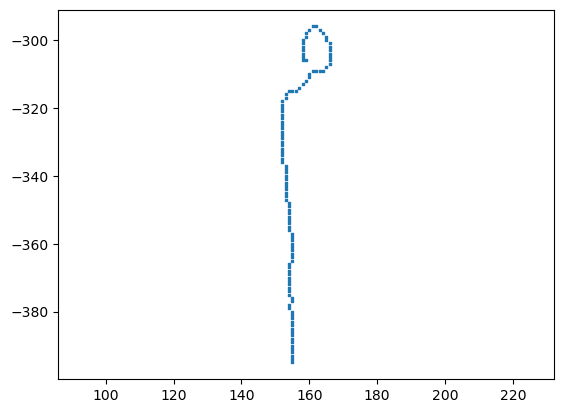

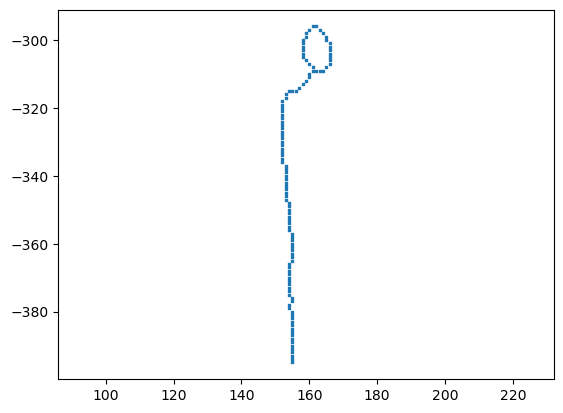

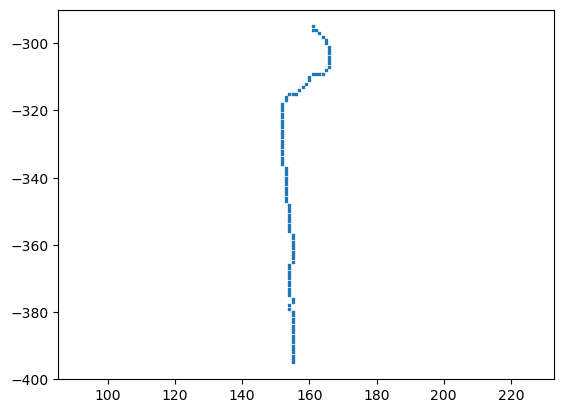

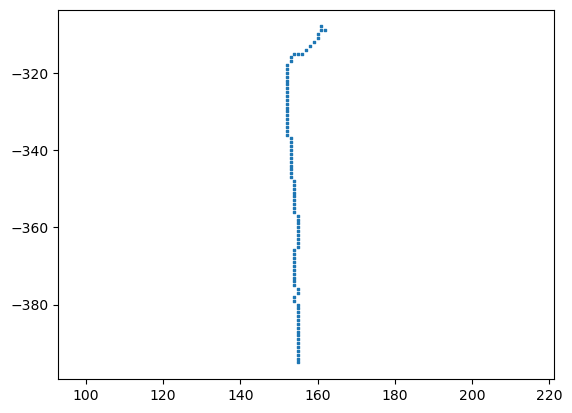

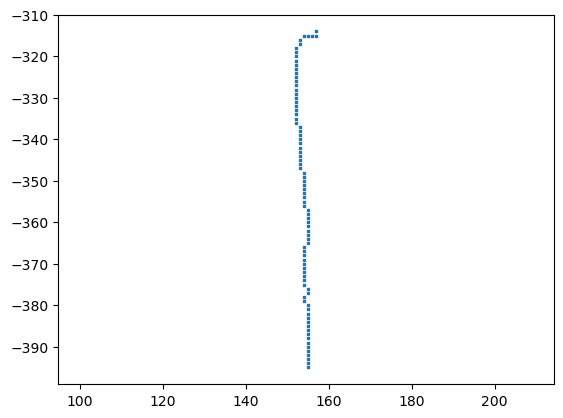

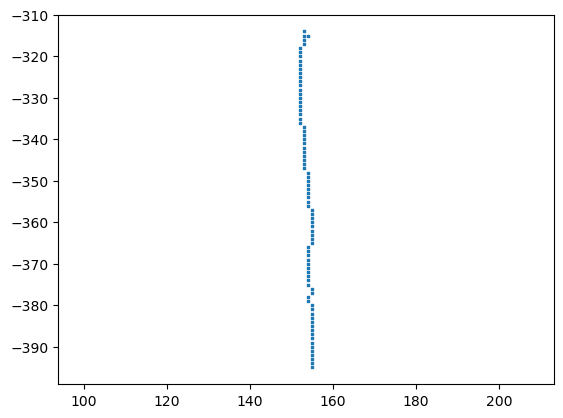

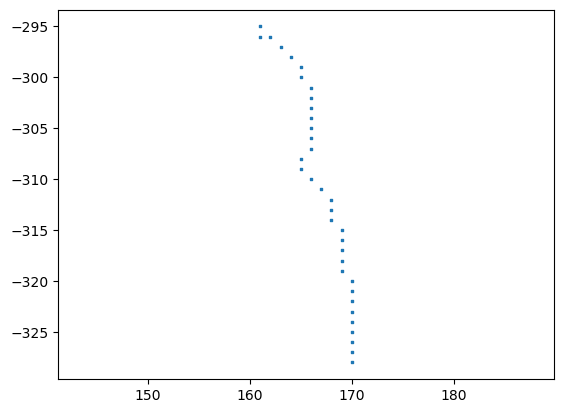

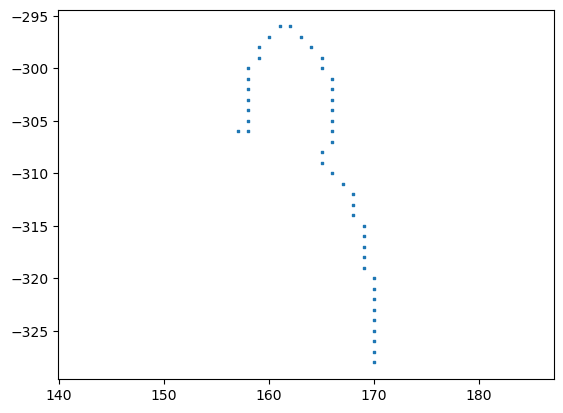

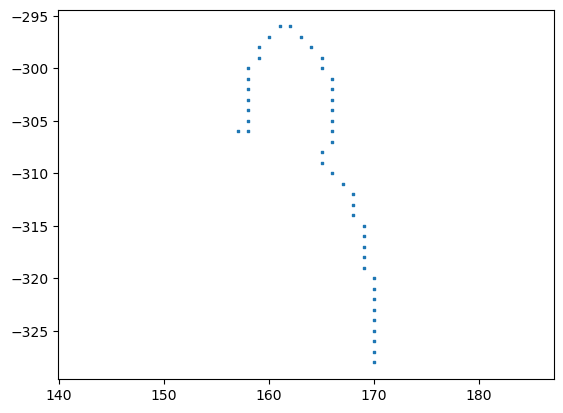

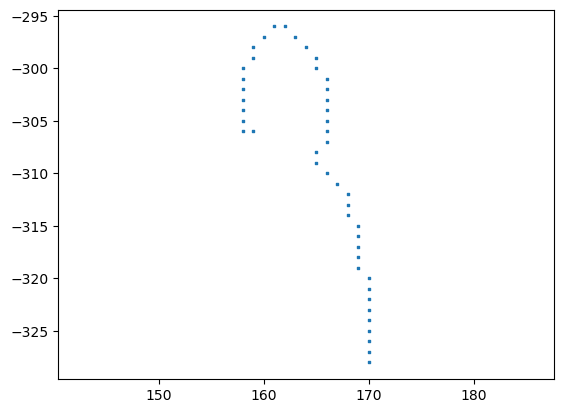

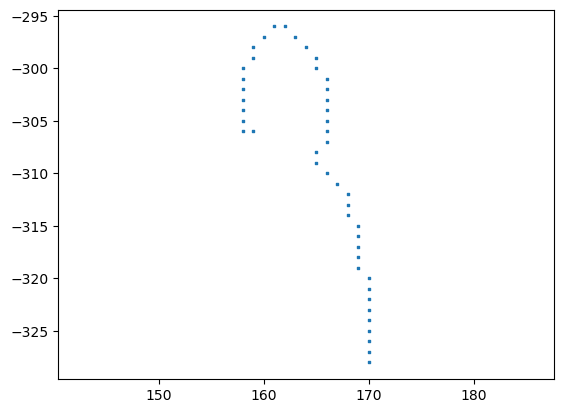

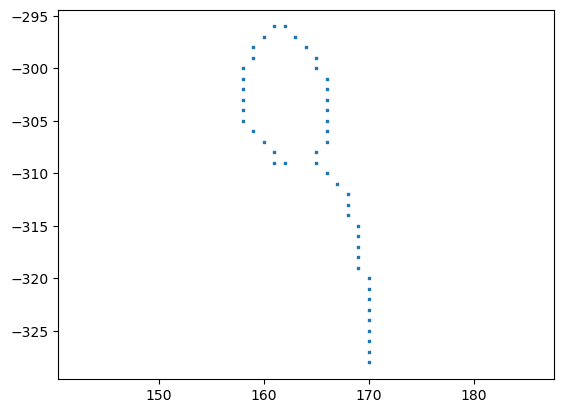

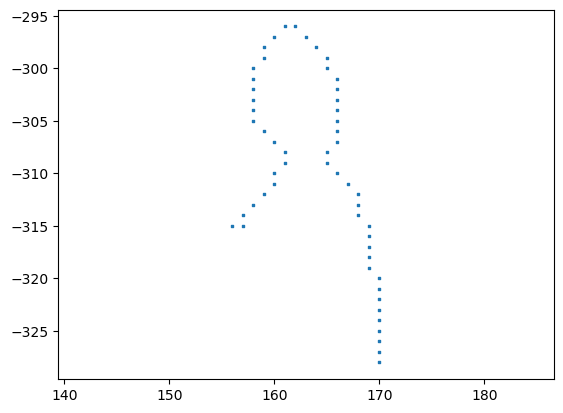

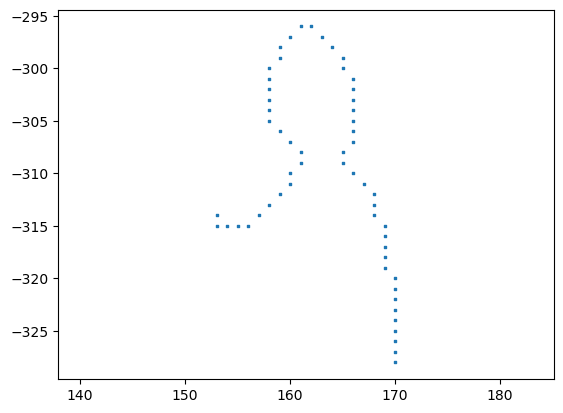

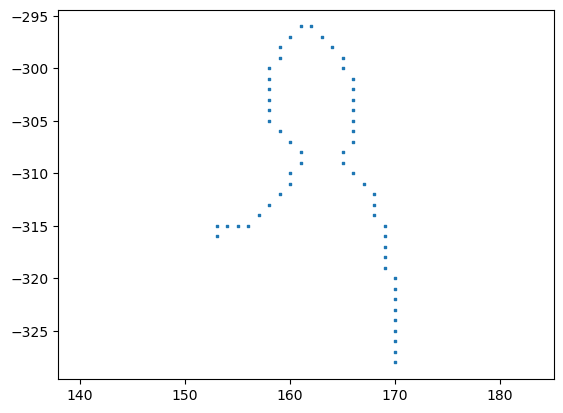

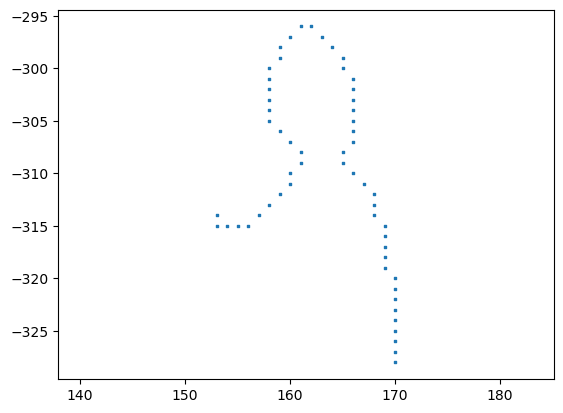

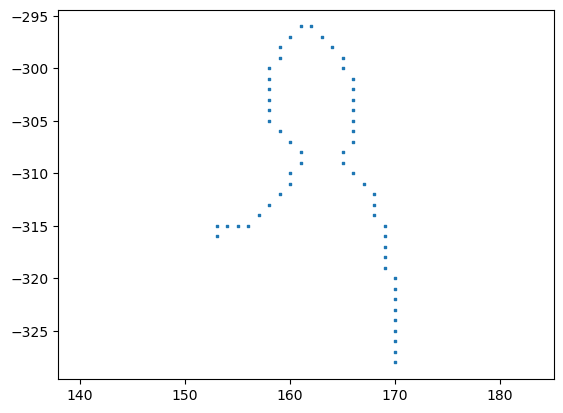

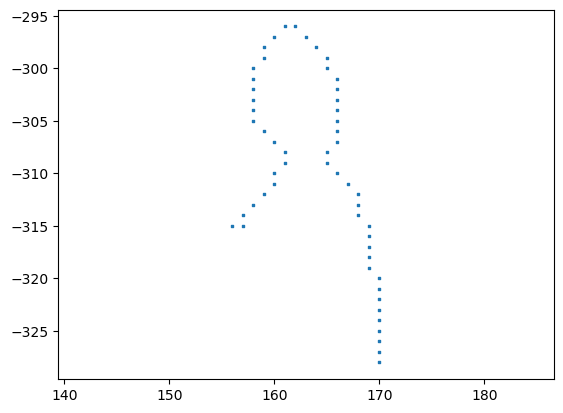

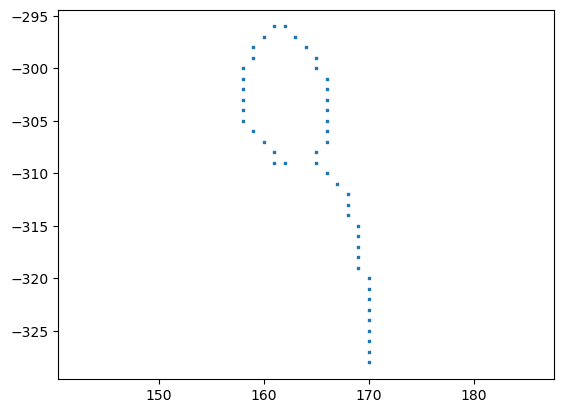

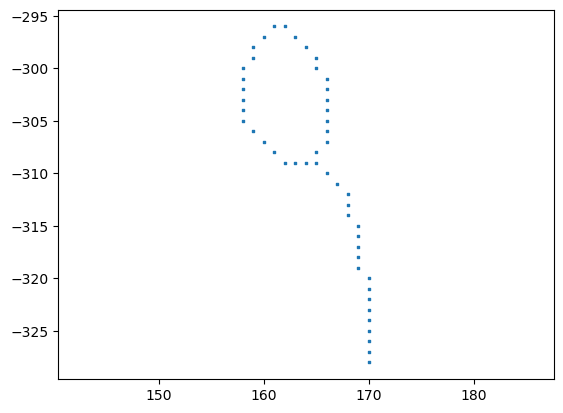

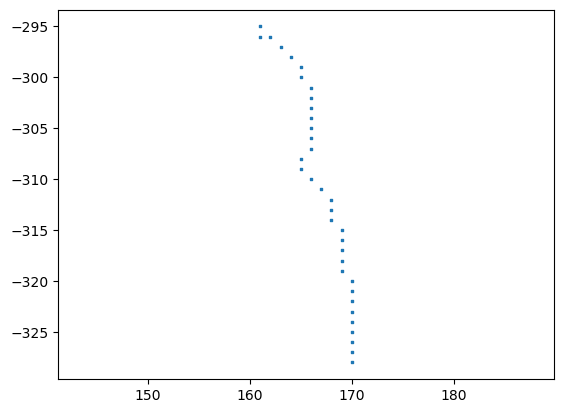

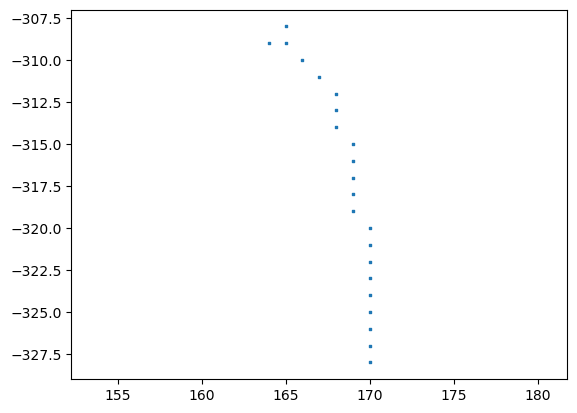

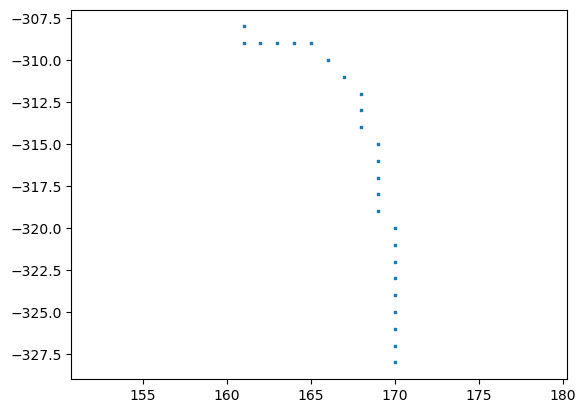

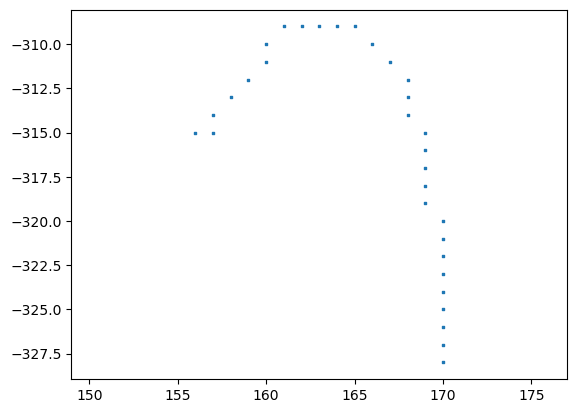

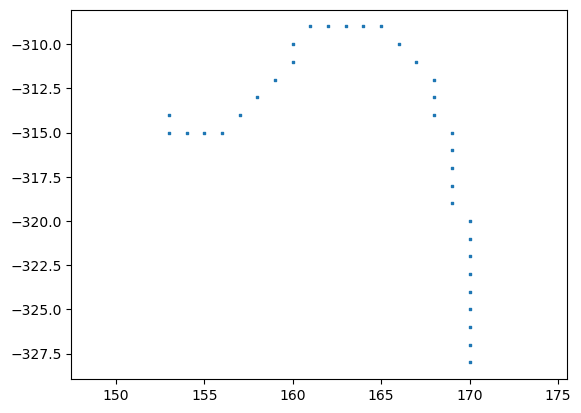

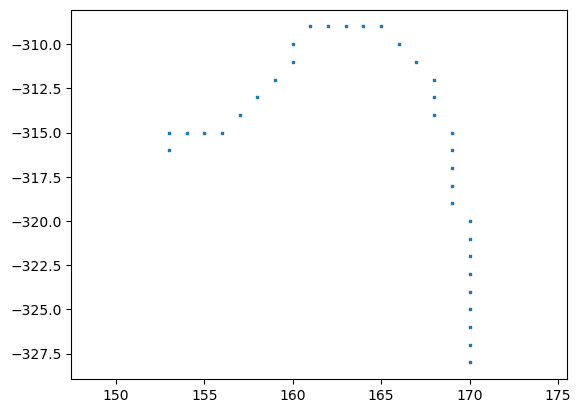

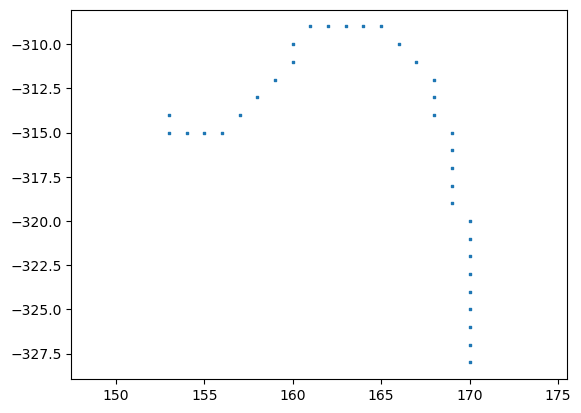

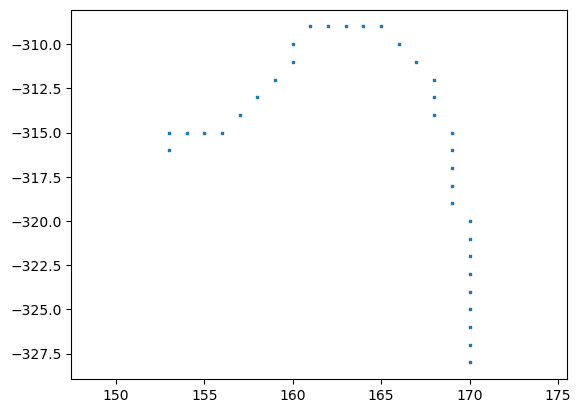

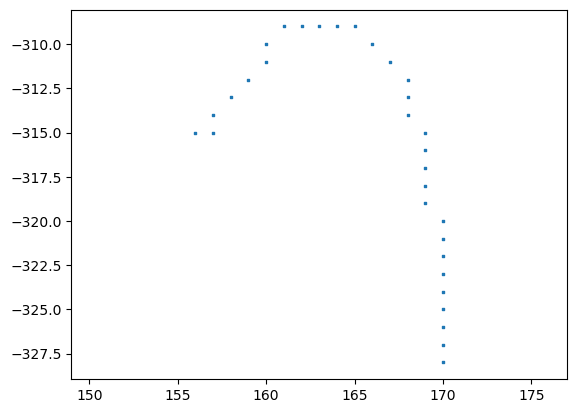

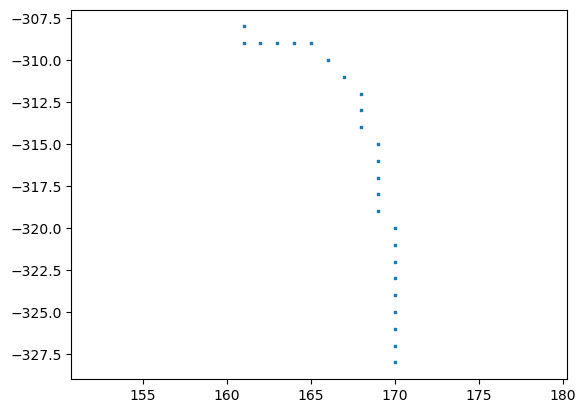

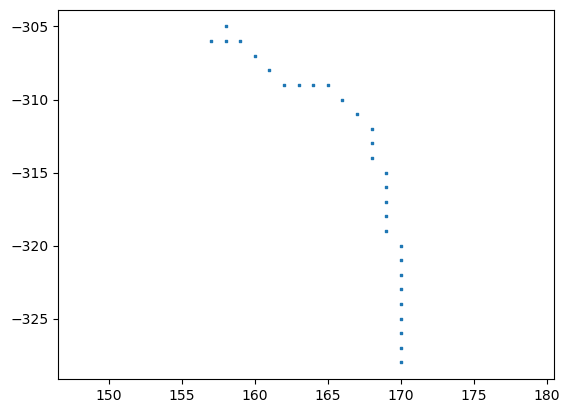

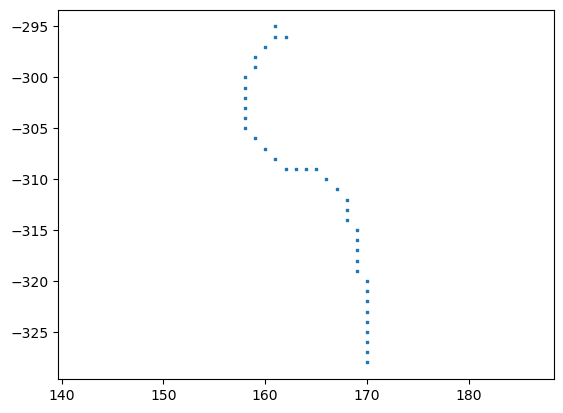

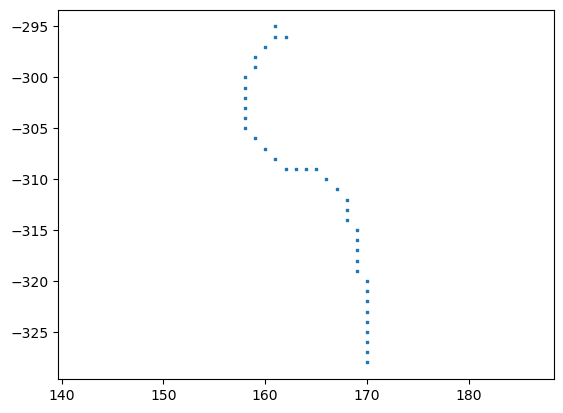

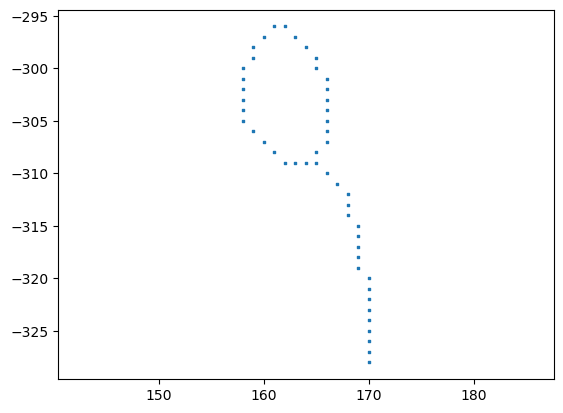

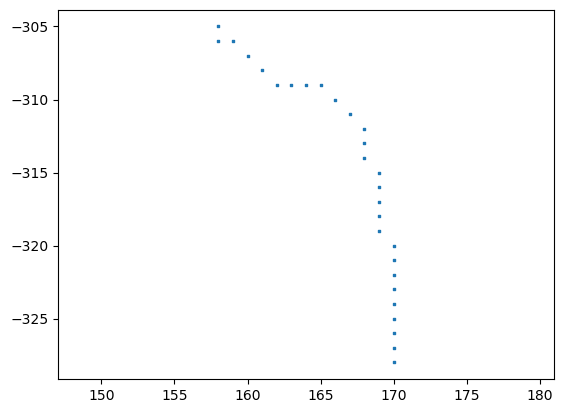

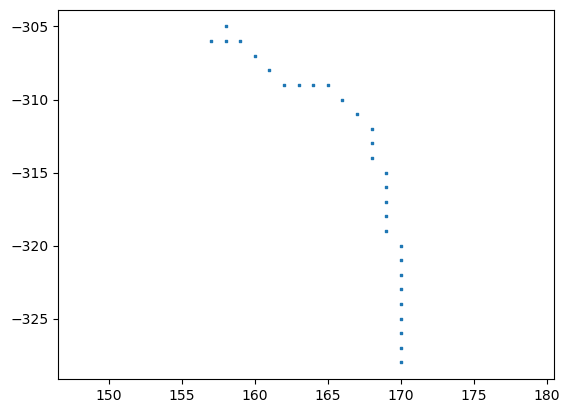

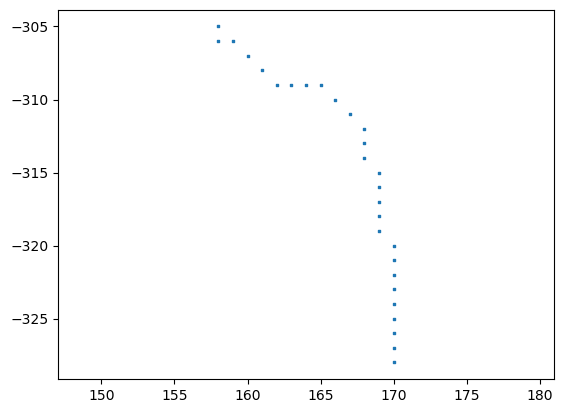

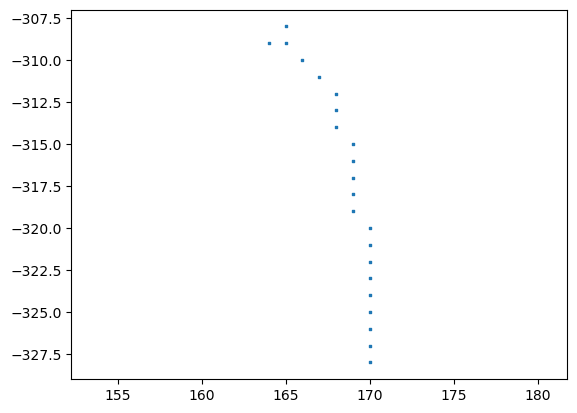

In [42]:
for c in l_l_skeleton_candidates[i][j]:
    nodes = list(c)
    x_coords = [n[1] for n in nodes]
    y_coords = [-n[0] for n in nodes]

    plt.scatter(x_coords, y_coords, s=1, marker='s')
    plt.axis("equal")
    plt.show()

# Trie des candidats

## tests

In [43]:
def direction(l_points):
    pts = np.array(l_points)
    x = pts[:, 0]
    y = pts[:, 1]

    A = np.vstack([x, np.ones(len(x))]).T
    a, b = np.linalg.lstsq(A, y, rcond=None)[0]

    return np.array([1.0, a])


def angle_between(v1, v2):
    v1 = v1 / np.linalg.norm(v1)
    v2 = v2 / np.linalg.norm(v2)

    cosang = np.dot(v1, v2)
    cosang = max(min(cosang, 1), -1)

    return np.degrees(np.arccos(cosang))


def angle_k_regression(candidate, i, k):
    if i < k or i >= len(candidate) - k:
        return None

    before = candidate[i-k:i]     
    after  = candidate[i+1:i+1+k]  

    u = direction(before)
    v = direction(after)

    return angle_between(u, v)

def score_angle(candidate, i, k = 10):
    angle = angle_k_regression(candidate, i, k)
    if angle is None:
        return None
    if angle<=90:
        return angle
    else :
        return 180-angle


In [56]:
i = 4 # numéro de l'image
j = 0 # numéro du candidat

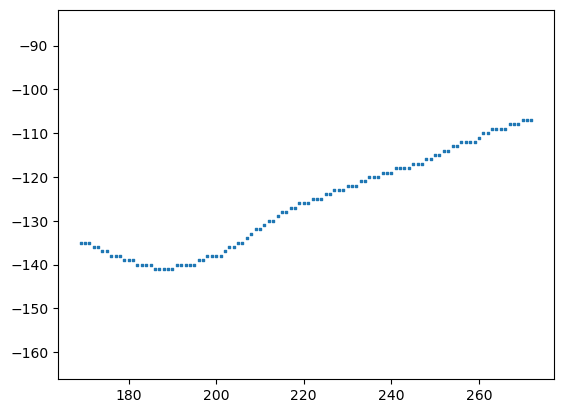

In [57]:
c = l_l_skeleton_candidates[i][j][0]
nodes = list(c)
x_coords = [n[1] for n in nodes]
y_coords = [-n[0] for n in nodes]

plt.scatter(x_coords, y_coords, s=1, marker='s')
plt.axis("equal")
plt.show()

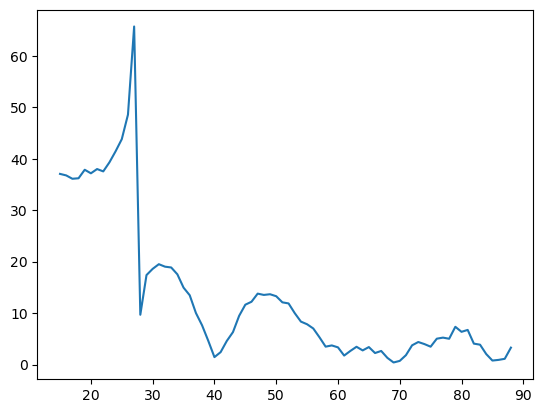

In [58]:
plt.plot([score_angle(l_l_skeleton_candidates[i][j][0],num, k= 15) for num in range(len(l_l_skeleton_candidates[i][j][0]))])
plt.show()

marche pas car skeleton pas smooth

In [59]:
from scipy.interpolate import CubicSpline
import numpy as np

def courbure_spline_param(points):
    pts = np.array(points)
    n = len(pts)

    # paramètre t = 0..1
    t = np.linspace(0, 1, n)

    Sx = CubicSpline(t, pts[:,0])
    Sy = CubicSpline(t, pts[:,1])

    def kappa(ti):
        dx = Sx.derivative(1)(ti)
        dy = Sy.derivative(1)(ti)
        d2x = Sx.derivative(2)(ti)
        d2y = Sy.derivative(2)(ti)
        num = abs(dx*d2y - dy*d2x)
        den = (dx*dx + dy*dy)**1.5
        return num / den

    return kappa, t

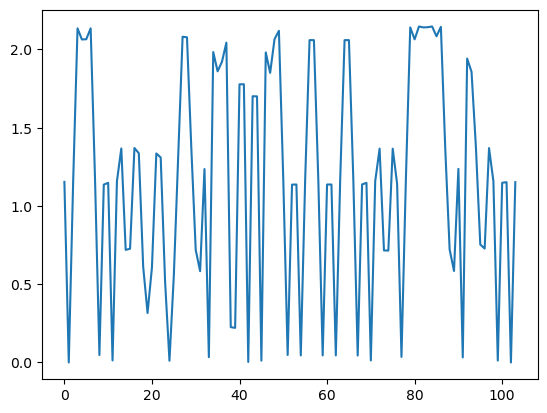

In [60]:
kappa, t = courbure_spline_param(l_l_skeleton_candidates[i][j][0])
plt.plot([kappa(i) for i in t])
plt.show()

In [49]:
def smooth_points(points, w=3):
    pts = np.array(points)
    res = []
    for i in range(len(pts)):
        i0 = max(0, i-w)
        i1 = min(len(pts), i+w+1)
        res.append(np.mean(pts[i0:i1], axis=0))
    return np.array(res)


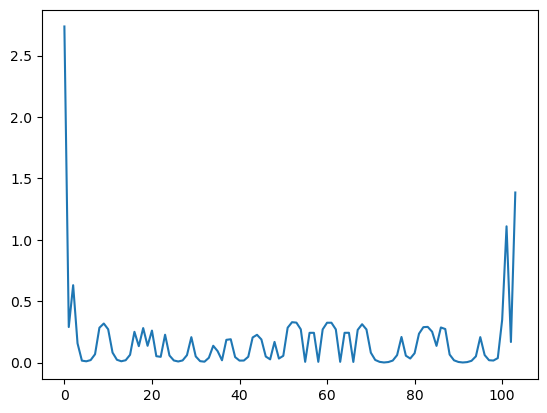

In [50]:
kappa, t = courbure_spline_param(smooth_points(l_l_skeleton_candidates[i][j][0]))
plt.plot([kappa(i) for i in t])
plt.show()

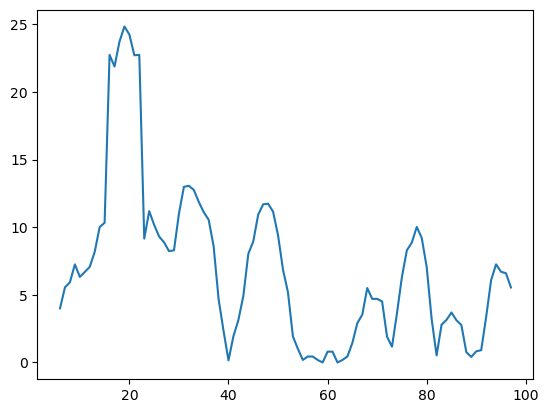

In [51]:
plt.plot([score_angle(smooth_points(l_l_skeleton_candidates[i][j][0]),num, k= 6) for num in range(len(l_l_skeleton_candidates[i][j][0]))])
plt.show()

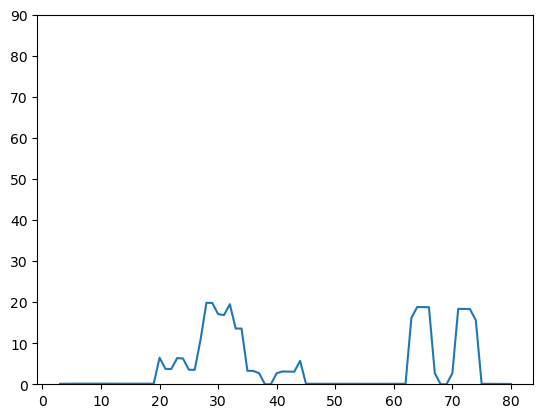

In [52]:
plt.plot([score_angle(smooth_points(l_l_skeleton_candidates[1][0][0]),num, k= 3) for num in range(len(l_l_skeleton_candidates[i][j][0]))])
plt.ylim((0,90))
plt.show()

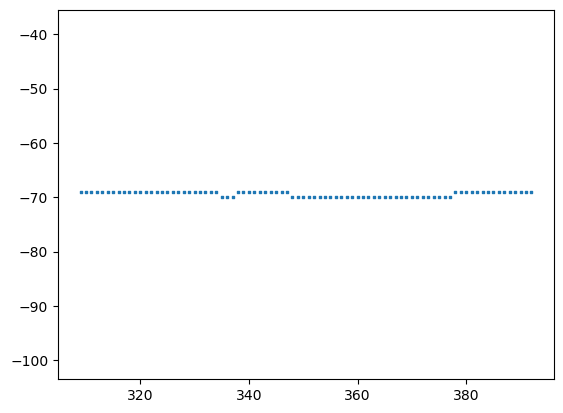

In [53]:
c = l_l_skeleton_candidates[1][0][0]
nodes = list(c)
x_coords = [n[1] for n in nodes]
y_coords = [-n[0] for n in nodes]

plt.scatter(x_coords, y_coords, s=1, marker='s')
plt.axis("equal")
plt.show()

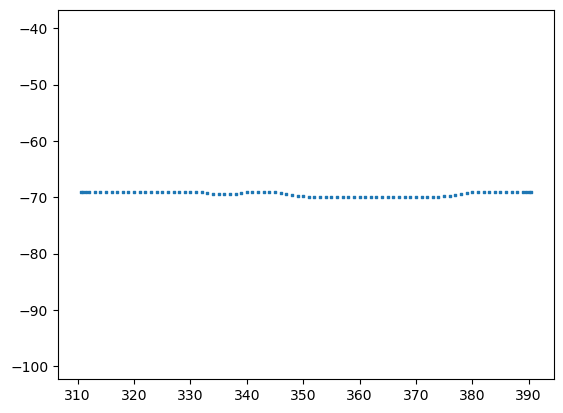

In [54]:
c = smooth_points(l_l_skeleton_candidates[1][0][0])
nodes = list(c)
x_coords = [n[1] for n in nodes]
y_coords = [-n[0] for n in nodes]

plt.scatter(x_coords, y_coords, s=1, marker='s')
plt.axis("equal")
plt.show()

In [105]:
def direction(l_points):
    pts = np.array(l_points)
    x = pts[:, 0]
    y = pts[:, 1]

    A = np.vstack([x, np.ones(len(x))]).T
    a, b = np.linalg.lstsq(A, y, rcond=None)[0]

    return np.array([1.0, a])


def angle_between(v1, v2):
    v1 = v1 / np.linalg.norm(v1)
    v2 = v2 / np.linalg.norm(v2)

    cosang = np.dot(v1, v2)
    cosang = max(min(cosang, 1), -1)

    return np.degrees(np.arccos(cosang))


def angle_k_regression(nodes, i, k):
    if i < k or i >= len(nodes) - k:
        return None

    before = nodes[i-k:i]     
    after  = nodes[i+1:i+1+k]  

    u = direction(before)
    v = direction(after)

    return angle_between(u, v)

def score_angle(nodes, i, k):
    angle = angle_k_regression(nodes, i, k)
    if angle is None:
        return None
    if angle<=90:
        return angle
    else :
        return 180-angle
    
def smooth_points(points, w=3):
    pts = np.array(points)
    res = []
    for i in range(len(pts)):
        i0 = max(0, i-w)
        i1 = min(len(pts), i+w+1)
        res.append(np.mean(pts[i0:i1], axis=0))
    return np.array(res)

def all_score_angle(candidate, k = 10):
    nodes = smooth_points(list(c))
    l_score_angle = []
    for i in range(k,len(candidate)-k):
        l_score_angle.append(score_angle(candidate, i, k))
    return l_score_angle


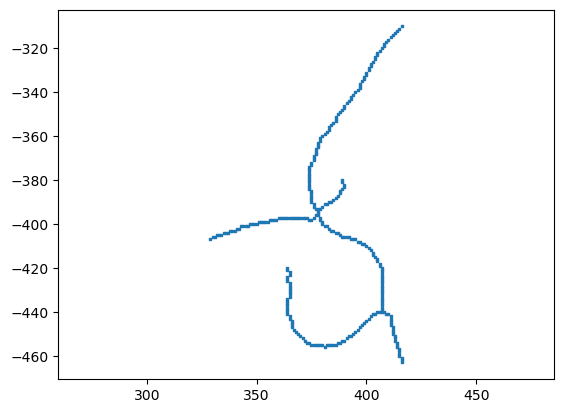

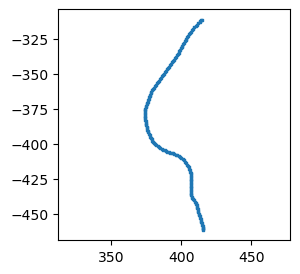

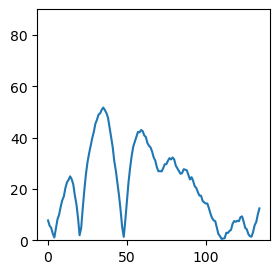

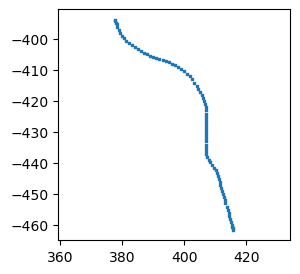

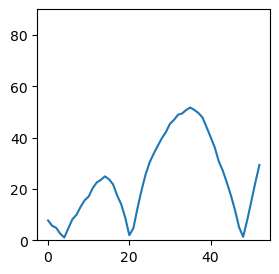

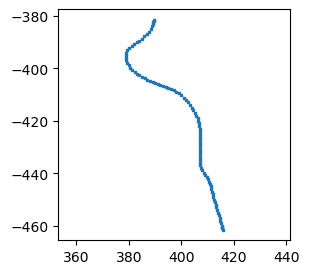

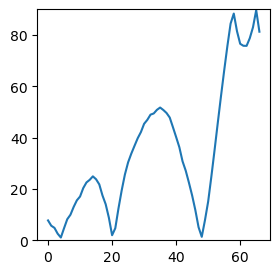

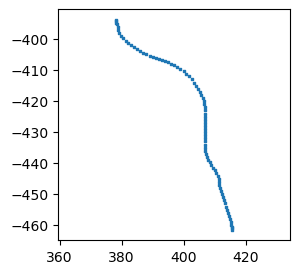

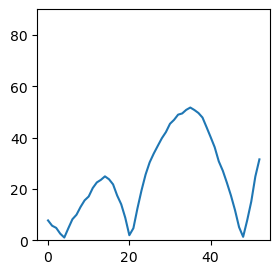

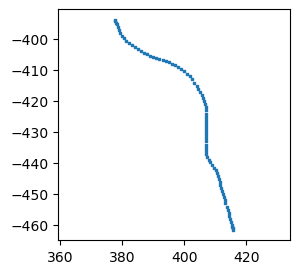

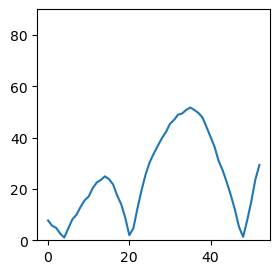

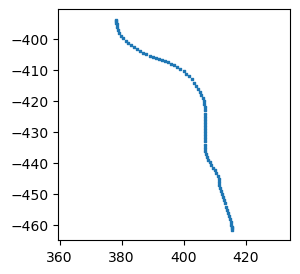

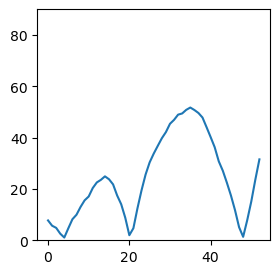

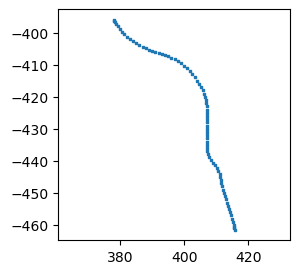

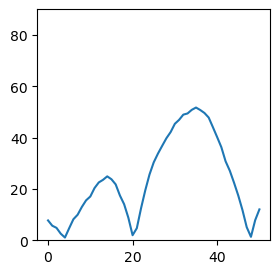

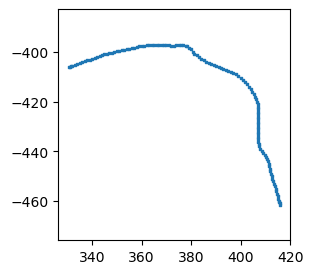

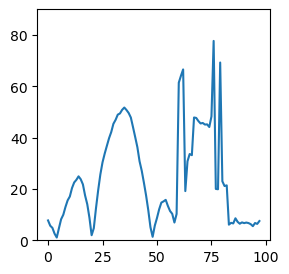

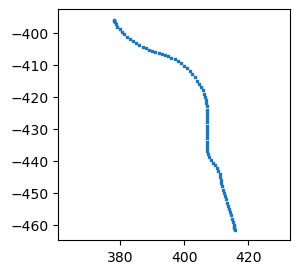

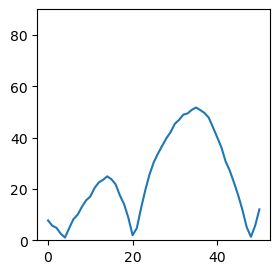

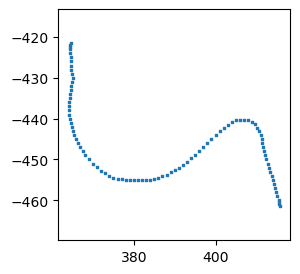

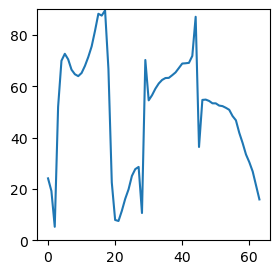

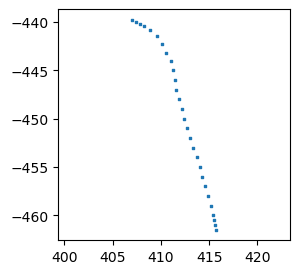

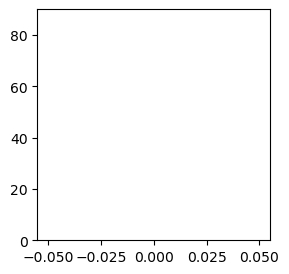

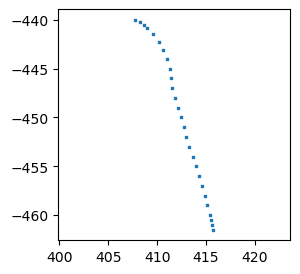

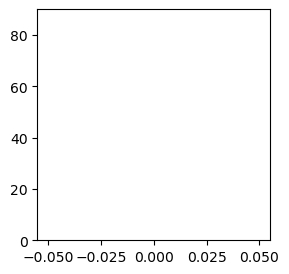

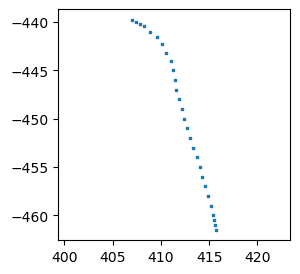

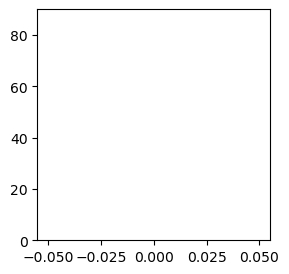

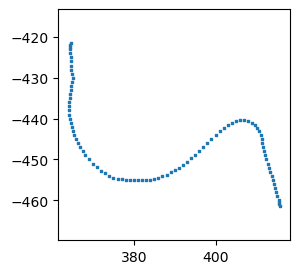

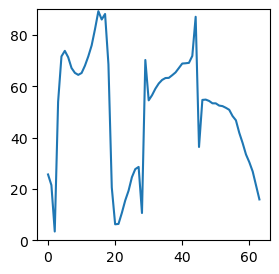

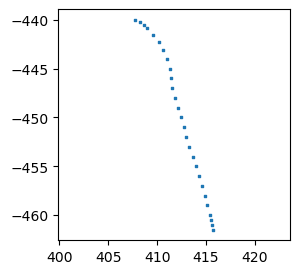

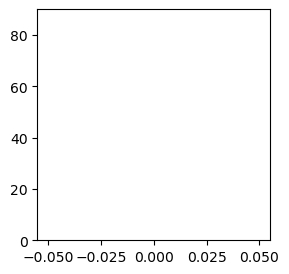

In [109]:
i = 4
j = 10
components = list(nx.connected_components(l_skeleton_graph[i]))
sub_skeleton_graph = l_skeleton_graph[i].subgraph(components[j]).copy()

nodes = list(sub_skeleton_graph)
x_coords = [n[1] for n in nodes]
y_coords = [-n[0] for n in nodes]

plt.scatter(x_coords, y_coords, s=1, marker='s')
plt.axis("equal")
plt.show()

for c in (l_l_skeleton_candidates[i][j][:15]) :
    nodes = smooth_points(list(c))
    x_coords = [n[1] for n in nodes]
    y_coords = [-n[0] for n in nodes]
    plt.figure(figsize=(3,3))
    plt.scatter(x_coords, y_coords, s=1, marker='s')
    plt.axis("equal")
    plt.show()
    plt.figure(figsize=(3,3))
    plt.plot(all_score_angle(c, k= 15))
    plt.ylim((0,90))
    plt.show()

## Propre

In [181]:
def courbure(points, k=10):
    points = np.array(points)
    n = len(points)
    courbures = []

    for i in range(k, n - k):
        p_prev = points[i - k]
        p = points[i]
        p_next = points[i + k]

        u = p - p_prev
        v = p_next - p

        norm_u = np.linalg.norm(u)
        norm_v = np.linalg.norm(v)
        if norm_u == 0 or norm_v == 0:
            courbures.append(0)
            continue

        cos_theta = np.dot(u, v) / (norm_u * norm_v)
        cos_theta = np.clip(cos_theta, -1, 1)
        theta = np.arccos(cos_theta)

        l = (norm_u + norm_v) / 2
        kappa = theta / l

        courbures.append(kappa)

    return np.array(courbures)

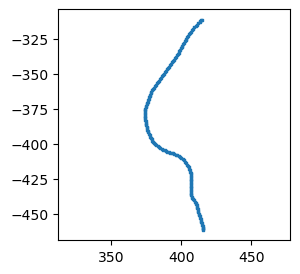

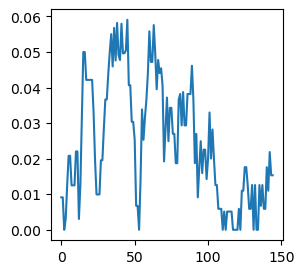

0.02460612552743829


In [182]:
i=4
j=10
nodes = smooth_points(list(l_l_skeleton_candidates[i][j][0]))
x_coords = [n[1] for n in nodes]
y_coords = [-n[0] for n in nodes]
plt.figure(figsize=(3,3))
plt.scatter(x_coords, y_coords, s=1, marker='s')
plt.axis("equal")
plt.show()
plt.figure(figsize=(3,3))
plt.plot(courbure(l_l_skeleton_candidates[i][j][0]))
plt.show()
print(np.mean(courbure(l_l_skeleton_candidates[i][j][0])))

In [183]:
l_one_nematod_in_one_connexe_part = []

for i in range(len(l_l_skeleton_candidates)):
    for j in range(len(l_l_skeleton_candidates[i])):
        if len(l_l_skeleton_candidates[i][j]) == 1:
            """nodes = smooth_points(list(l_l_skeleton_candidates[i][j][0]))
            x_coords = [n[1] for n in nodes]
            y_coords = [-n[0] for n in nodes]
            plt.figure(figsize=(3,3))
            plt.scatter(x_coords, y_coords, s=1, marker='s')
            plt.axis("equal")
            plt.show()"""
            l_one_nematod_in_one_connexe_part.append(len(l_l_skeleton_candidates[i][j][0]))

print(len(l_one_nematod_in_one_connexe_part))

554


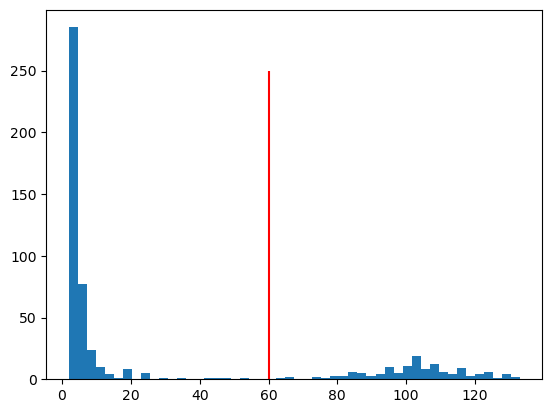

In [184]:
plt.hist(l_one_nematod_in_one_connexe_part, bins = 50)
plt.vlines(60,0,250, colors='red')
plt.show()

In [185]:
def choose_candidate(l_l_skeleton_candidates):
    l_l_nematods = []
    for i in range(len(l_l_skeleton_candidates)):
        l_l_nematods.append([])
        for j in range(len(l_l_skeleton_candidates[i])):
            if len(l_l_skeleton_candidates[i][j]) == 1: # partie connexe avec une seule possibilité : un bruit ou un nematode unique
                if len(l_l_skeleton_candidates[i][j][0]) > 60 :
                    l_l_nematods[i].append(l_l_skeleton_candidates[i][j][0])
            else :
                # complicated part
                a=1
    return l_l_nematods

In [186]:
l_l_nematods = choose_candidate(l_l_skeleton_candidates)

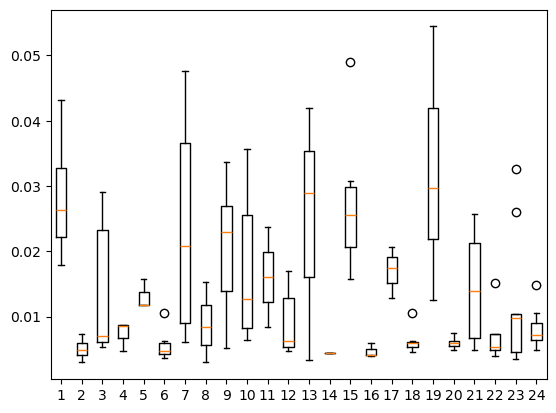

In [201]:
plt.boxplot([[np.mean(courbure(nematod)) for nematod in l_l_nematods[i]] for i in range(len(l_l_nematods))])
plt.show()

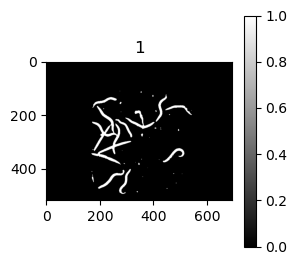

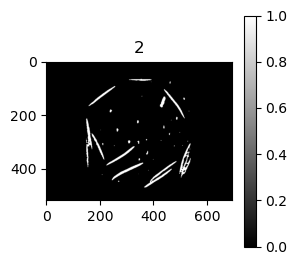

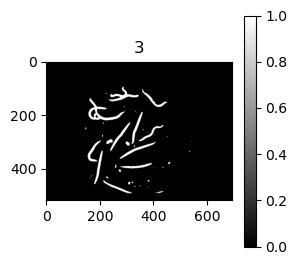

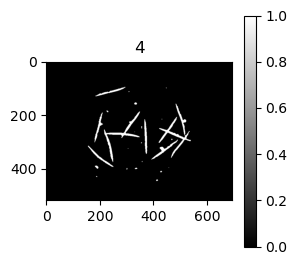

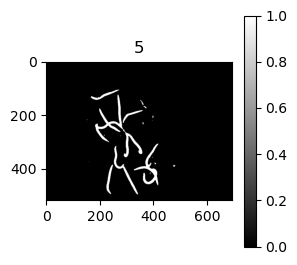

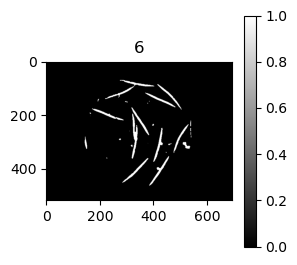

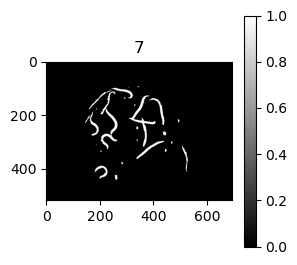

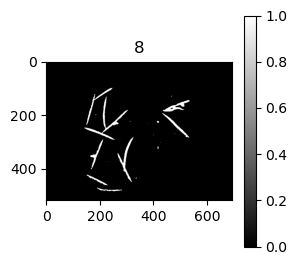

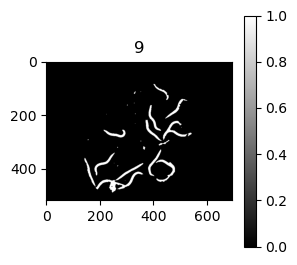

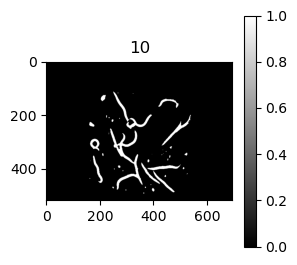

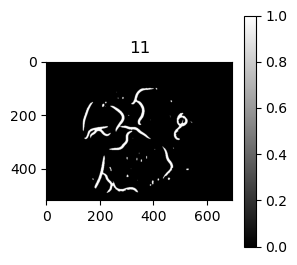

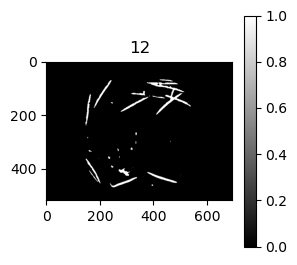

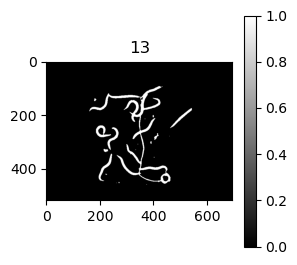

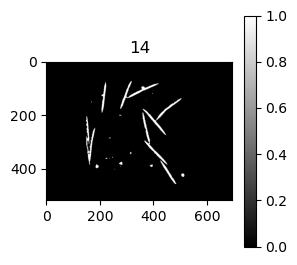

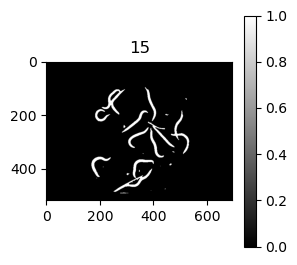

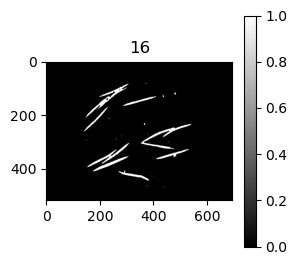

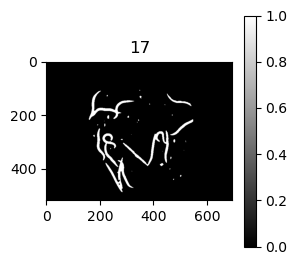

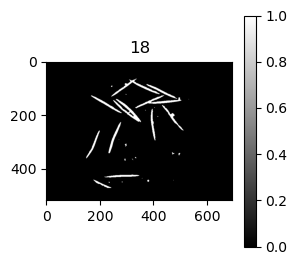

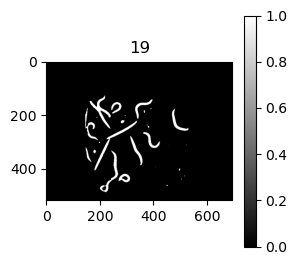

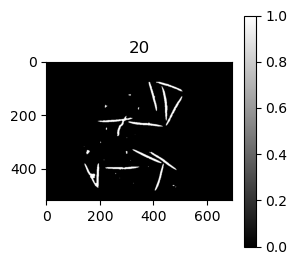

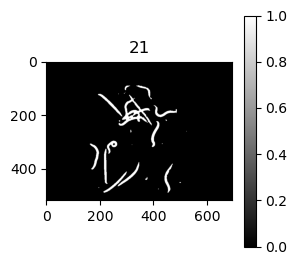

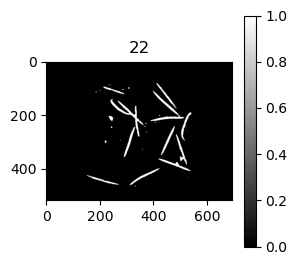

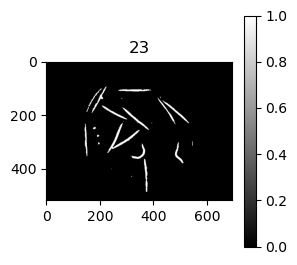

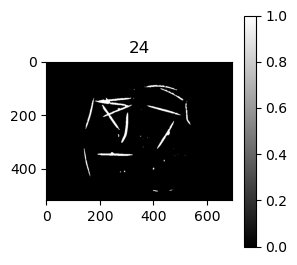

In [207]:
for i,img in enumerate(l_img_morph_fill):
    plt.figure(figsize=(3,3))
    plt.imshow(img, cmap="gray")
    plt.title(i+1)
    plt.colorbar()
    plt.show()

# Calcul des caractéristiques géométriques

# Analyse des résultats

# Conclusion